# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [12]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [13]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [14]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))) or (('stored_game_boxes' in locals()) & (len(box_score.columns) != len(stored_game_boxes.columns))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

[Local] Box Scores are not available, generating them from scratch...
[1/6644] Getting game information for ESPN game_id: 322432309...
[1/6644] Started processing game information for ESPN game_id: 322432309...
[1/6644] Skipping checking game_id 322432309 bc one of the teams isn't FBS.
[2/6644] Getting game information for ESPN game_id: 322432006...
[2/6644] Started processing game information for ESPN game_id: 322432006...
[2/6644] Completed processing game information for ESPN game_id: 322432006.
[2/6644] Aggreggated game_id 322432006 to master data copy.
[3/6644] Getting game information for ESPN game_id: 322430238...
[3/6644] Started processing game information for ESPN game_id: 322430238...
[3/6644] Completed processing game information for ESPN game_id: 322430238.
[3/6644] Aggreggated game_id 322430238 to master data copy.
[4/6644] Getting game information for ESPN game_id: 322432117...
[4/6644] Started processing game information for ESPN game_id: 322432117...
[4/6644] Skipping 

[35/6644] Completed processing game information for ESPN game_id: 322450025.
[35/6644] Aggreggated game_id 322450025 to master data copy.
[36/6644] Getting game information for ESPN game_id: 322450103...
[36/6644] Started processing game information for ESPN game_id: 322450103...
[36/6644] Completed processing game information for ESPN game_id: 322450103.
[36/6644] Aggreggated game_id 322450103 to master data copy.
[37/6644] Getting game information for ESPN game_id: 322450275...
[37/6644] Started processing game information for ESPN game_id: 322450275...
[37/6644] Skipping checking game_id 322450275 bc one of the teams isn't FBS.
[38/6644] Getting game information for ESPN game_id: 322452509...
[38/6644] Started processing game information for ESPN game_id: 322452509...
[38/6644] Skipping checking game_id 322452509 bc one of the teams isn't FBS.
[39/6644] Getting game information for ESPN game_id: 322450158...
[39/6644] Started processing game information for ESPN game_id: 322450158..

[68/6644] Completed processing game information for ESPN game_id: 322450333.
[68/6644] Aggreggated game_id 322450333 to master data copy.
[69/6644] Getting game information for ESPN game_id: 322450278...
[69/6644] Started processing game information for ESPN game_id: 322450278...
[69/6644] Skipping checking game_id 322450278 bc one of the teams isn't FBS.
[70/6644] Getting game information for ESPN game_id: 322452483...
[70/6644] Started processing game information for ESPN game_id: 322452483...
[70/6644] Completed processing game information for ESPN game_id: 322452483.
[70/6644] Aggreggated game_id 322452483 to master data copy.
[71/6644] Getting game information for ESPN game_id: 322452638...
[71/6644] Started processing game information for ESPN game_id: 322452638...
[71/6644] Completed processing game information for ESPN game_id: 322452638.
[71/6644] Aggreggated game_id 322452638 to master data copy.
[72/6644] Getting game information for ESPN game_id: 322450264...
[72/6644] Star

[100/6644] Completed processing game information for ESPN game_id: 322520245.
[100/6644] Aggreggated game_id 322520245 to master data copy.
[101/6644] Getting game information for ESPN game_id: 322520333...
[101/6644] Started processing game information for ESPN game_id: 322520333...
[101/6644] Completed processing game information for ESPN game_id: 322520333.
[101/6644] Aggreggated game_id 322520333 to master data copy.
[102/6644] Getting game information for ESPN game_id: 322520164...
[102/6644] Started processing game information for ESPN game_id: 322520164...
[102/6644] Skipping checking game_id 322520164 bc one of the teams isn't FBS.
[103/6644] Getting game information for ESPN game_id: 322520183...
[103/6644] Started processing game information for ESPN game_id: 322520183...
[103/6644] Completed processing game information for ESPN game_id: 322520183.
[103/6644] Aggreggated game_id 322520183 to master data copy.
[104/6644] Getting game information for ESPN game_id: 322522117...


[133/6644] Completed processing game information for ESPN game_id: 322520145.
[133/6644] Aggreggated game_id 322520145 to master data copy.
[134/6644] Getting game information for ESPN game_id: 322520189...
[134/6644] Started processing game information for ESPN game_id: 322520189...
[134/6644] Skipping checking game_id 322520189 bc one of the teams isn't FBS.
[135/6644] Getting game information for ESPN game_id: 322520195...
[135/6644] Started processing game information for ESPN game_id: 322520195...
[135/6644] Completed processing game information for ESPN game_id: 322520195.
[135/6644] Aggreggated game_id 322520195 to master data copy.
[136/6644] Getting game information for ESPN game_id: 322520021...
[136/6644] Started processing game information for ESPN game_id: 322520021...
[136/6644] Completed processing game information for ESPN game_id: 322520021.
[136/6644] Aggreggated game_id 322520021 to master data copy.
[137/6644] Getting game information for ESPN game_id: 322520096...


[164/6644] Completed processing game information for ESPN game_id: 322590120.
[164/6644] Aggreggated game_id 322590120 to master data copy.
[165/6644] Getting game information for ESPN game_id: 322590228...
[165/6644] Started processing game information for ESPN game_id: 322590228...
[165/6644] Skipping checking game_id 322590228 bc one of the teams isn't FBS.
[166/6644] Getting game information for ESPN game_id: 322592483...
[166/6644] Started processing game information for ESPN game_id: 322592483...
[166/6644] Skipping checking game_id 322592483 bc one of the teams isn't FBS.
[167/6644] Getting game information for ESPN game_id: 322590130...
[167/6644] Started processing game information for ESPN game_id: 322590130...
[167/6644] Completed processing game information for ESPN game_id: 322590130.
[167/6644] Aggreggated game_id 322590130 to master data copy.
[168/6644] Getting game information for ESPN game_id: 322590008...
[168/6644] Started processing game information for ESPN game_i

[195/6644] Completed processing game information for ESPN game_id: 322590096.
[195/6644] Aggreggated game_id 322590096 to master data copy.
[196/6644] Getting game information for ESPN game_id: 322590142...
[196/6644] Started processing game information for ESPN game_id: 322590142...
[196/6644] Completed processing game information for ESPN game_id: 322590142.
[196/6644] Aggreggated game_id 322590142 to master data copy.
[197/6644] Getting game information for ESPN game_id: 322592579...
[197/6644] Started processing game information for ESPN game_id: 322592579...
[197/6644] Completed processing game information for ESPN game_id: 322592579.
[197/6644] Aggreggated game_id 322592579 to master data copy.
[198/6644] Getting game information for ESPN game_id: 322592306...
[198/6644] Started processing game information for ESPN game_id: 322592306...
[198/6644] Completed processing game information for ESPN game_id: 322592306.
[198/6644] Aggreggated game_id 322592306 to master data copy.
[199/

[225/6644] Completed processing game information for ESPN game_id: 322660193.
[225/6644] Aggreggated game_id 322660193 to master data copy.
[226/6644] Getting game information for ESPN game_id: 322660275...
[226/6644] Started processing game information for ESPN game_id: 322660275...
[226/6644] Completed processing game information for ESPN game_id: 322660275.
[226/6644] Aggreggated game_id 322660275 to master data copy.
[227/6644] Getting game information for ESPN game_id: 322660194...
[227/6644] Started processing game information for ESPN game_id: 322660194...
[227/6644] Completed processing game information for ESPN game_id: 322660194.
[227/6644] Aggreggated game_id 322660194 to master data copy.
[228/6644] Getting game information for ESPN game_id: 322660259...
[228/6644] Started processing game information for ESPN game_id: 322660259...
[228/6644] Completed processing game information for ESPN game_id: 322660259.
[228/6644] Aggreggated game_id 322660259 to master data copy.
[229/

[256/6644] Completed processing game information for ESPN game_id: 322660344.
[256/6644] Aggreggated game_id 322660344 to master data copy.
[257/6644] Getting game information for ESPN game_id: 322660249...
[257/6644] Started processing game information for ESPN game_id: 322660249...
[257/6644] Completed processing game information for ESPN game_id: 322660249.
[257/6644] Aggreggated game_id 322660249 to master data copy.
[258/6644] Getting game information for ESPN game_id: 322660036...
[258/6644] Started processing game information for ESPN game_id: 322660036...
[258/6644] Completed processing game information for ESPN game_id: 322660036.
[258/6644] Aggreggated game_id 322660036 to master data copy.
[259/6644] Getting game information for ESPN game_id: 322660008...
[259/6644] Started processing game information for ESPN game_id: 322660008...
[259/6644] Completed processing game information for ESPN game_id: 322660008.
[259/6644] Aggreggated game_id 322660008 to master data copy.
[260/

[286/6644] Completed processing game information for ESPN game_id: 322732116.
[286/6644] Aggreggated game_id 322732116 to master data copy.
[287/6644] Getting game information for ESPN game_id: 322732294...
[287/6644] Started processing game information for ESPN game_id: 322732294...
[287/6644] Completed processing game information for ESPN game_id: 322732294.
[287/6644] Aggreggated game_id 322732294 to master data copy.
[288/6644] Getting game information for ESPN game_id: 322732309...
[288/6644] Started processing game information for ESPN game_id: 322732309...
[288/6644] Completed processing game information for ESPN game_id: 322732309.
[288/6644] Aggreggated game_id 322732309 to master data copy.
[289/6644] Getting game information for ESPN game_id: 322730245...
[289/6644] Started processing game information for ESPN game_id: 322730245...
[289/6644] Completed processing game information for ESPN game_id: 322730245.
[289/6644] Aggreggated game_id 322730245 to master data copy.
[290/

[316/6644] Completed processing game information for ESPN game_id: 322730096.
[316/6644] Aggreggated game_id 322730096 to master data copy.
[317/6644] Getting game information for ESPN game_id: 322732567...
[317/6644] Started processing game information for ESPN game_id: 322732567...
[317/6644] Completed processing game information for ESPN game_id: 322732567.
[317/6644] Aggreggated game_id 322732567 to master data copy.
[318/6644] Getting game information for ESPN game_id: 322730309...
[318/6644] Started processing game information for ESPN game_id: 322730309...
[318/6644] Completed processing game information for ESPN game_id: 322730309.
[318/6644] Aggreggated game_id 322730309 to master data copy.
[319/6644] Getting game information for ESPN game_id: 322732032...
[319/6644] Started processing game information for ESPN game_id: 322732032...
[319/6644] Completed processing game information for ESPN game_id: 322732032.
[319/6644] Aggreggated game_id 322732032 to master data copy.
[320/

[345/6644] Completed processing game information for ESPN game_id: 322802572.
[345/6644] Aggreggated game_id 322802572 to master data copy.
[346/6644] Getting game information for ESPN game_id: 322800096...
[346/6644] Started processing game information for ESPN game_id: 322800096...
[346/6644] Completed processing game information for ESPN game_id: 322800096.
[346/6644] Aggreggated game_id 322800096 to master data copy.
[347/6644] Getting game information for ESPN game_id: 322800153...
[347/6644] Started processing game information for ESPN game_id: 322800153...
[347/6644] Completed processing game information for ESPN game_id: 322800153.
[347/6644] Aggreggated game_id 322800153 to master data copy.
[348/6644] Getting game information for ESPN game_id: 322802199...
[348/6644] Started processing game information for ESPN game_id: 322802199...
[348/6644] Completed processing game information for ESPN game_id: 322802199.
[348/6644] Aggreggated game_id 322802199 to master data copy.
[349/

[375/6644] Completed processing game information for ESPN game_id: 322800248.
[375/6644] Aggreggated game_id 322800248 to master data copy.
[376/6644] Getting game information for ESPN game_id: 322800235...
[376/6644] Started processing game information for ESPN game_id: 322800235...
[376/6644] Completed processing game information for ESPN game_id: 322800235.
[376/6644] Aggreggated game_id 322800235 to master data copy.
[377/6644] Getting game information for ESPN game_id: 322802440...
[377/6644] Started processing game information for ESPN game_id: 322802440...
[377/6644] Completed processing game information for ESPN game_id: 322802440.
[377/6644] Aggreggated game_id 322802440 to master data copy.
[378/6644] Getting game information for ESPN game_id: 322802579...
[378/6644] Started processing game information for ESPN game_id: 322802579...
[378/6644] Completed processing game information for ESPN game_id: 322802579.
[378/6644] Aggreggated game_id 322802579 to master data copy.
[379/

Could not find drive data for game_id 322870195 on CFB Data API, bailing out
[404/6644] Got 'None' for game_id 322870195's box score, skipping processing.
[405/6644] Getting game information for ESPN game_id: 322872390...
[405/6644] Started processing game information for ESPN game_id: 322872390...
[405/6644] Completed processing game information for ESPN game_id: 322872390.
[405/6644] Aggreggated game_id 322872390 to master data copy.
[406/6644] Getting game information for ESPN game_id: 322870026...
[406/6644] Started processing game information for ESPN game_id: 322870026...
[406/6644] Completed processing game information for ESPN game_id: 322870026.
[406/6644] Aggreggated game_id 322870026 to master data copy.
[407/6644] Getting game information for ESPN game_id: 322872439...
[407/6644] Started processing game information for ESPN game_id: 322872439...
[407/6644] Completed processing game information for ESPN game_id: 322872439.
[407/6644] Aggreggated game_id 322872439 to master d

[434/6644] Completed processing game information for ESPN game_id: 322870084.
[434/6644] Aggreggated game_id 322870084 to master data copy.
[435/6644] Getting game information for ESPN game_id: 322872433...
[435/6644] Started processing game information for ESPN game_id: 322872433...
[435/6644] Completed processing game information for ESPN game_id: 322872433.
[435/6644] Aggreggated game_id 322872433 to master data copy.
[436/6644] Getting game information for ESPN game_id: 322872116...
[436/6644] Started processing game information for ESPN game_id: 322872116...
[436/6644] Completed processing game information for ESPN game_id: 322872116.
[436/6644] Aggreggated game_id 322872116 to master data copy.
[437/6644] Getting game information for ESPN game_id: 322872348...
[437/6644] Started processing game information for ESPN game_id: 322872348...
[437/6644] Completed processing game information for ESPN game_id: 322872348.
[437/6644] Aggreggated game_id 322872348 to master data copy.
[438/

[463/6644] Completed processing game information for ESPN game_id: 322940068.
[463/6644] Aggreggated game_id 322940068 to master data copy.
[464/6644] Getting game information for ESPN game_id: 322942628...
[464/6644] Started processing game information for ESPN game_id: 322942628...
[464/6644] Completed processing game information for ESPN game_id: 322942628.
[464/6644] Aggreggated game_id 322942628 to master data copy.
[465/6644] Getting game information for ESPN game_id: 322940202...
[465/6644] Started processing game information for ESPN game_id: 322940202...
[465/6644] Completed processing game information for ESPN game_id: 322940202.
[465/6644] Aggreggated game_id 322940202 to master data copy.
[466/6644] Getting game information for ESPN game_id: 322942117...
[466/6644] Started processing game information for ESPN game_id: 322942117...
[466/6644] Completed processing game information for ESPN game_id: 322942117.
[466/6644] Aggreggated game_id 322942117 to master data copy.
[467/

[492/6644] Completed processing game information for ESPN game_id: 322940235.
[492/6644] Aggreggated game_id 322940235 to master data copy.
[493/6644] Getting game information for ESPN game_id: 322940012...
[493/6644] Started processing game information for ESPN game_id: 322940012...
[493/6644] Completed processing game information for ESPN game_id: 322940012.
[493/6644] Aggreggated game_id 322940012 to master data copy.
[494/6644] Getting game information for ESPN game_id: 322940278...
[494/6644] Started processing game information for ESPN game_id: 322940278...
[494/6644] Completed processing game information for ESPN game_id: 322940278.
[494/6644] Aggreggated game_id 322940278 to master data copy.
[495/6644] Getting game information for ESPN game_id: 322940204...
[495/6644] Started processing game information for ESPN game_id: 322940204...
[495/6644] Completed processing game information for ESPN game_id: 322940204.
[495/6644] Aggreggated game_id 322940204 to master data copy.
[496/

[521/6644] Completed processing game information for ESPN game_id: 323010164.
[521/6644] Aggreggated game_id 323010164 to master data copy.
[522/6644] Getting game information for ESPN game_id: 323010052...
[522/6644] Started processing game information for ESPN game_id: 323010052...
[522/6644] Completed processing game information for ESPN game_id: 323010052.
[522/6644] Aggreggated game_id 323010052 to master data copy.
[523/6644] Getting game information for ESPN game_id: 323010012...
[523/6644] Started processing game information for ESPN game_id: 323010012...
[523/6644] Completed processing game information for ESPN game_id: 323010012.
[523/6644] Aggreggated game_id 323010012 to master data copy.
[524/6644] Getting game information for ESPN game_id: 323012751...
[524/6644] Started processing game information for ESPN game_id: 323012751...
[524/6644] Completed processing game information for ESPN game_id: 323012751.
[524/6644] Aggreggated game_id 323012751 to master data copy.
[525/

[550/6644] Completed processing game information for ESPN game_id: 323010158.
[550/6644] Aggreggated game_id 323010158 to master data copy.
[551/6644] Getting game information for ESPN game_id: 323010201...
[551/6644] Started processing game information for ESPN game_id: 323010201...
[551/6644] Completed processing game information for ESPN game_id: 323010201.
[551/6644] Aggreggated game_id 323010201 to master data copy.
[552/6644] Getting game information for ESPN game_id: 323010333...
[552/6644] Started processing game information for ESPN game_id: 323010333...
[552/6644] Completed processing game information for ESPN game_id: 323010333.
[552/6644] Aggreggated game_id 323010333 to master data copy.
[553/6644] Getting game information for ESPN game_id: 323010254...
[553/6644] Started processing game information for ESPN game_id: 323010254...
[553/6644] Completed processing game information for ESPN game_id: 323010254.
[553/6644] Aggreggated game_id 323010254 to master data copy.
[554/

[579/6644] Completed processing game information for ESPN game_id: 323080277.
[579/6644] Aggreggated game_id 323080277 to master data copy.
[580/6644] Getting game information for ESPN game_id: 323080254...
[580/6644] Started processing game information for ESPN game_id: 323080254...
[580/6644] Completed processing game information for ESPN game_id: 323080254.
[580/6644] Aggreggated game_id 323080254 to master data copy.
[581/6644] Getting game information for ESPN game_id: 323082509...
[581/6644] Started processing game information for ESPN game_id: 323082509...
[581/6644] Completed processing game information for ESPN game_id: 323082509.
[581/6644] Aggreggated game_id 323082509 to master data copy.
[582/6644] Getting game information for ESPN game_id: 323080127...
[582/6644] Started processing game information for ESPN game_id: 323080127...
[582/6644] Completed processing game information for ESPN game_id: 323080127.
[582/6644] Aggreggated game_id 323080127 to master data copy.
[583/

[608/6644] Completed processing game information for ESPN game_id: 323080204.
[608/6644] Aggreggated game_id 323080204 to master data copy.
[609/6644] Getting game information for ESPN game_id: 323080026...
[609/6644] Started processing game information for ESPN game_id: 323080026...
[609/6644] Completed processing game information for ESPN game_id: 323080026.
[609/6644] Aggreggated game_id 323080026 to master data copy.
[610/6644] Getting game information for ESPN game_id: 323080068...
[610/6644] Started processing game information for ESPN game_id: 323080068...
[610/6644] Completed processing game information for ESPN game_id: 323080068.
[610/6644] Aggreggated game_id 323080068 to master data copy.
[611/6644] Getting game information for ESPN game_id: 323112649...
[611/6644] Started processing game information for ESPN game_id: 323112649...
[611/6644] Completed processing game information for ESPN game_id: 323112649.
[611/6644] Aggreggated game_id 323112649 to master data copy.
[612/

[637/6644] Completed processing game information for ESPN game_id: 323150158.
[637/6644] Aggreggated game_id 323150158 to master data copy.
[638/6644] Getting game information for ESPN game_id: 323150201...
[638/6644] Started processing game information for ESPN game_id: 323150201...
[638/6644] Completed processing game information for ESPN game_id: 323150201.
[638/6644] Aggreggated game_id 323150201 to master data copy.
[639/6644] Getting game information for ESPN game_id: 323150333...
[639/6644] Started processing game information for ESPN game_id: 323150333...
[639/6644] Completed processing game information for ESPN game_id: 323150333.
[639/6644] Aggreggated game_id 323150333 to master data copy.
[640/6644] Getting game information for ESPN game_id: 323150228...
[640/6644] Started processing game information for ESPN game_id: 323150228...
[640/6644] Completed processing game information for ESPN game_id: 323150228.
[640/6644] Aggreggated game_id 323150228 to master data copy.
[641/

[667/6644] Completed processing game information for ESPN game_id: 323152440.
[667/6644] Aggreggated game_id 323152440 to master data copy.
[668/6644] Getting game information for ESPN game_id: 323192050...
[668/6644] Started processing game information for ESPN game_id: 323192050...
[668/6644] Completed processing game information for ESPN game_id: 323192050.
[668/6644] Aggreggated game_id 323192050 to master data copy.
[669/6644] Getting game information for ESPN game_id: 323192459...
[669/6644] Started processing game information for ESPN game_id: 323192459...
[669/6644] Completed processing game information for ESPN game_id: 323192459.
[669/6644] Aggreggated game_id 323192459 to master data copy.
[670/6644] Getting game information for ESPN game_id: 323200258...
[670/6644] Started processing game information for ESPN game_id: 323200258...
[670/6644] Completed processing game information for ESPN game_id: 323200258.
[670/6644] Aggreggated game_id 323200258 to master data copy.
[671/

Could not find drive data for game_id 323220113 on CFB Data API, bailing out
[696/6644] Got 'None' for game_id 323220113's box score, skipping processing.
[697/6644] Getting game information for ESPN game_id: 323220026...
[697/6644] Started processing game information for ESPN game_id: 323220026...
[697/6644] Completed processing game information for ESPN game_id: 323220026.
[697/6644] Aggreggated game_id 323220026 to master data copy.
[698/6644] Getting game information for ESPN game_id: 323220228...
[698/6644] Started processing game information for ESPN game_id: 323220228...
[698/6644] Completed processing game information for ESPN game_id: 323220228.
[698/6644] Aggreggated game_id 323220228 to master data copy.
[699/6644] Getting game information for ESPN game_id: 323220158...
[699/6644] Started processing game information for ESPN game_id: 323220158...
[699/6644] Completed processing game information for ESPN game_id: 323220158.
[699/6644] Aggreggated game_id 323220158 to master d

[726/6644] Completed processing game information for ESPN game_id: 323222483.
[726/6644] Aggreggated game_id 323222483 to master data copy.
[727/6644] Getting game information for ESPN game_id: 323220254...
[727/6644] Started processing game information for ESPN game_id: 323220254...
[727/6644] Completed processing game information for ESPN game_id: 323220254.
[727/6644] Aggreggated game_id 323220254 to master data copy.
[728/6644] Getting game information for ESPN game_id: 323220023...
[728/6644] Started processing game information for ESPN game_id: 323220023...
[728/6644] Completed processing game information for ESPN game_id: 323220023.
[728/6644] Aggreggated game_id 323220023 to master data copy.
[729/6644] Getting game information for ESPN game_id: 323220204...
[729/6644] Started processing game information for ESPN game_id: 323220204...
[729/6644] Completed processing game information for ESPN game_id: 323220204.
[729/6644] Aggreggated game_id 323220204 to master data copy.
[730/

[755/6644] Completed processing game information for ESPN game_id: 323292633.
[755/6644] Aggreggated game_id 323292633 to master data copy.
[756/6644] Getting game information for ESPN game_id: 323290150...
[756/6644] Started processing game information for ESPN game_id: 323290150...
[756/6644] Completed processing game information for ESPN game_id: 323290150.
[756/6644] Aggreggated game_id 323290150 to master data copy.
[757/6644] Getting game information for ESPN game_id: 323290098...
[757/6644] Started processing game information for ESPN game_id: 323290098...
[757/6644] Completed processing game information for ESPN game_id: 323290098.
[757/6644] Aggreggated game_id 323290098 to master data copy.
[758/6644] Getting game information for ESPN game_id: 323292636...
[758/6644] Started processing game information for ESPN game_id: 323292636...
[758/6644] Completed processing game information for ESPN game_id: 323292636.
[758/6644] Aggreggated game_id 323292636 to master data copy.
[759/

[784/6644] Completed processing game information for ESPN game_id: 323290030.
[784/6644] Aggreggated game_id 323290030 to master data copy.
[785/6644] Getting game information for ESPN game_id: 323290023...
[785/6644] Started processing game information for ESPN game_id: 323290023...
[785/6644] Completed processing game information for ESPN game_id: 323290023.
[785/6644] Aggreggated game_id 323290023 to master data copy.
[786/6644] Getting game information for ESPN game_id: 323290062...
[786/6644] Started processing game information for ESPN game_id: 323290062...
[786/6644] Completed processing game information for ESPN game_id: 323290062.
[786/6644] Aggreggated game_id 323290062 to master data copy.
[787/6644] Getting game information for ESPN game_id: 323340164...
[787/6644] Started processing game information for ESPN game_id: 323340164...
[787/6644] Completed processing game information for ESPN game_id: 323340164.
[787/6644] Aggreggated game_id 323340164 to master data copy.
[788/

[819/6644] Completed processing game information for ESPN game_id: 332410254.
[819/6644] Aggreggated game_id 332410254 to master data copy.
[820/6644] Getting game information for ESPN game_id: 332410238...
[820/6644] Started processing game information for ESPN game_id: 332410238...
[820/6644] Completed processing game information for ESPN game_id: 332410238.
[820/6644] Aggreggated game_id 332410238 to master data copy.
[821/6644] Getting game information for ESPN game_id: 332410023...
[821/6644] Started processing game information for ESPN game_id: 332410023...
[821/6644] Skipping checking game_id 332410023 bc one of the teams isn't FBS.
[822/6644] Getting game information for ESPN game_id: 332410278...
[822/6644] Started processing game information for ESPN game_id: 332410278...
[822/6644] Completed processing game information for ESPN game_id: 332410278.
[822/6644] Aggreggated game_id 332410278 to master data copy.
[823/6644] Getting game information for ESPN game_id: 332410062...


[852/6644] Completed processing game information for ESPN game_id: 332430008.
[852/6644] Aggreggated game_id 332430008 to master data copy.
[853/6644] Getting game information for ESPN game_id: 332430259...
[853/6644] Started processing game information for ESPN game_id: 332430259...
[853/6644] Completed processing game information for ESPN game_id: 332430259.
[853/6644] Aggreggated game_id 332430259 to master data copy.
[854/6644] Getting game information for ESPN game_id: 332432199...
[854/6644] Started processing game information for ESPN game_id: 332432199...
[854/6644] Skipping checking game_id 332432199 bc one of the teams isn't FBS.
[855/6644] Getting game information for ESPN game_id: 332430204...
[855/6644] Started processing game information for ESPN game_id: 332430204...
[855/6644] Skipping checking game_id 332430204 bc one of the teams isn't FBS.
[856/6644] Getting game information for ESPN game_id: 332432633...
[856/6644] Started processing game information for ESPN game_i

[884/6644] Completed processing game information for ESPN game_id: 332490103.
[884/6644] Aggreggated game_id 332490103 to master data copy.
[885/6644] Getting game information for ESPN game_id: 332492229...
[885/6644] Started processing game information for ESPN game_id: 332492229...
[885/6644] Completed processing game information for ESPN game_id: 332492229.
[885/6644] Aggreggated game_id 332492229 to master data copy.
[886/6644] Getting game information for ESPN game_id: 332502294...
[886/6644] Started processing game information for ESPN game_id: 332502294...
[886/6644] Skipping checking game_id 332502294 bc one of the teams isn't FBS.
[887/6644] Getting game information for ESPN game_id: 332502309...
[887/6644] Started processing game information for ESPN game_id: 332502309...
[887/6644] Completed processing game information for ESPN game_id: 332502309.
[887/6644] Aggreggated game_id 332502309 to master data copy.
[888/6644] Getting game information for ESPN game_id: 332502509...


[916/6644] Completed processing game information for ESPN game_id: 332502655.
[916/6644] Aggreggated game_id 332502655 to master data copy.
[917/6644] Getting game information for ESPN game_id: 332500120...
[917/6644] Started processing game information for ESPN game_id: 332500120...
[917/6644] Completed processing game information for ESPN game_id: 332500120.
[917/6644] Aggreggated game_id 332500120 to master data copy.
[918/6644] Getting game information for ESPN game_id: 332502751...
[918/6644] Started processing game information for ESPN game_id: 332502751...
[918/6644] Skipping checking game_id 332502751 bc one of the teams isn't FBS.
[919/6644] Getting game information for ESPN game_id: 332500061...
[919/6644] Started processing game information for ESPN game_id: 332500061...
[919/6644] Completed processing game information for ESPN game_id: 332500061.
[919/6644] Aggreggated game_id 332500061 to master data copy.
[920/6644] Getting game information for ESPN game_id: 332500235...


[949/6644] Completed processing game information for ESPN game_id: 332500166.
[949/6644] Aggreggated game_id 332500166 to master data copy.
[950/6644] Getting game information for ESPN game_id: 332500130...
[950/6644] Started processing game information for ESPN game_id: 332500130...
[950/6644] Completed processing game information for ESPN game_id: 332500130.
[950/6644] Aggreggated game_id 332500130 to master data copy.
[951/6644] Getting game information for ESPN game_id: 332502567...
[951/6644] Started processing game information for ESPN game_id: 332502567...
[951/6644] Skipping checking game_id 332502567 bc one of the teams isn't FBS.
[952/6644] Getting game information for ESPN game_id: 332502440...
[952/6644] Started processing game information for ESPN game_id: 332502440...
[952/6644] Skipping checking game_id 332502440 bc one of the teams isn't FBS.
[953/6644] Getting game information for ESPN game_id: 332500278...
[953/6644] Started processing game information for ESPN game_i

[980/6644] Completed processing game information for ESPN game_id: 332572483.
[980/6644] Aggreggated game_id 332572483 to master data copy.
[981/6644] Getting game information for ESPN game_id: 332572084...
[981/6644] Started processing game information for ESPN game_id: 332572084...
[981/6644] Skipping checking game_id 332572084 bc one of the teams isn't FBS.
[982/6644] Getting game information for ESPN game_id: 332572426...
[982/6644] Started processing game information for ESPN game_id: 332572426...
[982/6644] Skipping checking game_id 332572426 bc one of the teams isn't FBS.
[983/6644] Getting game information for ESPN game_id: 332570150...
[983/6644] Started processing game information for ESPN game_id: 332570150...
[983/6644] Completed processing game information for ESPN game_id: 332570150.
[983/6644] Aggreggated game_id 332570150 to master data copy.
[984/6644] Getting game information for ESPN game_id: 332572751...
[984/6644] Started processing game information for ESPN game_i

[1012/6644] Completed processing game information for ESPN game_id: 332570195.
[1012/6644] Aggreggated game_id 332570195 to master data copy.
[1013/6644] Getting game information for ESPN game_id: 332570077...
[1013/6644] Started processing game information for ESPN game_id: 332570077...
[1013/6644] Completed processing game information for ESPN game_id: 332570077.
[1013/6644] Aggreggated game_id 332570077 to master data copy.
[1014/6644] Getting game information for ESPN game_id: 332570254...
[1014/6644] Started processing game information for ESPN game_id: 332570254...
[1014/6644] Completed processing game information for ESPN game_id: 332570254.
[1014/6644] Aggreggated game_id 332570254 to master data copy.
[1015/6644] Getting game information for ESPN game_id: 332572439...
[1015/6644] Started processing game information for ESPN game_id: 332572439...
[1015/6644] Completed processing game information for ESPN game_id: 332572439.
[1015/6644] Aggreggated game_id 332572439 to master da

[1042/6644] Completed processing game information for ESPN game_id: 332640164.
[1042/6644] Aggreggated game_id 332640164 to master data copy.
[1043/6644] Getting game information for ESPN game_id: 332640120...
[1043/6644] Started processing game information for ESPN game_id: 332640120...
[1043/6644] Completed processing game information for ESPN game_id: 332640120.
[1043/6644] Aggreggated game_id 332640120 to master data copy.
[1044/6644] Getting game information for ESPN game_id: 332640077...
[1044/6644] Started processing game information for ESPN game_id: 332640077...
[1044/6644] Skipping checking game_id 332640077 bc one of the teams isn't FBS.
[1045/6644] Getting game information for ESPN game_id: 332640057...
[1045/6644] Started processing game information for ESPN game_id: 332640057...
[1045/6644] Completed processing game information for ESPN game_id: 332640057.
[1045/6644] Aggreggated game_id 332640057 to master data copy.
[1046/6644] Getting game information for ESPN game_id:

[1073/6644] Completed processing game information for ESPN game_id: 332640252.
[1073/6644] Aggreggated game_id 332640252 to master data copy.
[1074/6644] Getting game information for ESPN game_id: 332642005...
[1074/6644] Started processing game information for ESPN game_id: 332642005...
[1074/6644] Completed processing game information for ESPN game_id: 332642005.
[1074/6644] Aggreggated game_id 332642005 to master data copy.
[1075/6644] Getting game information for ESPN game_id: 332640265...
[1075/6644] Started processing game information for ESPN game_id: 332640265...
[1075/6644] Skipping checking game_id 332640265 bc one of the teams isn't FBS.
[1076/6644] Getting game information for ESPN game_id: 332640026...
[1076/6644] Started processing game information for ESPN game_id: 332640026...
[1076/6644] Completed processing game information for ESPN game_id: 332640026.
[1076/6644] Aggreggated game_id 332640026 to master data copy.
[1077/6644] Getting game information for ESPN game_id:

[1102/6644] Completed processing game information for ESPN game_id: 332710087.
[1102/6644] Aggreggated game_id 332710087 to master data copy.
[1103/6644] Getting game information for ESPN game_id: 332712348...
[1103/6644] Started processing game information for ESPN game_id: 332712348...
[1103/6644] Completed processing game information for ESPN game_id: 332712348.
[1103/6644] Aggreggated game_id 332712348 to master data copy.
[1104/6644] Getting game information for ESPN game_id: 332712636...
[1104/6644] Started processing game information for ESPN game_id: 332712636...
[1104/6644] Completed processing game information for ESPN game_id: 332712636.
[1104/6644] Aggreggated game_id 332712636 to master data copy.
[1105/6644] Getting game information for ESPN game_id: 332710070...
[1105/6644] Started processing game information for ESPN game_id: 332710070...
[1105/6644] Skipping checking game_id 332710070 bc one of the teams isn't FBS.
[1106/6644] Getting game information for ESPN game_id:

[1131/6644] Completed processing game information for ESPN game_id: 332782426.
[1131/6644] Aggreggated game_id 332782426 to master data copy.
[1132/6644] Getting game information for ESPN game_id: 332780084...
[1132/6644] Started processing game information for ESPN game_id: 332780084...
[1132/6644] Completed processing game information for ESPN game_id: 332780084.
[1132/6644] Aggreggated game_id 332780084 to master data copy.
[1133/6644] Getting game information for ESPN game_id: 332782567...
[1133/6644] Started processing game information for ESPN game_id: 332782567...
[1133/6644] Completed processing game information for ESPN game_id: 332782567.
[1133/6644] Aggreggated game_id 332782567 to master data copy.
[1134/6644] Getting game information for ESPN game_id: 332782084...
[1134/6644] Started processing game information for ESPN game_id: 332782084...
[1134/6644] Completed processing game information for ESPN game_id: 332782084.
[1134/6644] Aggreggated game_id 332782084 to master da

[1160/6644] Completed processing game information for ESPN game_id: 332782633.
[1160/6644] Aggreggated game_id 332782633 to master data copy.
[1161/6644] Getting game information for ESPN game_id: 332782572...
[1161/6644] Started processing game information for ESPN game_id: 332782572...
[1161/6644] Completed processing game information for ESPN game_id: 332782572.
[1161/6644] Aggreggated game_id 332782572 to master data copy.
[1162/6644] Getting game information for ESPN game_id: 332780025...
[1162/6644] Started processing game information for ESPN game_id: 332780025...
[1162/6644] Completed processing game information for ESPN game_id: 332780025.
[1162/6644] Aggreggated game_id 332780025 to master data copy.
[1163/6644] Getting game information for ESPN game_id: 332780235...
[1163/6644] Started processing game information for ESPN game_id: 332780235...
[1163/6644] Completed processing game information for ESPN game_id: 332780235.
[1163/6644] Aggreggated game_id 332780235 to master da

[1189/6644] Completed processing game information for ESPN game_id: 332850259.
[1189/6644] Aggreggated game_id 332850259 to master data copy.
[1190/6644] Getting game information for ESPN game_id: 332850041...
[1190/6644] Started processing game information for ESPN game_id: 332850041...
[1190/6644] Completed processing game information for ESPN game_id: 332850041.
[1190/6644] Aggreggated game_id 332850041 to master data copy.
[1191/6644] Getting game information for ESPN game_id: 332850127...
[1191/6644] Started processing game information for ESPN game_id: 332850127...
[1191/6644] Completed processing game information for ESPN game_id: 332850127.
[1191/6644] Aggreggated game_id 332850127 to master data copy.
[1192/6644] Getting game information for ESPN game_id: 332850248...
[1192/6644] Started processing game information for ESPN game_id: 332850248...
[1192/6644] Completed processing game information for ESPN game_id: 332850248.
[1192/6644] Aggreggated game_id 332850248 to master da

[1218/6644] Completed processing game information for ESPN game_id: 332850254.
[1218/6644] Aggreggated game_id 332850254 to master data copy.
[1219/6644] Getting game information for ESPN game_id: 332852032...
[1219/6644] Started processing game information for ESPN game_id: 332852032...
[1219/6644] Skipping checking game_id 332852032 bc one of the teams isn't FBS.
[1220/6644] Getting game information for ESPN game_id: 332850326...
[1220/6644] Started processing game information for ESPN game_id: 332850326...
[1220/6644] Completed processing game information for ESPN game_id: 332850326.
[1220/6644] Aggreggated game_id 332850326 to master data copy.
[1221/6644] Getting game information for ESPN game_id: 332850252...
[1221/6644] Started processing game information for ESPN game_id: 332850252...
[1221/6644] Completed processing game information for ESPN game_id: 332850252.
[1221/6644] Aggreggated game_id 332850252 to master data copy.
[1222/6644] Getting game information for ESPN game_id:

[1247/6644] Completed processing game information for ESPN game_id: 332920059.
[1247/6644] Aggreggated game_id 332920059 to master data copy.
[1248/6644] Getting game information for ESPN game_id: 332920193...
[1248/6644] Started processing game information for ESPN game_id: 332920193...
[1248/6644] Completed processing game information for ESPN game_id: 332920193.
[1248/6644] Aggreggated game_id 332920193 to master data copy.
[1249/6644] Getting game information for ESPN game_id: 332922199...
[1249/6644] Started processing game information for ESPN game_id: 332922199...
[1249/6644] Completed processing game information for ESPN game_id: 332922199.
[1249/6644] Aggreggated game_id 332922199 to master data copy.
[1250/6644] Getting game information for ESPN game_id: 332920218...
[1250/6644] Started processing game information for ESPN game_id: 332920218...
[1250/6644] Completed processing game information for ESPN game_id: 332920218.
[1250/6644] Aggreggated game_id 332920218 to master da

[1276/6644] Completed processing game information for ESPN game_id: 332920356.
[1276/6644] Aggreggated game_id 332920356 to master data copy.
[1277/6644] Getting game information for ESPN game_id: 332920167...
[1277/6644] Started processing game information for ESPN game_id: 332920167...
[1277/6644] Completed processing game information for ESPN game_id: 332920167.
[1277/6644] Aggreggated game_id 332920167 to master data copy.
[1278/6644] Getting game information for ESPN game_id: 332920012...
[1278/6644] Started processing game information for ESPN game_id: 332920012...
[1278/6644] Completed processing game information for ESPN game_id: 332920012.
[1278/6644] Aggreggated game_id 332920012 to master data copy.
[1279/6644] Getting game information for ESPN game_id: 332920278...
[1279/6644] Started processing game information for ESPN game_id: 332920278...
[1279/6644] Completed processing game information for ESPN game_id: 332920278.
[1279/6644] Aggreggated game_id 332920278 to master da

[1305/6644] Completed processing game information for ESPN game_id: 332990153.
[1305/6644] Aggreggated game_id 332990153 to master data copy.
[1306/6644] Getting game information for ESPN game_id: 332990242...
[1306/6644] Started processing game information for ESPN game_id: 332990242...
[1306/6644] Completed processing game information for ESPN game_id: 332990242.
[1306/6644] Aggreggated game_id 332990242 to master data copy.
[1307/6644] Getting game information for ESPN game_id: 332990356...
[1307/6644] Started processing game information for ESPN game_id: 332990356...
[1307/6644] Completed processing game information for ESPN game_id: 332990356.
[1307/6644] Aggreggated game_id 332990356 to master data copy.
[1308/6644] Getting game information for ESPN game_id: 332992655...
[1308/6644] Started processing game information for ESPN game_id: 332992655...
[1308/6644] Completed processing game information for ESPN game_id: 332992655.
[1308/6644] Aggreggated game_id 332992655 to master da

[1335/6644] Completed processing game information for ESPN game_id: 332990204.
[1335/6644] Aggreggated game_id 332990204 to master data copy.
[1336/6644] Getting game information for ESPN game_id: 332990264...
[1336/6644] Started processing game information for ESPN game_id: 332990264...
[1336/6644] Completed processing game information for ESPN game_id: 332990264.
[1336/6644] Aggreggated game_id 332990264 to master data copy.
[1337/6644] Getting game information for ESPN game_id: 332990062...
[1337/6644] Started processing game information for ESPN game_id: 332990062...
[1337/6644] Completed processing game information for ESPN game_id: 332990062.
[1337/6644] Aggreggated game_id 332990062 to master data copy.
[1338/6644] Getting game information for ESPN game_id: 333030235...
[1338/6644] Started processing game information for ESPN game_id: 333030235...
[1338/6644] Completed processing game information for ESPN game_id: 333030235.
[1338/6644] Aggreggated game_id 333030235 to master da

[1364/6644] Completed processing game information for ESPN game_id: 333062006.
[1364/6644] Aggreggated game_id 333062006 to master data copy.
[1365/6644] Getting game information for ESPN game_id: 333062306...
[1365/6644] Started processing game information for ESPN game_id: 333062306...
[1365/6644] Completed processing game information for ESPN game_id: 333062306.
[1365/6644] Aggreggated game_id 333062306 to master data copy.
[1366/6644] Getting game information for ESPN game_id: 333062628...
[1366/6644] Started processing game information for ESPN game_id: 333062628...
[1366/6644] Completed processing game information for ESPN game_id: 333062628.
[1366/6644] Aggreggated game_id 333062628 to master data copy.
[1367/6644] Getting game information for ESPN game_id: 333060025...
[1367/6644] Started processing game information for ESPN game_id: 333060025...
[1367/6644] Completed processing game information for ESPN game_id: 333060025.
[1367/6644] Aggreggated game_id 333060025 to master da

[1393/6644] Completed processing game information for ESPN game_id: 333110239.
[1393/6644] Aggreggated game_id 333110239 to master data copy.
[1394/6644] Getting game information for ESPN game_id: 333110024...
[1394/6644] Started processing game information for ESPN game_id: 333110024...
[1394/6644] Completed processing game information for ESPN game_id: 333110024.
[1394/6644] Aggreggated game_id 333110024 to master data copy.
[1395/6644] Getting game information for ESPN game_id: 333120041...
[1395/6644] Started processing game information for ESPN game_id: 333120041...
[1395/6644] Completed processing game information for ESPN game_id: 333120041.
[1395/6644] Aggreggated game_id 333120041 to master data copy.
[1396/6644] Getting game information for ESPN game_id: 333120167...
[1396/6644] Started processing game information for ESPN game_id: 333120167...
[1396/6644] Completed processing game information for ESPN game_id: 333120167.
[1396/6644] Aggreggated game_id 333120167 to master da

[1422/6644] Completed processing game information for ESPN game_id: 333132426.
[1422/6644] Aggreggated game_id 333132426 to master data copy.
[1423/6644] Getting game information for ESPN game_id: 333130151...
[1423/6644] Started processing game information for ESPN game_id: 333130151...
[1423/6644] Completed processing game information for ESPN game_id: 333130151.
[1423/6644] Aggreggated game_id 333130151 to master data copy.
[1424/6644] Getting game information for ESPN game_id: 333130197...
[1424/6644] Started processing game information for ESPN game_id: 333130197...
[1424/6644] Completed processing game information for ESPN game_id: 333130197.
[1424/6644] Aggreggated game_id 333130197 to master data copy.
[1425/6644] Getting game information for ESPN game_id: 333130254...
[1425/6644] Started processing game information for ESPN game_id: 333130254...
[1425/6644] Completed processing game information for ESPN game_id: 333130254.
[1425/6644] Aggreggated game_id 333130254 to master da

[1451/6644] Completed processing game information for ESPN game_id: 333200275.
[1451/6644] Aggreggated game_id 333200275 to master data copy.
[1452/6644] Getting game information for ESPN game_id: 333202711...
[1452/6644] Started processing game information for ESPN game_id: 333202711...
[1452/6644] Completed processing game information for ESPN game_id: 333202711.
[1452/6644] Aggreggated game_id 333202711 to master data copy.
[1453/6644] Getting game information for ESPN game_id: 333202305...
[1453/6644] Started processing game information for ESPN game_id: 333202305...
[1453/6644] Completed processing game information for ESPN game_id: 333202305.
[1453/6644] Aggreggated game_id 333202305 to master data copy.
[1454/6644] Getting game information for ESPN game_id: 333200213...
[1454/6644] Started processing game information for ESPN game_id: 333200213...
[1454/6644] Completed processing game information for ESPN game_id: 333200213.
[1454/6644] Aggreggated game_id 333200213 to master da

[1480/6644] Completed processing game information for ESPN game_id: 333200058.
[1480/6644] Aggreggated game_id 333200058 to master data copy.
[1481/6644] Getting game information for ESPN game_id: 333200242...
[1481/6644] Started processing game information for ESPN game_id: 333200242...
[1481/6644] Completed processing game information for ESPN game_id: 333200242.
[1481/6644] Aggreggated game_id 333200242 to master data copy.
[1482/6644] Getting game information for ESPN game_id: 333200167...
[1482/6644] Started processing game information for ESPN game_id: 333200167...
[1482/6644] Completed processing game information for ESPN game_id: 333200167.
[1482/6644] Aggreggated game_id 333200167 to master data copy.
[1483/6644] Getting game information for ESPN game_id: 333202579...
[1483/6644] Started processing game information for ESPN game_id: 333202579...
[1483/6644] Completed processing game information for ESPN game_id: 333202579.
[1483/6644] Aggreggated game_id 333202579 to master da

[1509/6644] Completed processing game information for ESPN game_id: 333272306.
[1509/6644] Aggreggated game_id 333272306 to master data copy.
[1510/6644] Getting game information for ESPN game_id: 333270153...
[1510/6644] Started processing game information for ESPN game_id: 333270153...
[1510/6644] Completed processing game information for ESPN game_id: 333270153.
[1510/6644] Aggreggated game_id 333270153 to master data copy.
[1511/6644] Getting game information for ESPN game_id: 333270008...
[1511/6644] Started processing game information for ESPN game_id: 333270008...
[1511/6644] Completed processing game information for ESPN game_id: 333270008.
[1511/6644] Aggreggated game_id 333270008 to master data copy.
[1512/6644] Getting game information for ESPN game_id: 333270152...
[1512/6644] Started processing game information for ESPN game_id: 333270152...
[1512/6644] Completed processing game information for ESPN game_id: 333270152.
[1512/6644] Aggreggated game_id 333270152 to master da

[1539/6644] Completed processing game information for ESPN game_id: 333270326.
[1539/6644] Aggreggated game_id 333270326 to master data copy.
[1540/6644] Getting game information for ESPN game_id: 333270218...
[1540/6644] Started processing game information for ESPN game_id: 333270218...
[1540/6644] Completed processing game information for ESPN game_id: 333270218.
[1540/6644] Aggreggated game_id 333270218 to master data copy.
[1541/6644] Getting game information for ESPN game_id: 333270006...
[1541/6644] Started processing game information for ESPN game_id: 333270006...
[1541/6644] Completed processing game information for ESPN game_id: 333270006.
[1541/6644] Aggreggated game_id 333270006 to master data copy.
[1542/6644] Getting game information for ESPN game_id: 333270061...
[1542/6644] Started processing game information for ESPN game_id: 333270061...
[1542/6644] Completed processing game information for ESPN game_id: 333270061.
[1542/6644] Aggreggated game_id 333270061 to master da

[1568/6644] Completed processing game information for ESPN game_id: 333330264.
[1568/6644] Aggreggated game_id 333330264 to master data copy.
[1569/6644] Getting game information for ESPN game_id: 333330023...
[1569/6644] Started processing game information for ESPN game_id: 333330023...
[1569/6644] Completed processing game information for ESPN game_id: 333330023.
[1569/6644] Aggreggated game_id 333330023 to master data copy.
[1570/6644] Getting game information for ESPN game_id: 333332483...
[1570/6644] Started processing game information for ESPN game_id: 333332483...
[1570/6644] Completed processing game information for ESPN game_id: 333332483.
[1570/6644] Aggreggated game_id 333332483 to master data copy.
[1571/6644] Getting game information for ESPN game_id: 333332116...
[1571/6644] Started processing game information for ESPN game_id: 333332116...
[1571/6644] Completed processing game information for ESPN game_id: 333332116.
[1571/6644] Aggreggated game_id 333332116 to master da

[1597/6644] Completed processing game information for ESPN game_id: 333340084.
[1597/6644] Aggreggated game_id 333340084 to master data copy.
[1598/6644] Getting game information for ESPN game_id: 333342636...
[1598/6644] Started processing game information for ESPN game_id: 333342636...
[1598/6644] Completed processing game information for ESPN game_id: 333342636.
[1598/6644] Aggreggated game_id 333342636 to master data copy.
[1599/6644] Getting game information for ESPN game_id: 333342393...
[1599/6644] Started processing game information for ESPN game_id: 333342393...
[1599/6644] Completed processing game information for ESPN game_id: 333342393.
[1599/6644] Aggreggated game_id 333342393 to master data copy.
[1600/6644] Getting game information for ESPN game_id: 333340277...
[1600/6644] Started processing game information for ESPN game_id: 333340277...
[1600/6644] Completed processing game information for ESPN game_id: 333340277.
[1600/6644] Aggreggated game_id 333340277 to master da

[1626/6644] Completed processing game information for ESPN game_id: 333482426.
[1626/6644] Aggreggated game_id 333482426 to master data copy.
[1627/6644] Getting game information for ESPN game_id: 400548403...
[1627/6644] Started processing game information for ESPN game_id: 400548403...
[1627/6644] Skipping checking game_id 400548403 bc one of the teams isn't FBS.
[1628/6644] Getting game information for ESPN game_id: 400548402...
[1628/6644] Started processing game information for ESPN game_id: 400548402...
[1628/6644] Completed processing game information for ESPN game_id: 400548402.
[1628/6644] Aggreggated game_id 400548402 to master data copy.
[1629/6644] Getting game information for ESPN game_id: 400547960...
[1629/6644] Started processing game information for ESPN game_id: 400547960...
[1629/6644] Skipping checking game_id 400547960 bc one of the teams isn't FBS.
[1630/6644] Getting game information for ESPN game_id: 400548090...
[1630/6644] Started processing game information f

[1659/6644] Completed processing game information for ESPN game_id: 400547820.
[1659/6644] Aggreggated game_id 400547820 to master data copy.
[1660/6644] Getting game information for ESPN game_id: 400548010...
[1660/6644] Started processing game information for ESPN game_id: 400548010...
[1660/6644] Completed processing game information for ESPN game_id: 400548010.
[1660/6644] Aggreggated game_id 400548010 to master data copy.
[1661/6644] Getting game information for ESPN game_id: 400547772...
[1661/6644] Started processing game information for ESPN game_id: 400547772...
[1661/6644] Skipping checking game_id 400547772 bc one of the teams isn't FBS.
[1662/6644] Getting game information for ESPN game_id: 400547802...
[1662/6644] Started processing game information for ESPN game_id: 400547802...
[1662/6644] Completed processing game information for ESPN game_id: 400547802.
[1662/6644] Aggreggated game_id 400547802 to master data copy.
[1663/6644] Getting game information for ESPN game_id:

[1699/6644] Completed processing game information for ESPN game_id: 400548009.
[1699/6644] Aggreggated game_id 400548009 to master data copy.
[1700/6644] Getting game information for ESPN game_id: 400548172...
[1700/6644] Started processing game information for ESPN game_id: 400548172...
[1700/6644] Completed processing game information for ESPN game_id: 400548172.
[1700/6644] Aggreggated game_id 400548172 to master data copy.
[1701/6644] Getting game information for ESPN game_id: 400547836...
[1701/6644] Started processing game information for ESPN game_id: 400547836...
[1701/6644] Completed processing game information for ESPN game_id: 400547836.
[1701/6644] Aggreggated game_id 400547836 to master data copy.
[1702/6644] Getting game information for ESPN game_id: 400547762...
[1702/6644] Started processing game information for ESPN game_id: 400547762...
[1702/6644] Completed processing game information for ESPN game_id: 400547762.
[1702/6644] Aggreggated game_id 400547762 to master da

[1729/6644] Completed processing game information for ESPN game_id: 400547655.
[1729/6644] Aggreggated game_id 400547655 to master data copy.
[1730/6644] Getting game information for ESPN game_id: 400548409...
[1730/6644] Started processing game information for ESPN game_id: 400548409...
Could not find drive data for game_id 400548409 locally, checking CFB Data API
Could not find drive data for game_id 400548409 bc of issues with 2016 and 2014 data source, bailing out
[1730/6644] Got 'None' for game_id 400548409's box score, skipping processing.
[1731/6644] Getting game information for ESPN game_id: 400548104...
[1731/6644] Started processing game information for ESPN game_id: 400548104...
[1731/6644] Completed processing game information for ESPN game_id: 400548104.
[1731/6644] Aggreggated game_id 400548104 to master data copy.
[1732/6644] Getting game information for ESPN game_id: 400548017...
[1732/6644] Started processing game information for ESPN game_id: 400548017...
[1732/6644] 

[1761/6644] Completed processing game information for ESPN game_id: 400547752.
[1761/6644] Aggreggated game_id 400547752 to master data copy.
[1762/6644] Getting game information for ESPN game_id: 400547787...
[1762/6644] Started processing game information for ESPN game_id: 400547787...
[1762/6644] Skipping checking game_id 400547787 bc one of the teams isn't FBS.
[1763/6644] Getting game information for ESPN game_id: 400547847...
[1763/6644] Started processing game information for ESPN game_id: 400547847...
[1763/6644] Skipping checking game_id 400547847 bc one of the teams isn't FBS.
[1764/6644] Getting game information for ESPN game_id: 400548014...
[1764/6644] Started processing game information for ESPN game_id: 400548014...
[1764/6644] Completed processing game information for ESPN game_id: 400548014.
[1764/6644] Aggreggated game_id 400548014 to master data copy.
[1765/6644] Getting game information for ESPN game_id: 400548411...
[1765/6644] Started processing game information f

[1792/6644] Completed processing game information for ESPN game_id: 400547983.
[1792/6644] Aggreggated game_id 400547983 to master data copy.
[1793/6644] Getting game information for ESPN game_id: 400547917...
[1793/6644] Started processing game information for ESPN game_id: 400547917...
[1793/6644] Completed processing game information for ESPN game_id: 400547917.
[1793/6644] Aggreggated game_id 400547917 to master data copy.
[1794/6644] Getting game information for ESPN game_id: 400548019...
[1794/6644] Started processing game information for ESPN game_id: 400548019...
[1794/6644] Completed processing game information for ESPN game_id: 400548019.
[1794/6644] Aggreggated game_id 400548019 to master data copy.
[1795/6644] Getting game information for ESPN game_id: 400547661...
[1795/6644] Started processing game information for ESPN game_id: 400547661...
[1795/6644] Completed processing game information for ESPN game_id: 400547661.
[1795/6644] Aggreggated game_id 400547661 to master da

[1822/6644] Completed processing game information for ESPN game_id: 400547831.
[1822/6644] Aggreggated game_id 400547831 to master data copy.
[1823/6644] Getting game information for ESPN game_id: 400548389...
[1823/6644] Started processing game information for ESPN game_id: 400548389...
[1823/6644] Completed processing game information for ESPN game_id: 400548389.
[1823/6644] Aggreggated game_id 400548389 to master data copy.
[1824/6644] Getting game information for ESPN game_id: 400548413...
[1824/6644] Started processing game information for ESPN game_id: 400548413...
[1824/6644] Skipping checking game_id 400548413 bc one of the teams isn't FBS.
[1825/6644] Getting game information for ESPN game_id: 400548108...
[1825/6644] Started processing game information for ESPN game_id: 400548108...
[1825/6644] Completed processing game information for ESPN game_id: 400548108.
[1825/6644] Aggreggated game_id 400548108 to master data copy.
[1826/6644] Getting game information for ESPN game_id:

[1852/6644] Completed processing game information for ESPN game_id: 400547774.
[1852/6644] Aggreggated game_id 400547774 to master data copy.
[1853/6644] Getting game information for ESPN game_id: 400547673...
[1853/6644] Started processing game information for ESPN game_id: 400547673...
[1853/6644] Completed processing game information for ESPN game_id: 400547673.
[1853/6644] Aggreggated game_id 400547673 to master data copy.
[1854/6644] Getting game information for ESPN game_id: 400547817...
[1854/6644] Started processing game information for ESPN game_id: 400547817...
[1854/6644] Completed processing game information for ESPN game_id: 400547817.
[1854/6644] Aggreggated game_id 400547817 to master data copy.
[1855/6644] Getting game information for ESPN game_id: 400547731...
[1855/6644] Started processing game information for ESPN game_id: 400547731...
[1855/6644] Skipping checking game_id 400547731 bc one of the teams isn't FBS.
[1856/6644] Getting game information for ESPN game_id:

[1882/6644] Completed processing game information for ESPN game_id: 400547670.
[1882/6644] Aggreggated game_id 400547670 to master data copy.
[1883/6644] Getting game information for ESPN game_id: 400548028...
[1883/6644] Started processing game information for ESPN game_id: 400548028...
[1883/6644] Skipping checking game_id 400548028 bc one of the teams isn't FBS.
[1884/6644] Getting game information for ESPN game_id: 400548032...
[1884/6644] Started processing game information for ESPN game_id: 400548032...
[1884/6644] Completed processing game information for ESPN game_id: 400548032.
[1884/6644] Aggreggated game_id 400548032 to master data copy.
[1885/6644] Getting game information for ESPN game_id: 400548111...
[1885/6644] Started processing game information for ESPN game_id: 400548111...
[1885/6644] Completed processing game information for ESPN game_id: 400548111.
[1885/6644] Aggreggated game_id 400548111 to master data copy.
[1886/6644] Getting game information for ESPN game_id:

[1911/6644] Completed processing game information for ESPN game_id: 400547978.
[1911/6644] Aggreggated game_id 400547978 to master data copy.
[1912/6644] Getting game information for ESPN game_id: 400547679...
[1912/6644] Started processing game information for ESPN game_id: 400547679...
[1912/6644] Completed processing game information for ESPN game_id: 400547679.
[1912/6644] Aggreggated game_id 400547679 to master data copy.
[1913/6644] Getting game information for ESPN game_id: 400548383...
[1913/6644] Started processing game information for ESPN game_id: 400548383...
[1913/6644] Completed processing game information for ESPN game_id: 400548383.
[1913/6644] Aggreggated game_id 400548383 to master data copy.
[1914/6644] Getting game information for ESPN game_id: 400547827...
[1914/6644] Started processing game information for ESPN game_id: 400547827...
[1914/6644] Completed processing game information for ESPN game_id: 400547827.
[1914/6644] Aggreggated game_id 400547827 to master da

[1940/6644] Completed processing game information for ESPN game_id: 400548037.
[1940/6644] Aggreggated game_id 400548037 to master data copy.
[1941/6644] Getting game information for ESPN game_id: 400548417...
[1941/6644] Started processing game information for ESPN game_id: 400548417...
[1941/6644] Completed processing game information for ESPN game_id: 400548417.
[1941/6644] Aggreggated game_id 400548417 to master data copy.
[1942/6644] Getting game information for ESPN game_id: 400548199...
[1942/6644] Started processing game information for ESPN game_id: 400548199...
[1942/6644] Completed processing game information for ESPN game_id: 400548199.
[1942/6644] Aggreggated game_id 400548199 to master data copy.
[1943/6644] Getting game information for ESPN game_id: 400547754...
[1943/6644] Started processing game information for ESPN game_id: 400547754...
[1943/6644] Completed processing game information for ESPN game_id: 400547754.
[1943/6644] Aggreggated game_id 400547754 to master da

[1969/6644] Completed processing game information for ESPN game_id: 400547797.
[1969/6644] Aggreggated game_id 400547797 to master data copy.
[1970/6644] Getting game information for ESPN game_id: 400548122...
[1970/6644] Started processing game information for ESPN game_id: 400548122...
[1970/6644] Completed processing game information for ESPN game_id: 400548122.
[1970/6644] Aggreggated game_id 400548122 to master data copy.
[1971/6644] Getting game information for ESPN game_id: 400547920...
[1971/6644] Started processing game information for ESPN game_id: 400547920...
[1971/6644] Completed processing game information for ESPN game_id: 400547920.
[1971/6644] Aggreggated game_id 400547920 to master data copy.
[1972/6644] Getting game information for ESPN game_id: 400548126...
[1972/6644] Started processing game information for ESPN game_id: 400548126...
[1972/6644] Completed processing game information for ESPN game_id: 400548126.
[1972/6644] Aggreggated game_id 400548126 to master da

[1998/6644] Completed processing game information for ESPN game_id: 400548043.
[1998/6644] Aggreggated game_id 400548043 to master data copy.
[1999/6644] Getting game information for ESPN game_id: 400548040...
[1999/6644] Started processing game information for ESPN game_id: 400548040...
[1999/6644] Completed processing game information for ESPN game_id: 400548040.
[1999/6644] Aggreggated game_id 400548040 to master data copy.
[2000/6644] Getting game information for ESPN game_id: 400547997...
[2000/6644] Started processing game information for ESPN game_id: 400547997...
[2000/6644] Completed processing game information for ESPN game_id: 400547997.
[2000/6644] Aggreggated game_id 400547997 to master data copy.
[2001/6644] Getting game information for ESPN game_id: 400548275...
[2001/6644] Started processing game information for ESPN game_id: 400548275...
[2001/6644] Completed processing game information for ESPN game_id: 400548275.
[2001/6644] Aggreggated game_id 400548275 to master da

[2027/6644] Completed processing game information for ESPN game_id: 400547755.
[2027/6644] Aggreggated game_id 400547755 to master data copy.
[2028/6644] Getting game information for ESPN game_id: 400548128...
[2028/6644] Started processing game information for ESPN game_id: 400548128...
[2028/6644] Completed processing game information for ESPN game_id: 400548128.
[2028/6644] Aggreggated game_id 400548128 to master data copy.
[2029/6644] Getting game information for ESPN game_id: 400548130...
[2029/6644] Started processing game information for ESPN game_id: 400548130...
[2029/6644] Completed processing game information for ESPN game_id: 400548130.
[2029/6644] Aggreggated game_id 400548130 to master data copy.
[2030/6644] Getting game information for ESPN game_id: 400548127...
[2030/6644] Started processing game information for ESPN game_id: 400548127...
[2030/6644] Completed processing game information for ESPN game_id: 400548127.
[2030/6644] Aggreggated game_id 400548127 to master da

[2058/6644] Completed processing game information for ESPN game_id: 400547688.
[2058/6644] Aggreggated game_id 400547688 to master data copy.
[2059/6644] Getting game information for ESPN game_id: 400548048...
[2059/6644] Started processing game information for ESPN game_id: 400548048...
[2059/6644] Completed processing game information for ESPN game_id: 400548048.
[2059/6644] Aggreggated game_id 400548048 to master data copy.
[2060/6644] Getting game information for ESPN game_id: 400548368...
[2060/6644] Started processing game information for ESPN game_id: 400548368...
[2060/6644] Completed processing game information for ESPN game_id: 400548368.
[2060/6644] Aggreggated game_id 400548368 to master data copy.
[2061/6644] Getting game information for ESPN game_id: 400548210...
[2061/6644] Started processing game information for ESPN game_id: 400548210...
[2061/6644] Completed processing game information for ESPN game_id: 400548210.
[2061/6644] Aggreggated game_id 400548210 to master da

[2087/6644] Completed processing game information for ESPN game_id: 400548053.
[2087/6644] Aggreggated game_id 400548053 to master data copy.
[2088/6644] Getting game information for ESPN game_id: 400547984...
[2088/6644] Started processing game information for ESPN game_id: 400547984...
[2088/6644] Completed processing game information for ESPN game_id: 400547984.
[2088/6644] Aggreggated game_id 400547984 to master data copy.
[2089/6644] Getting game information for ESPN game_id: 400548135...
[2089/6644] Started processing game information for ESPN game_id: 400548135...
[2089/6644] Completed processing game information for ESPN game_id: 400548135.
[2089/6644] Aggreggated game_id 400548135 to master data copy.
[2090/6644] Getting game information for ESPN game_id: 400547873...
[2090/6644] Started processing game information for ESPN game_id: 400547873...
[2090/6644] Completed processing game information for ESPN game_id: 400547873.
[2090/6644] Aggreggated game_id 400547873 to master da

[2116/6644] Completed processing game information for ESPN game_id: 400548285.
[2116/6644] Aggreggated game_id 400548285 to master data copy.
[2117/6644] Getting game information for ESPN game_id: 400548218...
[2117/6644] Started processing game information for ESPN game_id: 400548218...
[2117/6644] Completed processing game information for ESPN game_id: 400548218.
[2117/6644] Aggreggated game_id 400548218 to master data copy.
[2118/6644] Getting game information for ESPN game_id: 400548431...
[2118/6644] Started processing game information for ESPN game_id: 400548431...
[2118/6644] Completed processing game information for ESPN game_id: 400548431.
[2118/6644] Aggreggated game_id 400548431 to master data copy.
[2119/6644] Getting game information for ESPN game_id: 400547696...
[2119/6644] Started processing game information for ESPN game_id: 400547696...
[2119/6644] Completed processing game information for ESPN game_id: 400547696.
[2119/6644] Aggreggated game_id 400547696 to master da

[2145/6644] Completed processing game information for ESPN game_id: 400548055.
[2145/6644] Aggreggated game_id 400548055 to master data copy.
[2146/6644] Getting game information for ESPN game_id: 400547776...
[2146/6644] Started processing game information for ESPN game_id: 400547776...
[2146/6644] Completed processing game information for ESPN game_id: 400547776.
[2146/6644] Aggreggated game_id 400547776 to master data copy.
[2147/6644] Getting game information for ESPN game_id: 400548140...
[2147/6644] Started processing game information for ESPN game_id: 400548140...
[2147/6644] Completed processing game information for ESPN game_id: 400548140.
[2147/6644] Aggreggated game_id 400548140 to master data copy.
[2148/6644] Getting game information for ESPN game_id: 400548293...
[2148/6644] Started processing game information for ESPN game_id: 400548293...
[2148/6644] Completed processing game information for ESPN game_id: 400548293.
[2148/6644] Aggreggated game_id 400548293 to master da

[2173/6644] Completed processing game information for ESPN game_id: 400547883.
[2173/6644] Aggreggated game_id 400547883 to master data copy.
[2174/6644] Getting game information for ESPN game_id: 400547703...
[2174/6644] Started processing game information for ESPN game_id: 400547703...
[2174/6644] Completed processing game information for ESPN game_id: 400547703.
[2174/6644] Aggreggated game_id 400547703 to master data copy.
[2175/6644] Getting game information for ESPN game_id: 400547757...
[2175/6644] Started processing game information for ESPN game_id: 400547757...
[2175/6644] Completed processing game information for ESPN game_id: 400547757.
[2175/6644] Aggreggated game_id 400547757 to master data copy.
[2176/6644] Getting game information for ESPN game_id: 400547932...
[2176/6644] Started processing game information for ESPN game_id: 400547932...
[2176/6644] Completed processing game information for ESPN game_id: 400547932.
[2176/6644] Aggreggated game_id 400547932 to master da

[2202/6644] Completed processing game information for ESPN game_id: 400548231.
[2202/6644] Aggreggated game_id 400548231 to master data copy.
[2203/6644] Getting game information for ESPN game_id: 400548227...
[2203/6644] Started processing game information for ESPN game_id: 400548227...
Could not find drive data for game_id 400548227 locally, checking CFB Data API
Could not find drive data for game_id 400548227 bc of issues with 2016 and 2014 data source, bailing out
[2203/6644] Got 'None' for game_id 400548227's box score, skipping processing.
[2204/6644] Getting game information for ESPN game_id: 400548062...
[2204/6644] Started processing game information for ESPN game_id: 400548062...
Could not find drive data for game_id 400548062 locally, checking CFB Data API
Could not find drive data for game_id 400548062 bc of issues with 2016 and 2014 data source, bailing out
[2204/6644] Got 'None' for game_id 400548062's box score, skipping processing.
[2205/6644] Getting game information f

[2230/6644] Completed processing game information for ESPN game_id: 400548069.
[2230/6644] Aggreggated game_id 400548069 to master data copy.
[2231/6644] Getting game information for ESPN game_id: 400547924...
[2231/6644] Started processing game information for ESPN game_id: 400547924...
[2231/6644] Completed processing game information for ESPN game_id: 400547924.
[2231/6644] Aggreggated game_id 400547924 to master data copy.
[2232/6644] Getting game information for ESPN game_id: 400547992...
[2232/6644] Started processing game information for ESPN game_id: 400547992...
[2232/6644] Completed processing game information for ESPN game_id: 400547992.
[2232/6644] Aggreggated game_id 400547992 to master data copy.
[2233/6644] Getting game information for ESPN game_id: 400548344...
[2233/6644] Started processing game information for ESPN game_id: 400548344...
[2233/6644] Skipping checking game_id 400548344 bc one of the teams isn't FBS.
[2234/6644] Getting game information for ESPN game_id:

[2260/6644] Completed processing game information for ESPN game_id: 400548234.
[2260/6644] Aggreggated game_id 400548234 to master data copy.
[2261/6644] Getting game information for ESPN game_id: 400548068...
[2261/6644] Started processing game information for ESPN game_id: 400548068...
Could not find drive data for game_id 400548068 locally, checking CFB Data API
Could not find drive data for game_id 400548068 bc of issues with 2016 and 2014 data source, bailing out
[2261/6644] Got 'None' for game_id 400548068's box score, skipping processing.
[2262/6644] Getting game information for ESPN game_id: 400547737...
[2262/6644] Started processing game information for ESPN game_id: 400547737...
[2262/6644] Completed processing game information for ESPN game_id: 400547737.
[2262/6644] Aggreggated game_id 400547737 to master data copy.
[2263/6644] Getting game information for ESPN game_id: 400547886...
[2263/6644] Started processing game information for ESPN game_id: 400547886...
[2263/6644] 

[2288/6644] Completed processing game information for ESPN game_id: 400548155.
[2288/6644] Aggreggated game_id 400548155 to master data copy.
[2289/6644] Getting game information for ESPN game_id: 400548238...
[2289/6644] Started processing game information for ESPN game_id: 400548238...
[2289/6644] Completed processing game information for ESPN game_id: 400548238.
[2289/6644] Aggreggated game_id 400548238 to master data copy.
[2290/6644] Getting game information for ESPN game_id: 400548074...
[2290/6644] Started processing game information for ESPN game_id: 400548074...
[2290/6644] Completed processing game information for ESPN game_id: 400548074.
[2290/6644] Aggreggated game_id 400548074 to master data copy.
[2291/6644] Getting game information for ESPN game_id: 400548445...
[2291/6644] Started processing game information for ESPN game_id: 400548445...
[2291/6644] Completed processing game information for ESPN game_id: 400548445.
[2291/6644] Aggreggated game_id 400548445 to master da

[2317/6644] Completed processing game information for ESPN game_id: 400547712.
[2317/6644] Aggreggated game_id 400547712 to master data copy.
[2318/6644] Getting game information for ESPN game_id: 400548075...
[2318/6644] Started processing game information for ESPN game_id: 400548075...
[2318/6644] Completed processing game information for ESPN game_id: 400548075.
[2318/6644] Aggreggated game_id 400548075 to master data copy.
[2319/6644] Getting game information for ESPN game_id: 400548239...
[2319/6644] Started processing game information for ESPN game_id: 400548239...
[2319/6644] Completed processing game information for ESPN game_id: 400548239.
[2319/6644] Aggreggated game_id 400548239 to master data copy.
[2320/6644] Getting game information for ESPN game_id: 400548308...
[2320/6644] Started processing game information for ESPN game_id: 400548308...
[2320/6644] Completed processing game information for ESPN game_id: 400548308.
[2320/6644] Aggreggated game_id 400548308 to master da

[2346/6644] Completed processing game information for ESPN game_id: 400548311.
[2346/6644] Aggreggated game_id 400548311 to master data copy.
[2347/6644] Getting game information for ESPN game_id: 400547894...
[2347/6644] Started processing game information for ESPN game_id: 400547894...
[2347/6644] Completed processing game information for ESPN game_id: 400547894.
[2347/6644] Aggreggated game_id 400547894 to master data copy.
[2348/6644] Getting game information for ESPN game_id: 400548245...
[2348/6644] Started processing game information for ESPN game_id: 400548245...
[2348/6644] Completed processing game information for ESPN game_id: 400548245.
[2348/6644] Aggreggated game_id 400548245 to master data copy.
[2349/6644] Getting game information for ESPN game_id: 400548450...
[2349/6644] Started processing game information for ESPN game_id: 400548450...
[2349/6644] Completed processing game information for ESPN game_id: 400548450.
[2349/6644] Aggreggated game_id 400548450 to master da

[2376/6644] Completed processing game information for ESPN game_id: 400548244.
[2376/6644] Aggreggated game_id 400548244 to master data copy.
[2377/6644] Getting game information for ESPN game_id: 400548314...
[2377/6644] Started processing game information for ESPN game_id: 400548314...
[2377/6644] Completed processing game information for ESPN game_id: 400548314.
[2377/6644] Aggreggated game_id 400548314 to master data copy.
[2378/6644] Getting game information for ESPN game_id: 400548246...
[2378/6644] Started processing game information for ESPN game_id: 400548246...
[2378/6644] Completed processing game information for ESPN game_id: 400548246.
[2378/6644] Aggreggated game_id 400548246 to master data copy.
[2379/6644] Getting game information for ESPN game_id: 400548247...
[2379/6644] Started processing game information for ESPN game_id: 400548247...
[2379/6644] Completed processing game information for ESPN game_id: 400548247.
[2379/6644] Aggreggated game_id 400548247 to master da

[2405/6644] Completed processing game information for ESPN game_id: 400547951.
[2405/6644] Aggreggated game_id 400547951 to master data copy.
[2406/6644] Getting game information for ESPN game_id: 400547750...
[2406/6644] Started processing game information for ESPN game_id: 400547750...
[2406/6644] Completed processing game information for ESPN game_id: 400547750.
[2406/6644] Aggreggated game_id 400547750 to master data copy.
[2407/6644] Getting game information for ESPN game_id: 400547785...
[2407/6644] Started processing game information for ESPN game_id: 400547785...
[2407/6644] Completed processing game information for ESPN game_id: 400547785.
[2407/6644] Aggreggated game_id 400547785 to master data copy.
[2408/6644] Getting game information for ESPN game_id: 400547927...
[2408/6644] Started processing game information for ESPN game_id: 400547927...
[2408/6644] Completed processing game information for ESPN game_id: 400547927.
[2408/6644] Aggreggated game_id 400547927 to master da

[2434/6644] Completed processing game information for ESPN game_id: 400548251.
[2434/6644] Aggreggated game_id 400548251 to master data copy.
[2435/6644] Getting game information for ESPN game_id: 400547761...
[2435/6644] Started processing game information for ESPN game_id: 400547761...
[2435/6644] Completed processing game information for ESPN game_id: 400547761.
[2435/6644] Aggreggated game_id 400547761 to master data copy.
[2436/6644] Getting game information for ESPN game_id: 400548323...
[2436/6644] Started processing game information for ESPN game_id: 400548323...
[2436/6644] Completed processing game information for ESPN game_id: 400548323.
[2436/6644] Aggreggated game_id 400548323 to master data copy.
[2437/6644] Getting game information for ESPN game_id: 400548320...
[2437/6644] Started processing game information for ESPN game_id: 400548320...
[2437/6644] Completed processing game information for ESPN game_id: 400548320.
[2437/6644] Aggreggated game_id 400548320 to master da

[2464/6644] Completed processing game information for ESPN game_id: 400756883.
[2464/6644] Aggreggated game_id 400756883 to master data copy.
[2465/6644] Getting game information for ESPN game_id: 400787110...
[2465/6644] Started processing game information for ESPN game_id: 400787110...
[2465/6644] Skipping checking game_id 400787110 bc one of the teams isn't FBS.
[2466/6644] Getting game information for ESPN game_id: 400763398...
[2466/6644] Started processing game information for ESPN game_id: 400763398...
[2466/6644] Completed processing game information for ESPN game_id: 400763398.
[2466/6644] Aggreggated game_id 400763398 to master data copy.
[2467/6644] Getting game information for ESPN game_id: 400787302...
[2467/6644] Started processing game information for ESPN game_id: 400787302...
[2467/6644] Skipping checking game_id 400787302 bc one of the teams isn't FBS.
[2468/6644] Getting game information for ESPN game_id: 400756894...
[2468/6644] Started processing game information f

[2496/6644] Completed processing game information for ESPN game_id: 400603829.
[2496/6644] Aggreggated game_id 400603829 to master data copy.
[2497/6644] Getting game information for ESPN game_id: 400787111...
[2497/6644] Started processing game information for ESPN game_id: 400787111...
[2497/6644] Skipping checking game_id 400787111 bc one of the teams isn't FBS.
[2498/6644] Getting game information for ESPN game_id: 400787303...
[2498/6644] Started processing game information for ESPN game_id: 400787303...
[2498/6644] Skipping checking game_id 400787303 bc one of the teams isn't FBS.
[2499/6644] Getting game information for ESPN game_id: 400787304...
[2499/6644] Started processing game information for ESPN game_id: 400787304...
[2499/6644] Skipping checking game_id 400787304 bc one of the teams isn't FBS.
[2500/6644] Getting game information for ESPN game_id: 400787412...
[2500/6644] Started processing game information for ESPN game_id: 400787412...
[2500/6644] Skipping checking gam

[2530/6644] Completed processing game information for ESPN game_id: 400603827.
[2530/6644] Aggreggated game_id 400603827 to master data copy.
[2531/6644] Getting game information for ESPN game_id: 400791346...
[2531/6644] Started processing game information for ESPN game_id: 400791346...
[2531/6644] Skipping checking game_id 400791346 bc one of the teams isn't FBS.
[2532/6644] Getting game information for ESPN game_id: 400763400...
[2532/6644] Started processing game information for ESPN game_id: 400763400...
[2532/6644] Skipping checking game_id 400763400 bc one of the teams isn't FBS.
[2533/6644] Getting game information for ESPN game_id: 400764858...
[2533/6644] Started processing game information for ESPN game_id: 400764858...
[2533/6644] Skipping checking game_id 400764858 bc one of the teams isn't FBS.
[2534/6644] Getting game information for ESPN game_id: 400787114...
[2534/6644] Started processing game information for ESPN game_id: 400787114...
[2534/6644] Skipping checking gam

[2561/6644] Completed processing game information for ESPN game_id: 400763416.
[2561/6644] Aggreggated game_id 400763416 to master data copy.
[2562/6644] Getting game information for ESPN game_id: 400763415...
[2562/6644] Started processing game information for ESPN game_id: 400763415...
[2562/6644] Completed processing game information for ESPN game_id: 400763415.
[2562/6644] Aggreggated game_id 400763415 to master data copy.
[2563/6644] Getting game information for ESPN game_id: 400787306...
[2563/6644] Started processing game information for ESPN game_id: 400787306...
[2563/6644] Skipping checking game_id 400787306 bc one of the teams isn't FBS.
[2564/6644] Getting game information for ESPN game_id: 400757021...
[2564/6644] Started processing game information for ESPN game_id: 400757021...
[2564/6644] Completed processing game information for ESPN game_id: 400757021.
[2564/6644] Aggreggated game_id 400757021 to master data copy.
[2565/6644] Getting game information for ESPN game_id:

[2595/6644] Completed processing game information for ESPN game_id: 400763597.
[2595/6644] Aggreggated game_id 400763597 to master data copy.
[2596/6644] Getting game information for ESPN game_id: 400763595...
[2596/6644] Started processing game information for ESPN game_id: 400763595...
[2596/6644] Completed processing game information for ESPN game_id: 400763595.
[2596/6644] Aggreggated game_id 400763595 to master data copy.
[2597/6644] Getting game information for ESPN game_id: 400763410...
[2597/6644] Started processing game information for ESPN game_id: 400763410...
[2597/6644] Completed processing game information for ESPN game_id: 400763410.
[2597/6644] Aggreggated game_id 400763410 to master data copy.
[2598/6644] Getting game information for ESPN game_id: 400603869...
[2598/6644] Started processing game information for ESPN game_id: 400603869...
[2598/6644] Completed processing game information for ESPN game_id: 400603869.
[2598/6644] Aggreggated game_id 400603869 to master da

[2625/6644] Completed processing game information for ESPN game_id: 400763418.
[2625/6644] Aggreggated game_id 400763418 to master data copy.
[2626/6644] Getting game information for ESPN game_id: 400603858...
[2626/6644] Started processing game information for ESPN game_id: 400603858...
[2626/6644] Completed processing game information for ESPN game_id: 400603858.
[2626/6644] Aggreggated game_id 400603858 to master data copy.
[2627/6644] Getting game information for ESPN game_id: 400603856...
[2627/6644] Started processing game information for ESPN game_id: 400603856...
[2627/6644] Completed processing game information for ESPN game_id: 400603856.
[2627/6644] Aggreggated game_id 400603856 to master data copy.
[2628/6644] Getting game information for ESPN game_id: 400763512...
[2628/6644] Started processing game information for ESPN game_id: 400763512...
[2628/6644] Completed processing game information for ESPN game_id: 400763512.
[2628/6644] Aggreggated game_id 400763512 to master da

[2656/6644] Completed processing game information for ESPN game_id: 400757032.
[2656/6644] Aggreggated game_id 400757032 to master data copy.
[2657/6644] Getting game information for ESPN game_id: 400787441...
[2657/6644] Started processing game information for ESPN game_id: 400787441...
[2657/6644] Skipping checking game_id 400787441 bc one of the teams isn't FBS.
[2658/6644] Getting game information for ESPN game_id: 400764868...
[2658/6644] Started processing game information for ESPN game_id: 400764868...
[2658/6644] Skipping checking game_id 400764868 bc one of the teams isn't FBS.
[2659/6644] Getting game information for ESPN game_id: 400603852...
[2659/6644] Started processing game information for ESPN game_id: 400603852...
[2659/6644] Completed processing game information for ESPN game_id: 400603852.
[2659/6644] Aggreggated game_id 400603852 to master data copy.
[2660/6644] Getting game information for ESPN game_id: 400763601...
[2660/6644] Started processing game information f

[2687/6644] Completed processing game information for ESPN game_id: 400756931.
[2687/6644] Aggreggated game_id 400756931 to master data copy.
[2688/6644] Getting game information for ESPN game_id: 400757035...
[2688/6644] Started processing game information for ESPN game_id: 400757035...
[2688/6644] Completed processing game information for ESPN game_id: 400757035.
[2688/6644] Aggreggated game_id 400757035 to master data copy.
[2689/6644] Getting game information for ESPN game_id: 400756933...
[2689/6644] Started processing game information for ESPN game_id: 400756933...
[2689/6644] Completed processing game information for ESPN game_id: 400756933.
[2689/6644] Aggreggated game_id 400756933 to master data copy.
[2690/6644] Getting game information for ESPN game_id: 400763520...
[2690/6644] Started processing game information for ESPN game_id: 400763520...
[2690/6644] Completed processing game information for ESPN game_id: 400763520.
[2690/6644] Aggreggated game_id 400763520 to master da

[2717/6644] Completed processing game information for ESPN game_id: 400763424.
[2717/6644] Aggreggated game_id 400763424 to master data copy.
[2718/6644] Getting game information for ESPN game_id: 400763525...
[2718/6644] Started processing game information for ESPN game_id: 400763525...
[2718/6644] Completed processing game information for ESPN game_id: 400763525.
[2718/6644] Aggreggated game_id 400763525 to master data copy.
[2719/6644] Getting game information for ESPN game_id: 400763517...
[2719/6644] Started processing game information for ESPN game_id: 400763517...
[2719/6644] Completed processing game information for ESPN game_id: 400763517.
[2719/6644] Aggreggated game_id 400763517 to master data copy.
[2720/6644] Getting game information for ESPN game_id: 400603841...
[2720/6644] Started processing game information for ESPN game_id: 400603841...
[2720/6644] Completed processing game information for ESPN game_id: 400603841.
[2720/6644] Aggreggated game_id 400603841 to master da

[2747/6644] Completed processing game information for ESPN game_id: 400763614.
[2747/6644] Aggreggated game_id 400763614 to master data copy.
[2748/6644] Getting game information for ESPN game_id: 400764874...
[2748/6644] Started processing game information for ESPN game_id: 400764874...
[2748/6644] Completed processing game information for ESPN game_id: 400764874.
[2748/6644] Aggreggated game_id 400764874 to master data copy.
[2749/6644] Getting game information for ESPN game_id: 400763531...
[2749/6644] Started processing game information for ESPN game_id: 400763531...
[2749/6644] Completed processing game information for ESPN game_id: 400763531.
[2749/6644] Aggreggated game_id 400763531 to master data copy.
[2750/6644] Getting game information for ESPN game_id: 400756945...
[2750/6644] Started processing game information for ESPN game_id: 400756945...
[2750/6644] Completed processing game information for ESPN game_id: 400756945.
[2750/6644] Aggreggated game_id 400756945 to master da

[2776/6644] Completed processing game information for ESPN game_id: 400756942.
[2776/6644] Aggreggated game_id 400756942 to master data copy.
[2777/6644] Getting game information for ESPN game_id: 400756939...
[2777/6644] Started processing game information for ESPN game_id: 400756939...
[2777/6644] Completed processing game information for ESPN game_id: 400756939.
[2777/6644] Aggreggated game_id 400756939 to master data copy.
[2778/6644] Getting game information for ESPN game_id: 400763617...
[2778/6644] Started processing game information for ESPN game_id: 400763617...
[2778/6644] Completed processing game information for ESPN game_id: 400763617.
[2778/6644] Aggreggated game_id 400763617 to master data copy.
[2779/6644] Getting game information for ESPN game_id: 400757044...
[2779/6644] Started processing game information for ESPN game_id: 400757044...
[2779/6644] Completed processing game information for ESPN game_id: 400757044.
[2779/6644] Aggreggated game_id 400757044 to master da

[2805/6644] Completed processing game information for ESPN game_id: 400764880.
[2805/6644] Aggreggated game_id 400764880 to master data copy.
[2806/6644] Getting game information for ESPN game_id: 400757045...
[2806/6644] Started processing game information for ESPN game_id: 400757045...
[2806/6644] Completed processing game information for ESPN game_id: 400757045.
[2806/6644] Aggreggated game_id 400757045 to master data copy.
[2807/6644] Getting game information for ESPN game_id: 400763623...
[2807/6644] Started processing game information for ESPN game_id: 400763623...
[2807/6644] Completed processing game information for ESPN game_id: 400763623.
[2807/6644] Aggreggated game_id 400763623 to master data copy.
[2808/6644] Getting game information for ESPN game_id: 400756946...
[2808/6644] Started processing game information for ESPN game_id: 400756946...
[2808/6644] Completed processing game information for ESPN game_id: 400756946.
[2808/6644] Aggreggated game_id 400756946 to master da

[2834/6644] Completed processing game information for ESPN game_id: 400756952.
[2834/6644] Aggreggated game_id 400756952 to master data copy.
[2835/6644] Getting game information for ESPN game_id: 400763536...
[2835/6644] Started processing game information for ESPN game_id: 400763536...
[2835/6644] Completed processing game information for ESPN game_id: 400763536.
[2835/6644] Aggreggated game_id 400763536 to master data copy.
[2836/6644] Getting game information for ESPN game_id: 400763539...
[2836/6644] Started processing game information for ESPN game_id: 400763539...
[2836/6644] Completed processing game information for ESPN game_id: 400763539.
[2836/6644] Aggreggated game_id 400763539 to master data copy.
[2837/6644] Getting game information for ESPN game_id: 400763435...
[2837/6644] Started processing game information for ESPN game_id: 400763435...
[2837/6644] Completed processing game information for ESPN game_id: 400763435.
[2837/6644] Aggreggated game_id 400763435 to master da

[2863/6644] Completed processing game information for ESPN game_id: 400763629.
[2863/6644] Aggreggated game_id 400763629 to master data copy.
[2864/6644] Getting game information for ESPN game_id: 400757050...
[2864/6644] Started processing game information for ESPN game_id: 400757050...
[2864/6644] Completed processing game information for ESPN game_id: 400757050.
[2864/6644] Aggreggated game_id 400757050 to master data copy.
[2865/6644] Getting game information for ESPN game_id: 400764886...
[2865/6644] Started processing game information for ESPN game_id: 400764886...
[2865/6644] Completed processing game information for ESPN game_id: 400764886.
[2865/6644] Aggreggated game_id 400764886 to master data copy.
[2866/6644] Getting game information for ESPN game_id: 400764885...
[2866/6644] Started processing game information for ESPN game_id: 400764885...
[2866/6644] Completed processing game information for ESPN game_id: 400764885.
[2866/6644] Aggreggated game_id 400764885 to master da

[2893/6644] Completed processing game information for ESPN game_id: 400756956.
[2893/6644] Aggreggated game_id 400756956 to master data copy.
[2894/6644] Getting game information for ESPN game_id: 400756958...
[2894/6644] Started processing game information for ESPN game_id: 400756958...
[2894/6644] Completed processing game information for ESPN game_id: 400756958.
[2894/6644] Aggreggated game_id 400756958 to master data copy.
[2895/6644] Getting game information for ESPN game_id: 400763541...
[2895/6644] Started processing game information for ESPN game_id: 400763541...
[2895/6644] Completed processing game information for ESPN game_id: 400763541.
[2895/6644] Aggreggated game_id 400763541 to master data copy.
[2896/6644] Getting game information for ESPN game_id: 400763543...
[2896/6644] Started processing game information for ESPN game_id: 400763543...
[2896/6644] Completed processing game information for ESPN game_id: 400763543.
[2896/6644] Aggreggated game_id 400763543 to master da

[2922/6644] Completed processing game information for ESPN game_id: 400764891.
[2922/6644] Aggreggated game_id 400764891 to master data copy.
[2923/6644] Getting game information for ESPN game_id: 400790884...
[2923/6644] Started processing game information for ESPN game_id: 400790884...
[2923/6644] Completed processing game information for ESPN game_id: 400790884.
[2923/6644] Aggreggated game_id 400790884 to master data copy.
[2924/6644] Getting game information for ESPN game_id: 400763444...
[2924/6644] Started processing game information for ESPN game_id: 400763444...
[2924/6644] Completed processing game information for ESPN game_id: 400763444.
[2924/6644] Aggreggated game_id 400763444 to master data copy.
[2925/6644] Getting game information for ESPN game_id: 400760496...
[2925/6644] Started processing game information for ESPN game_id: 400760496...
[2925/6644] Completed processing game information for ESPN game_id: 400760496.
[2925/6644] Aggreggated game_id 400760496 to master da

[2951/6644] Completed processing game information for ESPN game_id: 400787335.
[2951/6644] Aggreggated game_id 400787335 to master data copy.
[2952/6644] Getting game information for ESPN game_id: 400756963...
[2952/6644] Started processing game information for ESPN game_id: 400756963...
[2952/6644] Completed processing game information for ESPN game_id: 400756963.
[2952/6644] Aggreggated game_id 400756963 to master data copy.
[2953/6644] Getting game information for ESPN game_id: 400787333...
[2953/6644] Started processing game information for ESPN game_id: 400787333...
[2953/6644] Completed processing game information for ESPN game_id: 400787333.
[2953/6644] Aggreggated game_id 400787333 to master data copy.
[2954/6644] Getting game information for ESPN game_id: 400603891...
[2954/6644] Started processing game information for ESPN game_id: 400603891...
[2954/6644] Completed processing game information for ESPN game_id: 400603891.
[2954/6644] Aggreggated game_id 400603891 to master da

[2980/6644] Completed processing game information for ESPN game_id: 400756967.
[2980/6644] Aggreggated game_id 400756967 to master data copy.
[2981/6644] Getting game information for ESPN game_id: 400764896...
[2981/6644] Started processing game information for ESPN game_id: 400764896...
[2981/6644] Completed processing game information for ESPN game_id: 400764896.
[2981/6644] Aggreggated game_id 400764896 to master data copy.
[2982/6644] Getting game information for ESPN game_id: 400763641...
[2982/6644] Started processing game information for ESPN game_id: 400763641...
[2982/6644] Completed processing game information for ESPN game_id: 400763641.
[2982/6644] Aggreggated game_id 400763641 to master data copy.
[2983/6644] Getting game information for ESPN game_id: 400790885...
[2983/6644] Started processing game information for ESPN game_id: 400790885...
[2983/6644] Completed processing game information for ESPN game_id: 400790885.
[2983/6644] Aggreggated game_id 400790885 to master da

[3009/6644] Completed processing game information for ESPN game_id: 400787460.
[3009/6644] Aggreggated game_id 400787460 to master data copy.
[3010/6644] Getting game information for ESPN game_id: 400603871...
[3010/6644] Started processing game information for ESPN game_id: 400603871...
[3010/6644] Skipping checking game_id 400603871 bc one of the teams isn't FBS.
[3011/6644] Getting game information for ESPN game_id: 400764900...
[3011/6644] Started processing game information for ESPN game_id: 400764900...
[3011/6644] Completed processing game information for ESPN game_id: 400764900.
[3011/6644] Aggreggated game_id 400764900 to master data copy.
[3012/6644] Getting game information for ESPN game_id: 400787463...
[3012/6644] Started processing game information for ESPN game_id: 400787463...
[3012/6644] Completed processing game information for ESPN game_id: 400787463.
[3012/6644] Aggreggated game_id 400787463 to master data copy.
[3013/6644] Getting game information for ESPN game_id:

[3038/6644] Completed processing game information for ESPN game_id: 400787348.
[3038/6644] Aggreggated game_id 400787348 to master data copy.
[3039/6644] Getting game information for ESPN game_id: 400603907...
[3039/6644] Started processing game information for ESPN game_id: 400603907...
[3039/6644] Completed processing game information for ESPN game_id: 400603907.
[3039/6644] Aggreggated game_id 400603907 to master data copy.
[3040/6644] Getting game information for ESPN game_id: 400756975...
[3040/6644] Started processing game information for ESPN game_id: 400756975...
[3040/6644] Completed processing game information for ESPN game_id: 400756975.
[3040/6644] Aggreggated game_id 400756975 to master data copy.
[3041/6644] Getting game information for ESPN game_id: 400763453...
[3041/6644] Started processing game information for ESPN game_id: 400763453...
[3041/6644] Completed processing game information for ESPN game_id: 400763453.
[3041/6644] Aggreggated game_id 400763453 to master da

[3067/6644] Completed processing game information for ESPN game_id: 400763645.
[3067/6644] Aggreggated game_id 400763645 to master data copy.
[3068/6644] Getting game information for ESPN game_id: 400787467...
[3068/6644] Started processing game information for ESPN game_id: 400787467...
[3068/6644] Completed processing game information for ESPN game_id: 400787467.
[3068/6644] Aggreggated game_id 400787467 to master data copy.
[3069/6644] Getting game information for ESPN game_id: 400787278...
[3069/6644] Started processing game information for ESPN game_id: 400787278...
[3069/6644] Completed processing game information for ESPN game_id: 400787278.
[3069/6644] Aggreggated game_id 400787278 to master data copy.
[3070/6644] Getting game information for ESPN game_id: 400787468...
[3070/6644] Started processing game information for ESPN game_id: 400787468...
[3070/6644] Completed processing game information for ESPN game_id: 400787468.
[3070/6644] Aggreggated game_id 400787468 to master da

[3096/6644] Completed processing game information for ESPN game_id: 400763567.
[3096/6644] Aggreggated game_id 400763567 to master data copy.
[3097/6644] Getting game information for ESPN game_id: 400603931...
[3097/6644] Started processing game information for ESPN game_id: 400603931...
[3097/6644] Completed processing game information for ESPN game_id: 400603931.
[3097/6644] Aggreggated game_id 400603931 to master data copy.
[3098/6644] Getting game information for ESPN game_id: 400603935...
[3098/6644] Started processing game information for ESPN game_id: 400603935...
[3098/6644] Completed processing game information for ESPN game_id: 400603935.
[3098/6644] Aggreggated game_id 400603935 to master data copy.
[3099/6644] Getting game information for ESPN game_id: 400760498...
[3099/6644] Started processing game information for ESPN game_id: 400760498...
[3099/6644] Completed processing game information for ESPN game_id: 400760498.
[3099/6644] Aggreggated game_id 400760498 to master da

[3125/6644] Completed processing game information for ESPN game_id: 400763653.
[3125/6644] Aggreggated game_id 400763653 to master data copy.
[3126/6644] Getting game information for ESPN game_id: 400603937...
[3126/6644] Started processing game information for ESPN game_id: 400603937...
[3126/6644] Completed processing game information for ESPN game_id: 400603937.
[3126/6644] Aggreggated game_id 400603937 to master data copy.
[3127/6644] Getting game information for ESPN game_id: 400787473...
[3127/6644] Started processing game information for ESPN game_id: 400787473...
[3127/6644] Completed processing game information for ESPN game_id: 400787473.
[3127/6644] Aggreggated game_id 400787473 to master data copy.
[3128/6644] Getting game information for ESPN game_id: 400787284...
[3128/6644] Started processing game information for ESPN game_id: 400787284...
[3128/6644] Completed processing game information for ESPN game_id: 400787284.
[3128/6644] Aggreggated game_id 400787284 to master da

[3154/6644] Completed processing game information for ESPN game_id: 400763460.
[3154/6644] Aggreggated game_id 400763460 to master data copy.
[3155/6644] Getting game information for ESPN game_id: 400763574...
[3155/6644] Started processing game information for ESPN game_id: 400763574...
[3155/6644] Completed processing game information for ESPN game_id: 400763574.
[3155/6644] Aggreggated game_id 400763574 to master data copy.
[3156/6644] Getting game information for ESPN game_id: 400763572...
[3156/6644] Started processing game information for ESPN game_id: 400763572...
[3156/6644] Completed processing game information for ESPN game_id: 400763572.
[3156/6644] Aggreggated game_id 400763572 to master data copy.
[3157/6644] Getting game information for ESPN game_id: 400763570...
[3157/6644] Started processing game information for ESPN game_id: 400763570...
[3157/6644] Completed processing game information for ESPN game_id: 400763570.
[3157/6644] Aggreggated game_id 400763570 to master da

[3183/6644] Completed processing game information for ESPN game_id: 400756987.
[3183/6644] Aggreggated game_id 400756987 to master data copy.
[3184/6644] Getting game information for ESPN game_id: 400787290...
[3184/6644] Started processing game information for ESPN game_id: 400787290...
[3184/6644] Completed processing game information for ESPN game_id: 400787290.
[3184/6644] Aggreggated game_id 400787290 to master data copy.
[3185/6644] Getting game information for ESPN game_id: 400763656...
[3185/6644] Started processing game information for ESPN game_id: 400763656...
[3185/6644] Completed processing game information for ESPN game_id: 400763656.
[3185/6644] Aggreggated game_id 400763656 to master data copy.
[3186/6644] Getting game information for ESPN game_id: 400756991...
[3186/6644] Started processing game information for ESPN game_id: 400756991...
[3186/6644] Completed processing game information for ESPN game_id: 400756991.
[3186/6644] Aggreggated game_id 400756991 to master da

[3212/6644] Completed processing game information for ESPN game_id: 400764917.
[3212/6644] Aggreggated game_id 400764917 to master data copy.
[3213/6644] Getting game information for ESPN game_id: 400763664...
[3213/6644] Started processing game information for ESPN game_id: 400763664...
[3213/6644] Completed processing game information for ESPN game_id: 400763664.
[3213/6644] Aggreggated game_id 400763664 to master data copy.
[3214/6644] Getting game information for ESPN game_id: 400787366...
[3214/6644] Started processing game information for ESPN game_id: 400787366...
[3214/6644] Completed processing game information for ESPN game_id: 400787366.
[3214/6644] Aggreggated game_id 400787366 to master data copy.
[3215/6644] Getting game information for ESPN game_id: 400787363...
[3215/6644] Started processing game information for ESPN game_id: 400787363...
Could not find drive data for game_id 400787363 locally, checking CFB Data API
Could not find drive data for game_id 400787363 on CFB

[3241/6644] Completed processing game information for ESPN game_id: 400787480.
[3241/6644] Aggreggated game_id 400787480 to master data copy.
[3242/6644] Getting game information for ESPN game_id: 400787298...
[3242/6644] Started processing game information for ESPN game_id: 400787298...
[3242/6644] Completed processing game information for ESPN game_id: 400787298.
[3242/6644] Aggreggated game_id 400787298 to master data copy.
[3243/6644] Getting game information for ESPN game_id: 400763663...
[3243/6644] Started processing game information for ESPN game_id: 400763663...
[3243/6644] Completed processing game information for ESPN game_id: 400763663.
[3243/6644] Aggreggated game_id 400763663 to master data copy.
[3244/6644] Getting game information for ESPN game_id: 400757089...
[3244/6644] Started processing game information for ESPN game_id: 400757089...
[3244/6644] Completed processing game information for ESPN game_id: 400757089.
[3244/6644] Aggreggated game_id 400757089 to master da

[3270/6644] Completed processing game information for ESPN game_id: 400852672.
[3270/6644] Aggreggated game_id 400852672 to master data copy.
[3271/6644] Getting game information for ESPN game_id: 400852678...
[3271/6644] Started processing game information for ESPN game_id: 400852678...
[3271/6644] Completed processing game information for ESPN game_id: 400852678.
[3271/6644] Aggreggated game_id 400852678 to master data copy.
[3272/6644] Getting game information for ESPN game_id: 400763468...
[3272/6644] Started processing game information for ESPN game_id: 400763468...
[3272/6644] Completed processing game information for ESPN game_id: 400763468.
[3272/6644] Aggreggated game_id 400763468 to master data copy.
[3273/6644] Getting game information for ESPN game_id: 400787484...
[3273/6644] Started processing game information for ESPN game_id: 400787484...
[3273/6644] Completed processing game information for ESPN game_id: 400787484.
[3273/6644] Aggreggated game_id 400787484 to master da

[3305/6644] Completed processing game information for ESPN game_id: 400868910.
[3305/6644] Aggreggated game_id 400868910 to master data copy.
[3306/6644] Getting game information for ESPN game_id: 400869258...
[3306/6644] Started processing game information for ESPN game_id: 400869258...
[3306/6644] Completed processing game information for ESPN game_id: 400869258.
[3306/6644] Aggreggated game_id 400869258 to master data copy.
[3307/6644] Getting game information for ESPN game_id: 400869259...
[3307/6644] Started processing game information for ESPN game_id: 400869259...
[3307/6644] Skipping checking game_id 400869259 bc one of the teams isn't FBS.
[3308/6644] Getting game information for ESPN game_id: 400868876...
[3308/6644] Started processing game information for ESPN game_id: 400868876...
[3308/6644] Skipping checking game_id 400868876 bc one of the teams isn't FBS.
[3309/6644] Getting game information for ESPN game_id: 400869093...
[3309/6644] Started processing game information f

[3336/6644] Completed processing game information for ESPN game_id: 400868970.
[3336/6644] Aggreggated game_id 400868970 to master data copy.
[3337/6644] Getting game information for ESPN game_id: 400869096...
[3337/6644] Started processing game information for ESPN game_id: 400869096...
[3337/6644] Skipping checking game_id 400869096 bc one of the teams isn't FBS.
[3338/6644] Getting game information for ESPN game_id: 400868972...
[3338/6644] Started processing game information for ESPN game_id: 400868972...
[3338/6644] Completed processing game information for ESPN game_id: 400868972.
[3338/6644] Aggreggated game_id 400868972 to master data copy.
[3339/6644] Getting game information for ESPN game_id: 400869425...
[3339/6644] Started processing game information for ESPN game_id: 400869425...
[3339/6644] Skipping checking game_id 400869425 bc one of the teams isn't FBS.
[3340/6644] Getting game information for ESPN game_id: 400869505...
[3340/6644] Started processing game information f

[3370/6644] Completed processing game information for ESPN game_id: 400868946.
[3370/6644] Aggreggated game_id 400868946 to master data copy.
[3371/6644] Getting game information for ESPN game_id: 400868979...
[3371/6644] Started processing game information for ESPN game_id: 400868979...
[3371/6644] Completed processing game information for ESPN game_id: 400868979.
[3371/6644] Aggreggated game_id 400868979 to master data copy.
[3372/6644] Getting game information for ESPN game_id: 400869351...
[3372/6644] Started processing game information for ESPN game_id: 400869351...
[3372/6644] Completed processing game information for ESPN game_id: 400869351.
[3372/6644] Aggreggated game_id 400869351 to master data copy.
[3373/6644] Getting game information for ESPN game_id: 400869429...
[3373/6644] Started processing game information for ESPN game_id: 400869429...
[3373/6644] Completed processing game information for ESPN game_id: 400869429.
[3373/6644] Aggreggated game_id 400869429 to master da

[3401/6644] Completed processing game information for ESPN game_id: 400869512.
[3401/6644] Aggreggated game_id 400869512 to master data copy.
[3402/6644] Getting game information for ESPN game_id: 400869655...
[3402/6644] Started processing game information for ESPN game_id: 400869655...
[3402/6644] Skipping checking game_id 400869655 bc one of the teams isn't FBS.
[3403/6644] Getting game information for ESPN game_id: 400869431...
[3403/6644] Started processing game information for ESPN game_id: 400869431...
[3403/6644] Completed processing game information for ESPN game_id: 400869431.
[3403/6644] Aggreggated game_id 400869431 to master data copy.
[3404/6644] Getting game information for ESPN game_id: 400869355...
[3404/6644] Started processing game information for ESPN game_id: 400869355...
[3404/6644] Completed processing game information for ESPN game_id: 400869355.
[3404/6644] Aggreggated game_id 400869355 to master data copy.
[3405/6644] Getting game information for ESPN game_id:

[3433/6644] Completed processing game information for ESPN game_id: 400868923.
[3433/6644] Aggreggated game_id 400868923 to master data copy.
[3434/6644] Getting game information for ESPN game_id: 400868988...
[3434/6644] Started processing game information for ESPN game_id: 400868988...
[3434/6644] Completed processing game information for ESPN game_id: 400868988.
[3434/6644] Aggreggated game_id 400868988 to master data copy.
[3435/6644] Getting game information for ESPN game_id: 400869434...
[3435/6644] Started processing game information for ESPN game_id: 400869434...
[3435/6644] Completed processing game information for ESPN game_id: 400869434.
[3435/6644] Aggreggated game_id 400869434 to master data copy.
[3436/6644] Getting game information for ESPN game_id: 400869515...
[3436/6644] Started processing game information for ESPN game_id: 400869515...
[3436/6644] Skipping checking game_id 400869515 bc one of the teams isn't FBS.
[3437/6644] Getting game information for ESPN game_id:

[3463/6644] Completed processing game information for ESPN game_id: 400869001.
[3463/6644] Aggreggated game_id 400869001 to master data copy.
[3464/6644] Getting game information for ESPN game_id: 400869444...
[3464/6644] Started processing game information for ESPN game_id: 400869444...
[3464/6644] Completed processing game information for ESPN game_id: 400869444.
[3464/6644] Aggreggated game_id 400869444 to master data copy.
[3465/6644] Getting game information for ESPN game_id: 400869116...
[3465/6644] Started processing game information for ESPN game_id: 400869116...
[3465/6644] Skipping checking game_id 400869116 bc one of the teams isn't FBS.
[3466/6644] Getting game information for ESPN game_id: 400869523...
[3466/6644] Started processing game information for ESPN game_id: 400869523...
[3466/6644] Skipping checking game_id 400869523 bc one of the teams isn't FBS.
[3467/6644] Getting game information for ESPN game_id: 400869358...
[3467/6644] Started processing game information f

[3494/6644] Completed processing game information for ESPN game_id: 400868996.
[3494/6644] Aggreggated game_id 400868996 to master data copy.
[3495/6644] Getting game information for ESPN game_id: 400869521...
[3495/6644] Started processing game information for ESPN game_id: 400869521...
[3495/6644] Completed processing game information for ESPN game_id: 400869521.
[3495/6644] Aggreggated game_id 400869521 to master data copy.
[3496/6644] Getting game information for ESPN game_id: 400869522...
[3496/6644] Started processing game information for ESPN game_id: 400869522...
[3496/6644] Completed processing game information for ESPN game_id: 400869522.
[3496/6644] Aggreggated game_id 400869522 to master data copy.
[3497/6644] Getting game information for ESPN game_id: 400869814...
[3497/6644] Started processing game information for ESPN game_id: 400869814...
[3497/6644] Completed processing game information for ESPN game_id: 400869814.
[3497/6644] Aggreggated game_id 400869814 to master da

[3523/6644] Completed processing game information for ESPN game_id: 400869634.
[3523/6644] Aggreggated game_id 400869634 to master data copy.
[3524/6644] Getting game information for ESPN game_id: 400869363...
[3524/6644] Started processing game information for ESPN game_id: 400869363...
[3524/6644] Completed processing game information for ESPN game_id: 400869363.
[3524/6644] Aggreggated game_id 400869363 to master data copy.
[3525/6644] Getting game information for ESPN game_id: 400869204...
[3525/6644] Started processing game information for ESPN game_id: 400869204...
[3525/6644] Completed processing game information for ESPN game_id: 400869204.
[3525/6644] Aggreggated game_id 400869204 to master data copy.
[3526/6644] Getting game information for ESPN game_id: 400869203...
[3526/6644] Started processing game information for ESPN game_id: 400869203...
[3526/6644] Completed processing game information for ESPN game_id: 400869203.
[3526/6644] Aggreggated game_id 400869203 to master da

[3553/6644] Completed processing game information for ESPN game_id: 400869290.
[3553/6644] Aggreggated game_id 400869290 to master data copy.
[3554/6644] Getting game information for ESPN game_id: 400869364...
[3554/6644] Started processing game information for ESPN game_id: 400869364...
[3554/6644] Completed processing game information for ESPN game_id: 400869364.
[3554/6644] Aggreggated game_id 400869364 to master data copy.
[3555/6644] Getting game information for ESPN game_id: 400869816...
[3555/6644] Started processing game information for ESPN game_id: 400869816...
[3555/6644] Completed processing game information for ESPN game_id: 400869816.
[3555/6644] Aggreggated game_id 400869816 to master data copy.
[3556/6644] Getting game information for ESPN game_id: 400869365...
[3556/6644] Started processing game information for ESPN game_id: 400869365...
[3556/6644] Completed processing game information for ESPN game_id: 400869365.
[3556/6644] Aggreggated game_id 400869365 to master da

[3583/6644] Completed processing game information for ESPN game_id: 400869662.
[3583/6644] Aggreggated game_id 400869662 to master data copy.
[3584/6644] Getting game information for ESPN game_id: 400869528...
[3584/6644] Started processing game information for ESPN game_id: 400869528...
[3584/6644] Completed processing game information for ESPN game_id: 400869528.
[3584/6644] Aggreggated game_id 400869528 to master data copy.
[3585/6644] Getting game information for ESPN game_id: 400869635...
[3585/6644] Started processing game information for ESPN game_id: 400869635...
[3585/6644] Completed processing game information for ESPN game_id: 400869635.
[3585/6644] Aggreggated game_id 400869635 to master data copy.
[3586/6644] Getting game information for ESPN game_id: 400869011...
[3586/6644] Started processing game information for ESPN game_id: 400869011...
[3586/6644] Skipping checking game_id 400869011 bc one of the teams isn't FBS.
[3587/6644] Getting game information for ESPN game_id:

[3612/6644] Completed processing game information for ESPN game_id: 400869375.
[3612/6644] Aggreggated game_id 400869375 to master data copy.
[3613/6644] Getting game information for ESPN game_id: 400869376...
[3613/6644] Started processing game information for ESPN game_id: 400869376...
[3613/6644] Skipping checking game_id 400869376 bc one of the teams isn't FBS.
[3614/6644] Getting game information for ESPN game_id: 400869529...
[3614/6644] Started processing game information for ESPN game_id: 400869529...
[3614/6644] Completed processing game information for ESPN game_id: 400869529.
[3614/6644] Aggreggated game_id 400869529 to master data copy.
[3615/6644] Getting game information for ESPN game_id: 400869298...
[3615/6644] Started processing game information for ESPN game_id: 400869298...
[3615/6644] Completed processing game information for ESPN game_id: 400869298.
[3615/6644] Aggreggated game_id 400869298 to master data copy.
[3616/6644] Getting game information for ESPN game_id:

[3641/6644] Completed processing game information for ESPN game_id: 400869214.
[3641/6644] Aggreggated game_id 400869214 to master data copy.
[3642/6644] Getting game information for ESPN game_id: 400869534...
[3642/6644] Started processing game information for ESPN game_id: 400869534...
[3642/6644] Completed processing game information for ESPN game_id: 400869534.
[3642/6644] Aggreggated game_id 400869534 to master data copy.
[3643/6644] Getting game information for ESPN game_id: 400869599...
[3643/6644] Started processing game information for ESPN game_id: 400869599...
[3643/6644] Completed processing game information for ESPN game_id: 400869599.
[3643/6644] Aggreggated game_id 400869599 to master data copy.
[3644/6644] Getting game information for ESPN game_id: 400869615...
[3644/6644] Started processing game information for ESPN game_id: 400869615...
[3644/6644] Completed processing game information for ESPN game_id: 400869615.
[3644/6644] Aggreggated game_id 400869615 to master da

[3669/6644] Completed processing game information for ESPN game_id: 400869217.
[3669/6644] Aggreggated game_id 400869217 to master data copy.
[3670/6644] Getting game information for ESPN game_id: 400869303...
[3670/6644] Started processing game information for ESPN game_id: 400869303...
[3670/6644] Completed processing game information for ESPN game_id: 400869303.
[3670/6644] Aggreggated game_id 400869303 to master data copy.
[3671/6644] Getting game information for ESPN game_id: 400869607...
[3671/6644] Started processing game information for ESPN game_id: 400869607...
[3671/6644] Completed processing game information for ESPN game_id: 400869607.
[3671/6644] Aggreggated game_id 400869607 to master data copy.
[3672/6644] Getting game information for ESPN game_id: 400869380...
[3672/6644] Started processing game information for ESPN game_id: 400869380...
[3672/6644] Completed processing game information for ESPN game_id: 400869380.
[3672/6644] Aggreggated game_id 400869380 to master da

[3698/6644] Completed processing game information for ESPN game_id: 400869637.
[3698/6644] Aggreggated game_id 400869637 to master data copy.
[3699/6644] Getting game information for ESPN game_id: 400869673...
[3699/6644] Started processing game information for ESPN game_id: 400869673...
[3699/6644] Completed processing game information for ESPN game_id: 400869673.
[3699/6644] Aggreggated game_id 400869673 to master data copy.
[3700/6644] Getting game information for ESPN game_id: 400868915...
[3700/6644] Started processing game information for ESPN game_id: 400868915...
[3700/6644] Skipping checking game_id 400868915 bc one of the teams isn't FBS.
[3701/6644] Getting game information for ESPN game_id: 400869671...
[3701/6644] Started processing game information for ESPN game_id: 400869671...
[3701/6644] Completed processing game information for ESPN game_id: 400869671.
[3701/6644] Aggreggated game_id 400869671 to master data copy.
[3702/6644] Getting game information for ESPN game_id:

[3727/6644] Completed processing game information for ESPN game_id: 400869024.
[3727/6644] Aggreggated game_id 400869024 to master data copy.
[3728/6644] Getting game information for ESPN game_id: 400869591...
[3728/6644] Started processing game information for ESPN game_id: 400869591...
[3728/6644] Completed processing game information for ESPN game_id: 400869591.
[3728/6644] Aggreggated game_id 400869591 to master data copy.
[3729/6644] Getting game information for ESPN game_id: 400869540...
[3729/6644] Started processing game information for ESPN game_id: 400869540...
[3729/6644] Completed processing game information for ESPN game_id: 400869540.
[3729/6644] Aggreggated game_id 400869540 to master data copy.
[3730/6644] Getting game information for ESPN game_id: 400869826...
[3730/6644] Started processing game information for ESPN game_id: 400869826...
[3730/6644] Completed processing game information for ESPN game_id: 400869826.
[3730/6644] Aggreggated game_id 400869826 to master da

[3755/6644] Completed processing game information for ESPN game_id: 400869609.
[3755/6644] Aggreggated game_id 400869609 to master data copy.
[3756/6644] Getting game information for ESPN game_id: 400869638...
[3756/6644] Started processing game information for ESPN game_id: 400869638...
[3756/6644] Completed processing game information for ESPN game_id: 400869638.
[3756/6644] Aggreggated game_id 400869638 to master data copy.
[3757/6644] Getting game information for ESPN game_id: 400868964...
[3757/6644] Started processing game information for ESPN game_id: 400868964...
[3757/6644] Completed processing game information for ESPN game_id: 400868964.
[3757/6644] Aggreggated game_id 400868964 to master data copy.
[3758/6644] Getting game information for ESPN game_id: 400868916...
[3758/6644] Started processing game information for ESPN game_id: 400868916...
[3758/6644] Completed processing game information for ESPN game_id: 400868916.
[3758/6644] Aggreggated game_id 400868916 to master da

[3785/6644] Completed processing game information for ESPN game_id: 400869834.
[3785/6644] Aggreggated game_id 400869834 to master data copy.
[3786/6644] Getting game information for ESPN game_id: 400869388...
[3786/6644] Started processing game information for ESPN game_id: 400869388...
[3786/6644] Completed processing game information for ESPN game_id: 400869388.
[3786/6644] Aggreggated game_id 400869388 to master data copy.
[3787/6644] Getting game information for ESPN game_id: 400869545...
[3787/6644] Started processing game information for ESPN game_id: 400869545...
[3787/6644] Completed processing game information for ESPN game_id: 400869545.
[3787/6644] Aggreggated game_id 400869545 to master data copy.
[3788/6644] Getting game information for ESPN game_id: 400869390...
[3788/6644] Started processing game information for ESPN game_id: 400869390...
Could not find drive data for game_id 400869390 locally, checking CFB Data API
Could not find drive data for game_id 400869390 bc of 

[3813/6644] Completed processing game information for ESPN game_id: 400869682.
[3813/6644] Aggreggated game_id 400869682 to master data copy.
[3814/6644] Getting game information for ESPN game_id: 400869038...
[3814/6644] Started processing game information for ESPN game_id: 400869038...
[3814/6644] Completed processing game information for ESPN game_id: 400869038.
[3814/6644] Aggreggated game_id 400869038 to master data copy.
[3815/6644] Getting game information for ESPN game_id: 400868965...
[3815/6644] Started processing game information for ESPN game_id: 400868965...
[3815/6644] Skipping checking game_id 400868965 bc one of the teams isn't FBS.
[3816/6644] Getting game information for ESPN game_id: 400869549...
[3816/6644] Started processing game information for ESPN game_id: 400869549...
[3816/6644] Completed processing game information for ESPN game_id: 400869549.
[3816/6644] Aggreggated game_id 400869549 to master data copy.
[3817/6644] Getting game information for ESPN game_id:

[3842/6644] Completed processing game information for ESPN game_id: 400869395.
[3842/6644] Aggreggated game_id 400869395 to master data copy.
[3843/6644] Getting game information for ESPN game_id: 400869391...
[3843/6644] Started processing game information for ESPN game_id: 400869391...
[3843/6644] Completed processing game information for ESPN game_id: 400869391.
[3843/6644] Aggreggated game_id 400869391 to master data copy.
[3844/6644] Getting game information for ESPN game_id: 400869039...
[3844/6644] Started processing game information for ESPN game_id: 400869039...
[3844/6644] Completed processing game information for ESPN game_id: 400869039.
[3844/6644] Aggreggated game_id 400869039 to master data copy.
[3845/6644] Getting game information for ESPN game_id: 400869036...
[3845/6644] Started processing game information for ESPN game_id: 400869036...
[3845/6644] Completed processing game information for ESPN game_id: 400869036.
[3845/6644] Aggreggated game_id 400869036 to master da

[3871/6644] Completed processing game information for ESPN game_id: 400869476.
[3871/6644] Aggreggated game_id 400869476 to master data copy.
[3872/6644] Getting game information for ESPN game_id: 400868918...
[3872/6644] Started processing game information for ESPN game_id: 400868918...
[3872/6644] Completed processing game information for ESPN game_id: 400868918.
[3872/6644] Aggreggated game_id 400868918 to master data copy.
[3873/6644] Getting game information for ESPN game_id: 400869046...
[3873/6644] Started processing game information for ESPN game_id: 400869046...
[3873/6644] Completed processing game information for ESPN game_id: 400869046.
[3873/6644] Aggreggated game_id 400869046 to master data copy.
[3874/6644] Getting game information for ESPN game_id: 400869481...
[3874/6644] Started processing game information for ESPN game_id: 400869481...
[3874/6644] Completed processing game information for ESPN game_id: 400869481.
[3874/6644] Aggreggated game_id 400869481 to master da

[3900/6644] Completed processing game information for ESPN game_id: 400869400.
[3900/6644] Aggreggated game_id 400869400 to master data copy.
[3901/6644] Getting game information for ESPN game_id: 400869240...
[3901/6644] Started processing game information for ESPN game_id: 400869240...
[3901/6644] Completed processing game information for ESPN game_id: 400869240.
[3901/6644] Aggreggated game_id 400869240 to master data copy.
[3902/6644] Getting game information for ESPN game_id: 400869152...
[3902/6644] Started processing game information for ESPN game_id: 400869152...
[3902/6644] Completed processing game information for ESPN game_id: 400869152.
[3902/6644] Aggreggated game_id 400869152 to master data copy.
[3903/6644] Getting game information for ESPN game_id: 400869479...
[3903/6644] Started processing game information for ESPN game_id: 400869479...
[3903/6644] Completed processing game information for ESPN game_id: 400869479.
[3903/6644] Aggreggated game_id 400869479 to master da

[3929/6644] Completed processing game information for ESPN game_id: 400869557.
[3929/6644] Aggreggated game_id 400869557 to master data copy.
[3930/6644] Getting game information for ESPN game_id: 400869558...
[3930/6644] Started processing game information for ESPN game_id: 400869558...
[3930/6644] Completed processing game information for ESPN game_id: 400869558.
[3930/6644] Aggreggated game_id 400869558 to master data copy.
[3931/6644] Getting game information for ESPN game_id: 400869561...
[3931/6644] Started processing game information for ESPN game_id: 400869561...
[3931/6644] Completed processing game information for ESPN game_id: 400869561.
[3931/6644] Aggreggated game_id 400869561 to master data copy.
[3932/6644] Getting game information for ESPN game_id: 400869594...
[3932/6644] Started processing game information for ESPN game_id: 400869594...
[3932/6644] Completed processing game information for ESPN game_id: 400869594.
[3932/6644] Aggreggated game_id 400869594 to master da

[3958/6644] Completed processing game information for ESPN game_id: 400869405.
[3958/6644] Aggreggated game_id 400869405 to master data copy.
[3959/6644] Getting game information for ESPN game_id: 400869559...
[3959/6644] Started processing game information for ESPN game_id: 400869559...
[3959/6644] Completed processing game information for ESPN game_id: 400869559.
[3959/6644] Aggreggated game_id 400869559 to master data copy.
[3960/6644] Getting game information for ESPN game_id: 400869407...
[3960/6644] Started processing game information for ESPN game_id: 400869407...
[3960/6644] Completed processing game information for ESPN game_id: 400869407.
[3960/6644] Aggreggated game_id 400869407 to master data copy.
[3961/6644] Getting game information for ESPN game_id: 400869242...
[3961/6644] Started processing game information for ESPN game_id: 400869242...
[3961/6644] Completed processing game information for ESPN game_id: 400869242.
[3961/6644] Aggreggated game_id 400869242 to master da

[3986/6644] Completed processing game information for ESPN game_id: 400869065.
[3986/6644] Aggreggated game_id 400869065 to master data copy.
[3987/6644] Getting game information for ESPN game_id: 400868884...
[3987/6644] Started processing game information for ESPN game_id: 400868884...
[3987/6644] Completed processing game information for ESPN game_id: 400868884.
[3987/6644] Aggreggated game_id 400868884 to master data copy.
[3988/6644] Getting game information for ESPN game_id: 400868920...
[3988/6644] Started processing game information for ESPN game_id: 400868920...
[3988/6644] Skipping checking game_id 400868920 bc one of the teams isn't FBS.
[3989/6644] Getting game information for ESPN game_id: 400869059...
[3989/6644] Started processing game information for ESPN game_id: 400869059...
[3989/6644] Completed processing game information for ESPN game_id: 400869059.
[3989/6644] Aggreggated game_id 400869059 to master data copy.
[3990/6644] Getting game information for ESPN game_id:

[4016/6644] Completed processing game information for ESPN game_id: 400869249.
[4016/6644] Aggreggated game_id 400869249 to master data copy.
[4017/6644] Getting game information for ESPN game_id: 400869060...
[4017/6644] Started processing game information for ESPN game_id: 400869060...
[4017/6644] Skipping checking game_id 400869060 bc one of the teams isn't FBS.
[4018/6644] Getting game information for ESPN game_id: 400869850...
[4018/6644] Started processing game information for ESPN game_id: 400869850...
[4018/6644] Completed processing game information for ESPN game_id: 400869850.
[4018/6644] Aggreggated game_id 400869850 to master data copy.
[4019/6644] Getting game information for ESPN game_id: 400869413...
[4019/6644] Started processing game information for ESPN game_id: 400869413...
[4019/6644] Completed processing game information for ESPN game_id: 400869413.
[4019/6644] Aggreggated game_id 400869413 to master data copy.
[4020/6644] Getting game information for ESPN game_id:

[4046/6644] Completed processing game information for ESPN game_id: 400869338.
[4046/6644] Aggreggated game_id 400869338 to master data copy.
[4047/6644] Getting game information for ESPN game_id: 400869073...
[4047/6644] Started processing game information for ESPN game_id: 400869073...
[4047/6644] Completed processing game information for ESPN game_id: 400869073.
[4047/6644] Aggreggated game_id 400869073 to master data copy.
[4048/6644] Getting game information for ESPN game_id: 400869699...
[4048/6644] Started processing game information for ESPN game_id: 400869699...
[4048/6644] Completed processing game information for ESPN game_id: 400869699.
[4048/6644] Aggreggated game_id 400869699 to master data copy.
[4049/6644] Getting game information for ESPN game_id: 400869632...
[4049/6644] Started processing game information for ESPN game_id: 400869632...
[4049/6644] Completed processing game information for ESPN game_id: 400869632.
[4049/6644] Aggreggated game_id 400869632 to master da

[4074/6644] Completed processing game information for ESPN game_id: 400869572.
[4074/6644] Aggreggated game_id 400869572 to master data copy.
[4075/6644] Getting game information for ESPN game_id: 400869499...
[4075/6644] Started processing game information for ESPN game_id: 400869499...
[4075/6644] Completed processing game information for ESPN game_id: 400869499.
[4075/6644] Aggreggated game_id 400869499 to master data copy.
[4076/6644] Getting game information for ESPN game_id: 400869416...
[4076/6644] Started processing game information for ESPN game_id: 400869416...
[4076/6644] Completed processing game information for ESPN game_id: 400869416.
[4076/6644] Aggreggated game_id 400869416 to master data copy.
[4077/6644] Getting game information for ESPN game_id: 400869255...
[4077/6644] Started processing game information for ESPN game_id: 400869255...
[4077/6644] Completed processing game information for ESPN game_id: 400869255.
[4077/6644] Aggreggated game_id 400869255 to master da

[4103/6644] Completed processing game information for ESPN game_id: 400926947.
[4103/6644] Aggreggated game_id 400926947 to master data copy.
[4104/6644] Getting game information for ESPN game_id: 400926948...
[4104/6644] Started processing game information for ESPN game_id: 400926948...
[4104/6644] Completed processing game information for ESPN game_id: 400926948.
[4104/6644] Aggreggated game_id 400926948 to master data copy.
[4105/6644] Getting game information for ESPN game_id: 400869611...
[4105/6644] Started processing game information for ESPN game_id: 400869611...
[4105/6644] Completed processing game information for ESPN game_id: 400869611.
[4105/6644] Aggreggated game_id 400869611 to master data copy.
[4106/6644] Getting game information for ESPN game_id: 400869618...
[4106/6644] Started processing game information for ESPN game_id: 400869618...
[4106/6644] Completed processing game information for ESPN game_id: 400869618.
[4106/6644] Aggreggated game_id 400869618 to master da

[4135/6644] Completed processing game information for ESPN game_id: 400941789.
[4135/6644] Aggreggated game_id 400941789 to master data copy.
[4136/6644] Getting game information for ESPN game_id: 400935247...
[4136/6644] Started processing game information for ESPN game_id: 400935247...
[4136/6644] Completed processing game information for ESPN game_id: 400935247.
[4136/6644] Aggreggated game_id 400935247 to master data copy.
[4137/6644] Getting game information for ESPN game_id: 400934570...
[4137/6644] Started processing game information for ESPN game_id: 400934570...
[4137/6644] Skipping checking game_id 400934570 bc one of the teams isn't FBS.
[4138/6644] Getting game information for ESPN game_id: 400944891...
[4138/6644] Started processing game information for ESPN game_id: 400944891...
[4138/6644] Completed processing game information for ESPN game_id: 400944891.
[4138/6644] Aggreggated game_id 400944891 to master data copy.
[4139/6644] Getting game information for ESPN game_id:

[4166/6644] Completed processing game information for ESPN game_id: 400933832.
[4166/6644] Aggreggated game_id 400933832 to master data copy.
[4167/6644] Getting game information for ESPN game_id: 400933835...
[4167/6644] Started processing game information for ESPN game_id: 400933835...
[4167/6644] Skipping checking game_id 400933835 bc one of the teams isn't FBS.
[4168/6644] Getting game information for ESPN game_id: 400941791...
[4168/6644] Started processing game information for ESPN game_id: 400941791...
[4168/6644] Skipping checking game_id 400941791 bc one of the teams isn't FBS.
[4169/6644] Getting game information for ESPN game_id: 400935252...
[4169/6644] Started processing game information for ESPN game_id: 400935252...
[4169/6644] Completed processing game information for ESPN game_id: 400935252.
[4169/6644] Aggreggated game_id 400935252 to master data copy.
[4170/6644] Getting game information for ESPN game_id: 400937448...
[4170/6644] Started processing game information f

[4200/6644] Completed processing game information for ESPN game_id: 400933833.
[4200/6644] Aggreggated game_id 400933833 to master data copy.
[4201/6644] Getting game information for ESPN game_id: 400945248...
[4201/6644] Started processing game information for ESPN game_id: 400945248...
[4201/6644] Skipping checking game_id 400945248 bc one of the teams isn't FBS.
[4202/6644] Getting game information for ESPN game_id: 400935255...
[4202/6644] Started processing game information for ESPN game_id: 400935255...
[4202/6644] Skipping checking game_id 400935255 bc one of the teams isn't FBS.
[4203/6644] Getting game information for ESPN game_id: 400935251...
[4203/6644] Started processing game information for ESPN game_id: 400935251...
[4203/6644] Skipping checking game_id 400935251 bc one of the teams isn't FBS.
[4204/6644] Getting game information for ESPN game_id: 400945249...
[4204/6644] Started processing game information for ESPN game_id: 400945249...
[4204/6644] Skipping checking gam

[4231/6644] Completed processing game information for ESPN game_id: 400938602.
[4231/6644] Aggreggated game_id 400938602 to master data copy.
[4232/6644] Getting game information for ESPN game_id: 400935244...
[4232/6644] Started processing game information for ESPN game_id: 400935244...
[4232/6644] Completed processing game information for ESPN game_id: 400935244.
[4232/6644] Aggreggated game_id 400935244 to master data copy.
[4233/6644] Getting game information for ESPN game_id: 400935246...
[4233/6644] Started processing game information for ESPN game_id: 400935246...
[4233/6644] Completed processing game information for ESPN game_id: 400935246.
[4233/6644] Aggreggated game_id 400935246 to master data copy.
[4234/6644] Getting game information for ESPN game_id: 400934504...
[4234/6644] Started processing game information for ESPN game_id: 400934504...
[4234/6644] Completed processing game information for ESPN game_id: 400934504.
[4234/6644] Aggreggated game_id 400934504 to master da

[4263/6644] Completed processing game information for ESPN game_id: 400933843.
[4263/6644] Aggreggated game_id 400933843 to master data copy.
[4264/6644] Getting game information for ESPN game_id: 400934502...
[4264/6644] Started processing game information for ESPN game_id: 400934502...
[4264/6644] Completed processing game information for ESPN game_id: 400934502.
[4264/6644] Aggreggated game_id 400934502 to master data copy.
[4265/6644] Getting game information for ESPN game_id: 400933847...
[4265/6644] Started processing game information for ESPN game_id: 400933847...
[4265/6644] Skipping checking game_id 400933847 bc one of the teams isn't FBS.
[4266/6644] Getting game information for ESPN game_id: 400933845...
[4266/6644] Started processing game information for ESPN game_id: 400933845...
[4266/6644] Completed processing game information for ESPN game_id: 400933845.
[4266/6644] Aggreggated game_id 400933845 to master data copy.
[4267/6644] Getting game information for ESPN game_id:

[4293/6644] Completed processing game information for ESPN game_id: 400934506.
[4293/6644] Aggreggated game_id 400934506 to master data copy.
[4294/6644] Getting game information for ESPN game_id: 400938612...
[4294/6644] Started processing game information for ESPN game_id: 400938612...
[4294/6644] Completed processing game information for ESPN game_id: 400938612.
[4294/6644] Aggreggated game_id 400938612 to master data copy.
[4295/6644] Getting game information for ESPN game_id: 400935271...
[4295/6644] Started processing game information for ESPN game_id: 400935271...
[4295/6644] Skipping checking game_id 400935271 bc one of the teams isn't FBS.
[4296/6644] Getting game information for ESPN game_id: 400944900...
[4296/6644] Started processing game information for ESPN game_id: 400944900...
[4296/6644] Skipping checking game_id 400944900 bc one of the teams isn't FBS.
[4297/6644] Getting game information for ESPN game_id: 400937469...
[4297/6644] Started processing game information f

[4326/6644] Completed processing game information for ESPN game_id: 400941802.
[4326/6644] Aggreggated game_id 400941802 to master data copy.
[4327/6644] Getting game information for ESPN game_id: 400944836...
[4327/6644] Started processing game information for ESPN game_id: 400944836...
[4327/6644] Completed processing game information for ESPN game_id: 400944836.
[4327/6644] Aggreggated game_id 400944836 to master data copy.
[4328/6644] Getting game information for ESPN game_id: 400945257...
[4328/6644] Started processing game information for ESPN game_id: 400945257...
[4328/6644] Skipping checking game_id 400945257 bc one of the teams isn't FBS.
[4329/6644] Getting game information for ESPN game_id: 400933857...
[4329/6644] Started processing game information for ESPN game_id: 400933857...
[4329/6644] Skipping checking game_id 400933857 bc one of the teams isn't FBS.
[4330/6644] Getting game information for ESPN game_id: 400935356...
[4330/6644] Started processing game information f

[4355/6644] Completed processing game information for ESPN game_id: 400937473.
[4355/6644] Aggreggated game_id 400937473 to master data copy.
[4356/6644] Getting game information for ESPN game_id: 400941807...
[4356/6644] Started processing game information for ESPN game_id: 400941807...
[4356/6644] Completed processing game information for ESPN game_id: 400941807.
[4356/6644] Aggreggated game_id 400941807 to master data copy.
[4357/6644] Getting game information for ESPN game_id: 400937477...
[4357/6644] Started processing game information for ESPN game_id: 400937477...
[4357/6644] Completed processing game information for ESPN game_id: 400937477.
[4357/6644] Aggreggated game_id 400937477 to master data copy.
[4358/6644] Getting game information for ESPN game_id: 400944902...
[4358/6644] Started processing game information for ESPN game_id: 400944902...
[4358/6644] Completed processing game information for ESPN game_id: 400944902.
[4358/6644] Aggreggated game_id 400944902 to master da

[4384/6644] Completed processing game information for ESPN game_id: 400938621.
[4384/6644] Aggreggated game_id 400938621 to master data copy.
[4385/6644] Getting game information for ESPN game_id: 400938616...
[4385/6644] Started processing game information for ESPN game_id: 400938616...
[4385/6644] Completed processing game information for ESPN game_id: 400938616.
[4385/6644] Aggreggated game_id 400938616 to master data copy.
[4386/6644] Getting game information for ESPN game_id: 400938617...
[4386/6644] Started processing game information for ESPN game_id: 400938617...
[4386/6644] Completed processing game information for ESPN game_id: 400938617.
[4386/6644] Aggreggated game_id 400938617 to master data copy.
[4387/6644] Getting game information for ESPN game_id: 400941806...
[4387/6644] Started processing game information for ESPN game_id: 400941806...
[4387/6644] Completed processing game information for ESPN game_id: 400941806.
[4387/6644] Aggreggated game_id 400941806 to master da

[4413/6644] Completed processing game information for ESPN game_id: 400933873.
[4413/6644] Aggreggated game_id 400933873 to master data copy.
[4414/6644] Getting game information for ESPN game_id: 400935367...
[4414/6644] Started processing game information for ESPN game_id: 400935367...
[4414/6644] Completed processing game information for ESPN game_id: 400935367.
[4414/6644] Aggreggated game_id 400935367 to master data copy.
[4415/6644] Getting game information for ESPN game_id: 400937486...
[4415/6644] Started processing game information for ESPN game_id: 400937486...
[4415/6644] Completed processing game information for ESPN game_id: 400937486.
[4415/6644] Aggreggated game_id 400937486 to master data copy.
[4416/6644] Getting game information for ESPN game_id: 400937485...
[4416/6644] Started processing game information for ESPN game_id: 400937485...
[4416/6644] Completed processing game information for ESPN game_id: 400937485.
[4416/6644] Aggreggated game_id 400937485 to master da

[4442/6644] Completed processing game information for ESPN game_id: 400944844.
[4442/6644] Aggreggated game_id 400944844 to master data copy.
[4443/6644] Getting game information for ESPN game_id: 400985406...
[4443/6644] Started processing game information for ESPN game_id: 400985406...
[4443/6644] Completed processing game information for ESPN game_id: 400985406.
[4443/6644] Aggreggated game_id 400985406 to master data copy.
[4444/6644] Getting game information for ESPN game_id: 400945263...
[4444/6644] Started processing game information for ESPN game_id: 400945263...
[4444/6644] Completed processing game information for ESPN game_id: 400945263.
[4444/6644] Aggreggated game_id 400945263 to master data copy.
[4445/6644] Getting game information for ESPN game_id: 400935369...
[4445/6644] Started processing game information for ESPN game_id: 400935369...
[4445/6644] Completed processing game information for ESPN game_id: 400935369.
[4445/6644] Aggreggated game_id 400935369 to master da

[4471/6644] Completed processing game information for ESPN game_id: 400937490.
[4471/6644] Aggreggated game_id 400937490 to master data copy.
[4472/6644] Getting game information for ESPN game_id: 400937491...
[4472/6644] Started processing game information for ESPN game_id: 400937491...
[4472/6644] Completed processing game information for ESPN game_id: 400937491.
[4472/6644] Aggreggated game_id 400937491 to master data copy.
[4473/6644] Getting game information for ESPN game_id: 400944990...
[4473/6644] Started processing game information for ESPN game_id: 400944990...
[4473/6644] Completed processing game information for ESPN game_id: 400944990.
[4473/6644] Aggreggated game_id 400944990 to master data copy.
[4474/6644] Getting game information for ESPN game_id: 400944989...
[4474/6644] Started processing game information for ESPN game_id: 400944989...
[4474/6644] Completed processing game information for ESPN game_id: 400944989.
[4474/6644] Aggreggated game_id 400944989 to master da

[4500/6644] Completed processing game information for ESPN game_id: 400938676.
[4500/6644] Aggreggated game_id 400938676 to master data copy.
[4501/6644] Getting game information for ESPN game_id: 400937488...
[4501/6644] Started processing game information for ESPN game_id: 400937488...
[4501/6644] Completed processing game information for ESPN game_id: 400937488.
[4501/6644] Aggreggated game_id 400937488 to master data copy.
[4502/6644] Getting game information for ESPN game_id: 400933884...
[4502/6644] Started processing game information for ESPN game_id: 400933884...
[4502/6644] Completed processing game information for ESPN game_id: 400933884.
[4502/6644] Aggreggated game_id 400933884 to master data copy.
[4503/6644] Getting game information for ESPN game_id: 400935372...
[4503/6644] Started processing game information for ESPN game_id: 400935372...
[4503/6644] Completed processing game information for ESPN game_id: 400935372.
[4503/6644] Aggreggated game_id 400935372 to master da

[4529/6644] Completed processing game information for ESPN game_id: 400937494.
[4529/6644] Aggreggated game_id 400937494 to master data copy.
[4530/6644] Getting game information for ESPN game_id: 400945272...
[4530/6644] Started processing game information for ESPN game_id: 400945272...
[4530/6644] Completed processing game information for ESPN game_id: 400945272.
[4530/6644] Aggreggated game_id 400945272 to master data copy.
[4531/6644] Getting game information for ESPN game_id: 400938634...
[4531/6644] Started processing game information for ESPN game_id: 400938634...
[4531/6644] Completed processing game information for ESPN game_id: 400938634.
[4531/6644] Aggreggated game_id 400938634 to master data copy.
[4532/6644] Getting game information for ESPN game_id: 400934530...
[4532/6644] Started processing game information for ESPN game_id: 400934530...
[4532/6644] Completed processing game information for ESPN game_id: 400934530.
[4532/6644] Aggreggated game_id 400934530 to master da

[4558/6644] Completed processing game information for ESPN game_id: 400938637.
[4558/6644] Aggreggated game_id 400938637 to master data copy.
[4559/6644] Getting game information for ESPN game_id: 400938633...
[4559/6644] Started processing game information for ESPN game_id: 400938633...
[4559/6644] Completed processing game information for ESPN game_id: 400938633.
[4559/6644] Aggreggated game_id 400938633 to master data copy.
[4560/6644] Getting game information for ESPN game_id: 400933886...
[4560/6644] Started processing game information for ESPN game_id: 400933886...
[4560/6644] Completed processing game information for ESPN game_id: 400933886.
[4560/6644] Aggreggated game_id 400933886 to master data copy.
[4561/6644] Getting game information for ESPN game_id: 400933888...
[4561/6644] Started processing game information for ESPN game_id: 400933888...
[4561/6644] Completed processing game information for ESPN game_id: 400933888.
[4561/6644] Aggreggated game_id 400933888 to master da

[4587/6644] Completed processing game information for ESPN game_id: 400935387.
[4587/6644] Aggreggated game_id 400935387 to master data copy.
[4588/6644] Getting game information for ESPN game_id: 400937500...
[4588/6644] Started processing game information for ESPN game_id: 400937500...
[4588/6644] Completed processing game information for ESPN game_id: 400937500.
[4588/6644] Aggreggated game_id 400937500 to master data copy.
[4589/6644] Getting game information for ESPN game_id: 400933897...
[4589/6644] Started processing game information for ESPN game_id: 400933897...
[4589/6644] Skipping checking game_id 400933897 bc one of the teams isn't FBS.
[4590/6644] Getting game information for ESPN game_id: 400937499...
[4590/6644] Started processing game information for ESPN game_id: 400937499...
[4590/6644] Completed processing game information for ESPN game_id: 400937499.
[4590/6644] Aggreggated game_id 400937499 to master data copy.
[4591/6644] Getting game information for ESPN game_id:

[4616/6644] Completed processing game information for ESPN game_id: 400938640.
[4616/6644] Aggreggated game_id 400938640 to master data copy.
[4617/6644] Getting game information for ESPN game_id: 400938642...
[4617/6644] Started processing game information for ESPN game_id: 400938642...
[4617/6644] Completed processing game information for ESPN game_id: 400938642.
[4617/6644] Aggreggated game_id 400938642 to master data copy.
[4618/6644] Getting game information for ESPN game_id: 400941829...
[4618/6644] Started processing game information for ESPN game_id: 400941829...
[4618/6644] Completed processing game information for ESPN game_id: 400941829.
[4618/6644] Aggreggated game_id 400941829 to master data copy.
[4619/6644] Getting game information for ESPN game_id: 400933895...
[4619/6644] Started processing game information for ESPN game_id: 400933895...
[4619/6644] Completed processing game information for ESPN game_id: 400933895.
[4619/6644] Aggreggated game_id 400933895 to master da

[4645/6644] Completed processing game information for ESPN game_id: 400937509.
[4645/6644] Aggreggated game_id 400937509 to master data copy.
[4646/6644] Getting game information for ESPN game_id: 400935308...
[4646/6644] Started processing game information for ESPN game_id: 400935308...
[4646/6644] Completed processing game information for ESPN game_id: 400935308.
[4646/6644] Aggreggated game_id 400935308 to master data copy.
[4647/6644] Getting game information for ESPN game_id: 400938643...
[4647/6644] Started processing game information for ESPN game_id: 400938643...
[4647/6644] Completed processing game information for ESPN game_id: 400938643.
[4647/6644] Aggreggated game_id 400938643 to master data copy.
[4648/6644] Getting game information for ESPN game_id: 400934536...
[4648/6644] Started processing game information for ESPN game_id: 400934536...
[4648/6644] Completed processing game information for ESPN game_id: 400934536.
[4648/6644] Aggreggated game_id 400934536 to master da

[4674/6644] Completed processing game information for ESPN game_id: 400933899.
[4674/6644] Aggreggated game_id 400933899 to master data copy.
[4675/6644] Getting game information for ESPN game_id: 400945285...
[4675/6644] Started processing game information for ESPN game_id: 400945285...
[4675/6644] Completed processing game information for ESPN game_id: 400945285.
[4675/6644] Aggreggated game_id 400945285 to master data copy.
[4676/6644] Getting game information for ESPN game_id: 400935395...
[4676/6644] Started processing game information for ESPN game_id: 400935395...
[4676/6644] Completed processing game information for ESPN game_id: 400935395.
[4676/6644] Aggreggated game_id 400935395 to master data copy.
[4677/6644] Getting game information for ESPN game_id: 400938648...
[4677/6644] Started processing game information for ESPN game_id: 400938648...
[4677/6644] Completed processing game information for ESPN game_id: 400938648.
[4677/6644] Aggreggated game_id 400938648 to master da

[4703/6644] Completed processing game information for ESPN game_id: 400934541.
[4703/6644] Aggreggated game_id 400934541 to master data copy.
[4704/6644] Getting game information for ESPN game_id: 400935401...
[4704/6644] Started processing game information for ESPN game_id: 400935401...
[4704/6644] Completed processing game information for ESPN game_id: 400935401.
[4704/6644] Aggreggated game_id 400935401 to master data copy.
[4705/6644] Getting game information for ESPN game_id: 400941833...
[4705/6644] Started processing game information for ESPN game_id: 400941833...
[4705/6644] Completed processing game information for ESPN game_id: 400941833.
[4705/6644] Aggreggated game_id 400941833 to master data copy.
[4706/6644] Getting game information for ESPN game_id: 400937511...
[4706/6644] Started processing game information for ESPN game_id: 400937511...
[4706/6644] Completed processing game information for ESPN game_id: 400937511.
[4706/6644] Aggreggated game_id 400937511 to master da

[4732/6644] Completed processing game information for ESPN game_id: 400945289.
[4732/6644] Aggreggated game_id 400945289 to master data copy.
[4733/6644] Getting game information for ESPN game_id: 400938650...
[4733/6644] Started processing game information for ESPN game_id: 400938650...
[4733/6644] Completed processing game information for ESPN game_id: 400938650.
[4733/6644] Aggreggated game_id 400938650 to master data copy.
[4734/6644] Getting game information for ESPN game_id: 400945290...
[4734/6644] Started processing game information for ESPN game_id: 400945290...
[4734/6644] Completed processing game information for ESPN game_id: 400945290.
[4734/6644] Aggreggated game_id 400945290 to master data copy.
[4735/6644] Getting game information for ESPN game_id: 400941836...
[4735/6644] Started processing game information for ESPN game_id: 400941836...
[4735/6644] Completed processing game information for ESPN game_id: 400941836.
[4735/6644] Aggreggated game_id 400941836 to master da

[4761/6644] Completed processing game information for ESPN game_id: 400934565.
[4761/6644] Aggreggated game_id 400934565 to master data copy.
[4762/6644] Getting game information for ESPN game_id: 400934549...
[4762/6644] Started processing game information for ESPN game_id: 400934549...
[4762/6644] Completed processing game information for ESPN game_id: 400934549.
[4762/6644] Aggreggated game_id 400934549 to master data copy.
[4763/6644] Getting game information for ESPN game_id: 400933915...
[4763/6644] Started processing game information for ESPN game_id: 400933915...
[4763/6644] Completed processing game information for ESPN game_id: 400933915.
[4763/6644] Aggreggated game_id 400933915 to master data copy.
[4764/6644] Getting game information for ESPN game_id: 400935403...
[4764/6644] Started processing game information for ESPN game_id: 400935403...
[4764/6644] Completed processing game information for ESPN game_id: 400935403.
[4764/6644] Aggreggated game_id 400935403 to master da

[4790/6644] Completed processing game information for ESPN game_id: 400935320.
[4790/6644] Aggreggated game_id 400935320 to master data copy.
[4791/6644] Getting game information for ESPN game_id: 400934546...
[4791/6644] Started processing game information for ESPN game_id: 400934546...
[4791/6644] Completed processing game information for ESPN game_id: 400934546.
[4791/6644] Aggreggated game_id 400934546 to master data copy.
[4792/6644] Getting game information for ESPN game_id: 400938657...
[4792/6644] Started processing game information for ESPN game_id: 400938657...
[4792/6644] Completed processing game information for ESPN game_id: 400938657.
[4792/6644] Aggreggated game_id 400938657 to master data copy.
[4793/6644] Getting game information for ESPN game_id: 400935406...
[4793/6644] Started processing game information for ESPN game_id: 400935406...
[4793/6644] Completed processing game information for ESPN game_id: 400935406.
[4793/6644] Aggreggated game_id 400935406 to master da

[4820/6644] Completed processing game information for ESPN game_id: 400934555.
[4820/6644] Aggreggated game_id 400934555 to master data copy.
[4821/6644] Getting game information for ESPN game_id: 400941844...
[4821/6644] Started processing game information for ESPN game_id: 400941844...
[4821/6644] Completed processing game information for ESPN game_id: 400941844.
[4821/6644] Aggreggated game_id 400941844 to master data copy.
[4822/6644] Getting game information for ESPN game_id: 400933922...
[4822/6644] Started processing game information for ESPN game_id: 400933922...
[4822/6644] Completed processing game information for ESPN game_id: 400933922.
[4822/6644] Aggreggated game_id 400933922 to master data copy.
[4823/6644] Getting game information for ESPN game_id: 400941847...
[4823/6644] Started processing game information for ESPN game_id: 400941847...
[4823/6644] Completed processing game information for ESPN game_id: 400941847.
[4823/6644] Aggreggated game_id 400941847 to master da

[4850/6644] Completed processing game information for ESPN game_id: 400935411.
[4850/6644] Aggreggated game_id 400935411 to master data copy.
[4851/6644] Getting game information for ESPN game_id: 400933927...
[4851/6644] Started processing game information for ESPN game_id: 400933927...
[4851/6644] Skipping checking game_id 400933927 bc one of the teams isn't FBS.
[4852/6644] Getting game information for ESPN game_id: 400933924...
[4852/6644] Started processing game information for ESPN game_id: 400933924...
[4852/6644] Completed processing game information for ESPN game_id: 400933924.
[4852/6644] Aggreggated game_id 400933924 to master data copy.
[4853/6644] Getting game information for ESPN game_id: 400935415...
[4853/6644] Started processing game information for ESPN game_id: 400935415...
[4853/6644] Completed processing game information for ESPN game_id: 400935415.
[4853/6644] Aggreggated game_id 400935415 to master data copy.
[4854/6644] Getting game information for ESPN game_id:

[4879/6644] Completed processing game information for ESPN game_id: 400945028.
[4879/6644] Aggreggated game_id 400945028 to master data copy.
[4880/6644] Getting game information for ESPN game_id: 400937529...
[4880/6644] Started processing game information for ESPN game_id: 400937529...
[4880/6644] Completed processing game information for ESPN game_id: 400937529.
[4880/6644] Aggreggated game_id 400937529 to master data copy.
[4881/6644] Getting game information for ESPN game_id: 400945029...
[4881/6644] Started processing game information for ESPN game_id: 400945029...
[4881/6644] Completed processing game information for ESPN game_id: 400945029.
[4881/6644] Aggreggated game_id 400945029 to master data copy.
[4882/6644] Getting game information for ESPN game_id: 400933931...
[4882/6644] Started processing game information for ESPN game_id: 400933931...
[4882/6644] Completed processing game information for ESPN game_id: 400933931.
[4882/6644] Aggreggated game_id 400933931 to master da

[4908/6644] Completed processing game information for ESPN game_id: 400938671.
[4908/6644] Aggreggated game_id 400938671 to master data copy.
[4909/6644] Getting game information for ESPN game_id: 400944880...
[4909/6644] Started processing game information for ESPN game_id: 400944880...
[4909/6644] Completed processing game information for ESPN game_id: 400944880.
[4909/6644] Aggreggated game_id 400944880 to master data copy.
[4910/6644] Getting game information for ESPN game_id: 400937533...
[4910/6644] Started processing game information for ESPN game_id: 400937533...
[4910/6644] Completed processing game information for ESPN game_id: 400937533.
[4910/6644] Aggreggated game_id 400937533 to master data copy.
[4911/6644] Getting game information for ESPN game_id: 400934558...
[4911/6644] Started processing game information for ESPN game_id: 400934558...
[4911/6644] Completed processing game information for ESPN game_id: 400934558.
[4911/6644] Aggreggated game_id 400934558 to master da

[4937/6644] Completed processing game information for ESPN game_id: 400955152.
[4937/6644] Aggreggated game_id 400955152 to master data copy.
[4938/6644] Getting game information for ESPN game_id: 400955150...
[4938/6644] Started processing game information for ESPN game_id: 400955150...
[4938/6644] Completed processing game information for ESPN game_id: 400955150.
[4938/6644] Aggreggated game_id 400955150 to master data copy.
[4939/6644] Getting game information for ESPN game_id: 400955151...
[4939/6644] Started processing game information for ESPN game_id: 400955151...
[4939/6644] Completed processing game information for ESPN game_id: 400955151.
[4939/6644] Aggreggated game_id 400955151 to master data copy.
[4940/6644] Getting game information for ESPN game_id: 400955157...
[4940/6644] Started processing game information for ESPN game_id: 400955157...
[4940/6644] Completed processing game information for ESPN game_id: 400955157.
[4940/6644] Aggreggated game_id 400955157 to master da

[4969/6644] Completed processing game information for ESPN game_id: 401013089.
[4969/6644] Aggreggated game_id 401013089 to master data copy.
[4970/6644] Getting game information for ESPN game_id: 401012880...
[4970/6644] Started processing game information for ESPN game_id: 401012880...
[4970/6644] Completed processing game information for ESPN game_id: 401012880.
[4970/6644] Aggreggated game_id 401012880 to master data copy.
[4971/6644] Getting game information for ESPN game_id: 401022517...
[4971/6644] Started processing game information for ESPN game_id: 401022517...
[4971/6644] Skipping checking game_id 401022517 bc one of the teams isn't FBS.
[4972/6644] Getting game information for ESPN game_id: 401022512...
[4972/6644] Started processing game information for ESPN game_id: 401022512...
[4972/6644] Completed processing game information for ESPN game_id: 401022512.
[4972/6644] Aggreggated game_id 401022512 to master data copy.
[4973/6644] Getting game information for ESPN game_id:

[5001/6644] Completed processing game information for ESPN game_id: 401012684.
[5001/6644] Aggreggated game_id 401012684 to master data copy.
[5002/6644] Getting game information for ESPN game_id: 401012678...
[5002/6644] Started processing game information for ESPN game_id: 401012678...
[5002/6644] Completed processing game information for ESPN game_id: 401012678.
[5002/6644] Aggreggated game_id 401012678 to master data copy.
[5003/6644] Getting game information for ESPN game_id: 401014973...
[5003/6644] Started processing game information for ESPN game_id: 401014973...
[5003/6644] Skipping checking game_id 401014973 bc one of the teams isn't FBS.
[5004/6644] Getting game information for ESPN game_id: 401019472...
[5004/6644] Started processing game information for ESPN game_id: 401019472...
[5004/6644] Skipping checking game_id 401019472 bc one of the teams isn't FBS.
[5005/6644] Getting game information for ESPN game_id: 401021653...
[5005/6644] Started processing game information f

[5034/6644] Completed processing game information for ESPN game_id: 401012676.
[5034/6644] Aggreggated game_id 401012676 to master data copy.
[5035/6644] Getting game information for ESPN game_id: 401019475...
[5035/6644] Started processing game information for ESPN game_id: 401019475...
[5035/6644] Completed processing game information for ESPN game_id: 401019475.
[5035/6644] Aggreggated game_id 401019475 to master data copy.
[5036/6644] Getting game information for ESPN game_id: 401079833...
[5036/6644] Started processing game information for ESPN game_id: 401079833...
[5036/6644] Skipping checking game_id 401079833 bc one of the teams isn't FBS.
[5037/6644] Getting game information for ESPN game_id: 401013095...
[5037/6644] Started processing game information for ESPN game_id: 401013095...
[5037/6644] Completed processing game information for ESPN game_id: 401013095.
[5037/6644] Aggreggated game_id 401013095 to master data copy.
[5038/6644] Getting game information for ESPN game_id:

[5064/6644] Completed processing game information for ESPN game_id: 401013103.
[5064/6644] Aggreggated game_id 401013103 to master data copy.
[5065/6644] Getting game information for ESPN game_id: 401013377...
[5065/6644] Started processing game information for ESPN game_id: 401013377...
[5065/6644] Completed processing game information for ESPN game_id: 401013377.
[5065/6644] Aggreggated game_id 401013377 to master data copy.
[5066/6644] Getting game information for ESPN game_id: 401012260...
[5066/6644] Started processing game information for ESPN game_id: 401012260...
[5066/6644] Completed processing game information for ESPN game_id: 401012260.
[5066/6644] Aggreggated game_id 401012260 to master data copy.
[5067/6644] Getting game information for ESPN game_id: 401020677...
[5067/6644] Started processing game information for ESPN game_id: 401020677...
[5067/6644] Skipping checking game_id 401020677 bc one of the teams isn't FBS.
[5068/6644] Getting game information for ESPN game_id:

[5098/6644] Completed processing game information for ESPN game_id: 401012263.
[5098/6644] Aggreggated game_id 401012263 to master data copy.
[5099/6644] Getting game information for ESPN game_id: 401012261...
[5099/6644] Started processing game information for ESPN game_id: 401012261...
[5099/6644] Completed processing game information for ESPN game_id: 401012261.
[5099/6644] Aggreggated game_id 401012261 to master data copy.
[5100/6644] Getting game information for ESPN game_id: 401012805...
[5100/6644] Started processing game information for ESPN game_id: 401012805...
[5100/6644] Skipping checking game_id 401012805 bc one of the teams isn't FBS.
[5101/6644] Getting game information for ESPN game_id: 401014982...
[5101/6644] Started processing game information for ESPN game_id: 401014982...
[5101/6644] Completed processing game information for ESPN game_id: 401014982.
[5101/6644] Aggreggated game_id 401014982 to master data copy.
[5102/6644] Getting game information for ESPN game_id:

[5128/6644] Completed processing game information for ESPN game_id: 401012281.
[5128/6644] Aggreggated game_id 401012281 to master data copy.
[5129/6644] Getting game information for ESPN game_id: 401012853...
[5129/6644] Started processing game information for ESPN game_id: 401012853...
[5129/6644] Completed processing game information for ESPN game_id: 401012853.
[5129/6644] Aggreggated game_id 401012853 to master data copy.
[5130/6644] Getting game information for ESPN game_id: 401012874...
[5130/6644] Started processing game information for ESPN game_id: 401012874...
[5130/6644] Completed processing game information for ESPN game_id: 401012874.
[5130/6644] Aggreggated game_id 401012874 to master data copy.
[5131/6644] Getting game information for ESPN game_id: 401012276...
[5131/6644] Started processing game information for ESPN game_id: 401012276...
[5131/6644] Skipping checking game_id 401012276 bc one of the teams isn't FBS.
[5132/6644] Getting game information for ESPN game_id:

[5158/6644] Completed processing game information for ESPN game_id: 401020682.
[5158/6644] Aggreggated game_id 401020682 to master data copy.
[5159/6644] Getting game information for ESPN game_id: 401012746...
[5159/6644] Started processing game information for ESPN game_id: 401012746...
[5159/6644] Skipping checking game_id 401012746 bc one of the teams isn't FBS.
[5160/6644] Getting game information for ESPN game_id: 401014994...
[5160/6644] Started processing game information for ESPN game_id: 401014994...
[5160/6644] Skipping checking game_id 401014994 bc one of the teams isn't FBS.
[5161/6644] Getting game information for ESPN game_id: 401021660...
[5161/6644] Started processing game information for ESPN game_id: 401021660...
[5161/6644] Completed processing game information for ESPN game_id: 401021660.
[5161/6644] Aggreggated game_id 401021660 to master data copy.
[5162/6644] Getting game information for ESPN game_id: 401019485...
[5162/6644] Started processing game information f

[5189/6644] Completed processing game information for ESPN game_id: 401013119.
[5189/6644] Aggreggated game_id 401013119 to master data copy.
[5190/6644] Getting game information for ESPN game_id: 401012875...
[5190/6644] Started processing game information for ESPN game_id: 401012875...
[5190/6644] Completed processing game information for ESPN game_id: 401012875.
[5190/6644] Aggreggated game_id 401012875 to master data copy.
[5191/6644] Getting game information for ESPN game_id: 401013040...
[5191/6644] Started processing game information for ESPN game_id: 401013040...
[5191/6644] Completed processing game information for ESPN game_id: 401013040.
[5191/6644] Aggreggated game_id 401013040 to master data copy.
[5192/6644] Getting game information for ESPN game_id: 401013129...
[5192/6644] Started processing game information for ESPN game_id: 401013129...
[5192/6644] Completed processing game information for ESPN game_id: 401013129.
[5192/6644] Aggreggated game_id 401013129 to master da

[5219/6644] Completed processing game information for ESPN game_id: 401013075.
[5219/6644] Aggreggated game_id 401013075 to master data copy.
[5220/6644] Getting game information for ESPN game_id: 401016406...
[5220/6644] Started processing game information for ESPN game_id: 401016406...
[5220/6644] Skipping checking game_id 401016406 bc one of the teams isn't FBS.
[5221/6644] Getting game information for ESPN game_id: 401013450...
[5221/6644] Started processing game information for ESPN game_id: 401013450...
[5221/6644] Completed processing game information for ESPN game_id: 401013450.
[5221/6644] Aggreggated game_id 401013450 to master data copy.
[5222/6644] Getting game information for ESPN game_id: 401014999...
[5222/6644] Started processing game information for ESPN game_id: 401014999...
[5222/6644] Completed processing game information for ESPN game_id: 401014999.
[5222/6644] Aggreggated game_id 401014999 to master data copy.
[5223/6644] Getting game information for ESPN game_id:

[5249/6644] Completed processing game information for ESPN game_id: 401012292.
[5249/6644] Aggreggated game_id 401012292 to master data copy.
[5250/6644] Getting game information for ESPN game_id: 401013134...
[5250/6644] Started processing game information for ESPN game_id: 401013134...
[5250/6644] Completed processing game information for ESPN game_id: 401013134.
[5250/6644] Aggreggated game_id 401013134 to master data copy.
[5251/6644] Getting game information for ESPN game_id: 401013369...
[5251/6644] Started processing game information for ESPN game_id: 401013369...
[5251/6644] Completed processing game information for ESPN game_id: 401013369.
[5251/6644] Aggreggated game_id 401013369 to master data copy.
[5252/6644] Getting game information for ESPN game_id: 401012881...
[5252/6644] Started processing game information for ESPN game_id: 401012881...
[5252/6644] Completed processing game information for ESPN game_id: 401012881.
[5252/6644] Aggreggated game_id 401012881 to master da

[5278/6644] Completed processing game information for ESPN game_id: 401013451.
[5278/6644] Aggreggated game_id 401013451 to master data copy.
[5279/6644] Getting game information for ESPN game_id: 401021666...
[5279/6644] Started processing game information for ESPN game_id: 401021666...
[5279/6644] Completed processing game information for ESPN game_id: 401021666.
[5279/6644] Aggreggated game_id 401021666 to master data copy.
[5280/6644] Getting game information for ESPN game_id: 401012298...
[5280/6644] Started processing game information for ESPN game_id: 401012298...
[5280/6644] Completed processing game information for ESPN game_id: 401012298.
[5280/6644] Aggreggated game_id 401012298 to master data copy.
[5281/6644] Getting game information for ESPN game_id: 401020688...
[5281/6644] Started processing game information for ESPN game_id: 401020688...
[5281/6644] Completed processing game information for ESPN game_id: 401020688.
[5281/6644] Aggreggated game_id 401020688 to master da

[5307/6644] Completed processing game information for ESPN game_id: 401016407.
[5307/6644] Aggreggated game_id 401016407 to master data copy.
[5308/6644] Getting game information for ESPN game_id: 401020752...
[5308/6644] Started processing game information for ESPN game_id: 401020752...
[5308/6644] Completed processing game information for ESPN game_id: 401020752.
[5308/6644] Aggreggated game_id 401020752 to master data copy.
[5309/6644] Getting game information for ESPN game_id: 401019503...
[5309/6644] Started processing game information for ESPN game_id: 401019503...
[5309/6644] Completed processing game information for ESPN game_id: 401019503.
[5309/6644] Aggreggated game_id 401019503 to master data copy.
[5310/6644] Getting game information for ESPN game_id: 401013051...
[5310/6644] Started processing game information for ESPN game_id: 401013051...
[5310/6644] Completed processing game information for ESPN game_id: 401013051.
[5310/6644] Aggreggated game_id 401013051 to master da

[5336/6644] Completed processing game information for ESPN game_id: 401012761.
[5336/6644] Aggreggated game_id 401012761 to master data copy.
[5337/6644] Getting game information for ESPN game_id: 401012303...
[5337/6644] Started processing game information for ESPN game_id: 401012303...
[5337/6644] Completed processing game information for ESPN game_id: 401012303.
[5337/6644] Aggreggated game_id 401012303 to master data copy.
[5338/6644] Getting game information for ESPN game_id: 401012855...
[5338/6644] Started processing game information for ESPN game_id: 401012855...
[5338/6644] Completed processing game information for ESPN game_id: 401012855.
[5338/6644] Aggreggated game_id 401012855 to master data copy.
[5339/6644] Getting game information for ESPN game_id: 401015008...
[5339/6644] Started processing game information for ESPN game_id: 401015008...
[5339/6644] Completed processing game information for ESPN game_id: 401015008.
[5339/6644] Aggreggated game_id 401015008 to master da

[5365/6644] Completed processing game information for ESPN game_id: 401012309.
[5365/6644] Aggreggated game_id 401012309 to master data copy.
[5366/6644] Getting game information for ESPN game_id: 401020759...
[5366/6644] Started processing game information for ESPN game_id: 401020759...
[5366/6644] Completed processing game information for ESPN game_id: 401020759.
[5366/6644] Aggreggated game_id 401020759 to master data copy.
[5367/6644] Getting game information for ESPN game_id: 401013331...
[5367/6644] Started processing game information for ESPN game_id: 401013331...
[5367/6644] Completed processing game information for ESPN game_id: 401013331.
[5367/6644] Aggreggated game_id 401013331 to master data copy.
[5368/6644] Getting game information for ESPN game_id: 401012312...
[5368/6644] Started processing game information for ESPN game_id: 401012312...
[5368/6644] Completed processing game information for ESPN game_id: 401012312.
[5368/6644] Aggreggated game_id 401012312 to master da

[5394/6644] Completed processing game information for ESPN game_id: 401012883.
[5394/6644] Aggreggated game_id 401012883 to master data copy.
[5395/6644] Getting game information for ESPN game_id: 401022535...
[5395/6644] Started processing game information for ESPN game_id: 401022535...
[5395/6644] Completed processing game information for ESPN game_id: 401022535.
[5395/6644] Aggreggated game_id 401022535 to master data copy.
[5396/6644] Getting game information for ESPN game_id: 401022536...
[5396/6644] Started processing game information for ESPN game_id: 401022536...
[5396/6644] Completed processing game information for ESPN game_id: 401022536.
[5396/6644] Aggreggated game_id 401022536 to master data copy.
[5397/6644] Getting game information for ESPN game_id: 401013442...
[5397/6644] Started processing game information for ESPN game_id: 401013442...
[5397/6644] Completed processing game information for ESPN game_id: 401013442.
[5397/6644] Aggreggated game_id 401013442 to master da

[5423/6644] Completed processing game information for ESPN game_id: 401020763.
[5423/6644] Aggreggated game_id 401020763 to master data copy.
[5424/6644] Getting game information for ESPN game_id: 401012884...
[5424/6644] Started processing game information for ESPN game_id: 401012884...
[5424/6644] Completed processing game information for ESPN game_id: 401012884.
[5424/6644] Aggreggated game_id 401012884 to master data copy.
[5425/6644] Getting game information for ESPN game_id: 401012867...
[5425/6644] Started processing game information for ESPN game_id: 401012867...
[5425/6644] Completed processing game information for ESPN game_id: 401012867.
[5425/6644] Aggreggated game_id 401012867 to master data copy.
[5426/6644] Getting game information for ESPN game_id: 401019510...
[5426/6644] Started processing game information for ESPN game_id: 401019510...
[5426/6644] Completed processing game information for ESPN game_id: 401019510.
[5426/6644] Aggreggated game_id 401019510 to master da

[5452/6644] Completed processing game information for ESPN game_id: 401013443.
[5452/6644] Aggreggated game_id 401013443 to master data copy.
[5453/6644] Getting game information for ESPN game_id: 401019509...
[5453/6644] Started processing game information for ESPN game_id: 401019509...
[5453/6644] Completed processing game information for ESPN game_id: 401019509.
[5453/6644] Aggreggated game_id 401019509 to master data copy.
[5454/6644] Getting game information for ESPN game_id: 401021678...
[5454/6644] Started processing game information for ESPN game_id: 401021678...
[5454/6644] Completed processing game information for ESPN game_id: 401021678.
[5454/6644] Aggreggated game_id 401021678 to master data copy.
[5455/6644] Getting game information for ESPN game_id: 401012315...
[5455/6644] Started processing game information for ESPN game_id: 401012315...
[5455/6644] Completed processing game information for ESPN game_id: 401012315.
[5455/6644] Aggreggated game_id 401012315 to master da

[5481/6644] Completed processing game information for ESPN game_id: 401013155.
[5481/6644] Aggreggated game_id 401013155 to master data copy.
[5482/6644] Getting game information for ESPN game_id: 401013364...
[5482/6644] Started processing game information for ESPN game_id: 401013364...
[5482/6644] Completed processing game information for ESPN game_id: 401013364.
[5482/6644] Aggreggated game_id 401013364 to master data copy.
[5483/6644] Getting game information for ESPN game_id: 401013344...
[5483/6644] Started processing game information for ESPN game_id: 401013344...
[5483/6644] Completed processing game information for ESPN game_id: 401013344.
[5483/6644] Aggreggated game_id 401013344 to master data copy.
[5484/6644] Getting game information for ESPN game_id: 401020768...
[5484/6644] Started processing game information for ESPN game_id: 401020768...
[5484/6644] Completed processing game information for ESPN game_id: 401020768.
[5484/6644] Aggreggated game_id 401020768 to master da

[5510/6644] Completed processing game information for ESPN game_id: 401021681.
[5510/6644] Aggreggated game_id 401021681 to master data copy.
[5511/6644] Getting game information for ESPN game_id: 401012321...
[5511/6644] Started processing game information for ESPN game_id: 401012321...
[5511/6644] Completed processing game information for ESPN game_id: 401012321.
[5511/6644] Aggreggated game_id 401012321 to master data copy.
[5512/6644] Getting game information for ESPN game_id: 401019516...
[5512/6644] Started processing game information for ESPN game_id: 401019516...
[5512/6644] Completed processing game information for ESPN game_id: 401019516.
[5512/6644] Aggreggated game_id 401019516 to master data copy.
[5513/6644] Getting game information for ESPN game_id: 401022544...
[5513/6644] Started processing game information for ESPN game_id: 401022544...
[5513/6644] Completed processing game information for ESPN game_id: 401022544.
[5513/6644] Aggreggated game_id 401022544 to master da

[5539/6644] Completed processing game information for ESPN game_id: 401013162.
[5539/6644] Aggreggated game_id 401013162 to master data copy.
[5540/6644] Getting game information for ESPN game_id: 401020774...
[5540/6644] Started processing game information for ESPN game_id: 401020774...
[5540/6644] Completed processing game information for ESPN game_id: 401020774.
[5540/6644] Aggreggated game_id 401020774 to master data copy.
[5541/6644] Getting game information for ESPN game_id: 401012877...
[5541/6644] Started processing game information for ESPN game_id: 401012877...
[5541/6644] Completed processing game information for ESPN game_id: 401012877.
[5541/6644] Aggreggated game_id 401012877 to master data copy.
[5542/6644] Getting game information for ESPN game_id: 401019520...
[5542/6644] Started processing game information for ESPN game_id: 401019520...
[5542/6644] Completed processing game information for ESPN game_id: 401019520.
[5542/6644] Aggreggated game_id 401019520 to master da

[5568/6644] Completed processing game information for ESPN game_id: 401012330.
[5568/6644] Aggreggated game_id 401012330 to master data copy.
[5569/6644] Getting game information for ESPN game_id: 401021683...
[5569/6644] Started processing game information for ESPN game_id: 401021683...
[5569/6644] Completed processing game information for ESPN game_id: 401021683.
[5569/6644] Aggreggated game_id 401021683 to master data copy.
[5570/6644] Getting game information for ESPN game_id: 401019519...
[5570/6644] Started processing game information for ESPN game_id: 401019519...
[5570/6644] Completed processing game information for ESPN game_id: 401019519.
[5570/6644] Aggreggated game_id 401019519 to master data copy.
[5571/6644] Getting game information for ESPN game_id: 401013163...
[5571/6644] Started processing game information for ESPN game_id: 401013163...
[5571/6644] Completed processing game information for ESPN game_id: 401013163.
[5571/6644] Aggreggated game_id 401013163 to master da

[5597/6644] Completed processing game information for ESPN game_id: 401020778.
[5597/6644] Aggreggated game_id 401020778 to master data copy.
[5598/6644] Getting game information for ESPN game_id: 401012886...
[5598/6644] Started processing game information for ESPN game_id: 401012886...
[5598/6644] Completed processing game information for ESPN game_id: 401012886.
[5598/6644] Aggreggated game_id 401012886 to master data copy.
[5599/6644] Getting game information for ESPN game_id: 401012333...
[5599/6644] Started processing game information for ESPN game_id: 401012333...
[5599/6644] Completed processing game information for ESPN game_id: 401012333.
[5599/6644] Aggreggated game_id 401012333 to master data copy.
[5600/6644] Getting game information for ESPN game_id: 401013351...
[5600/6644] Started processing game information for ESPN game_id: 401013351...
[5600/6644] Completed processing game information for ESPN game_id: 401013351.
[5600/6644] Aggreggated game_id 401013351 to master da

[5626/6644] Completed processing game information for ESPN game_id: 401022557.
[5626/6644] Aggreggated game_id 401022557 to master data copy.
[5627/6644] Getting game information for ESPN game_id: 401021702...
[5627/6644] Started processing game information for ESPN game_id: 401021702...
[5627/6644] Completed processing game information for ESPN game_id: 401021702.
[5627/6644] Aggreggated game_id 401021702 to master data copy.
[5628/6644] Getting game information for ESPN game_id: 401019526...
[5628/6644] Started processing game information for ESPN game_id: 401019526...
[5628/6644] Completed processing game information for ESPN game_id: 401019526.
[5628/6644] Aggreggated game_id 401019526 to master data copy.
[5629/6644] Getting game information for ESPN game_id: 401021690...
[5629/6644] Started processing game information for ESPN game_id: 401021690...
[5629/6644] Completed processing game information for ESPN game_id: 401021690.
[5629/6644] Aggreggated game_id 401021690 to master da

[5655/6644] Completed processing game information for ESPN game_id: 401019530.
[5655/6644] Aggreggated game_id 401019530 to master data copy.
[5656/6644] Getting game information for ESPN game_id: 401022560...
[5656/6644] Started processing game information for ESPN game_id: 401022560...
[5656/6644] Completed processing game information for ESPN game_id: 401022560.
[5656/6644] Aggreggated game_id 401022560 to master data copy.
[5657/6644] Getting game information for ESPN game_id: 401012849...
[5657/6644] Started processing game information for ESPN game_id: 401012849...
[5657/6644] Completed processing game information for ESPN game_id: 401012849.
[5657/6644] Aggreggated game_id 401012849 to master data copy.
[5658/6644] Getting game information for ESPN game_id: 401019533...
[5658/6644] Started processing game information for ESPN game_id: 401019533...
[5658/6644] Completed processing game information for ESPN game_id: 401019533.
[5658/6644] Aggreggated game_id 401019533 to master da

[5685/6644] Completed processing game information for ESPN game_id: 401013353.
[5685/6644] Aggreggated game_id 401013353 to master data copy.
[5686/6644] Getting game information for ESPN game_id: 401020784...
[5686/6644] Started processing game information for ESPN game_id: 401020784...
[5686/6644] Completed processing game information for ESPN game_id: 401020784.
[5686/6644] Aggreggated game_id 401020784 to master data copy.
[5687/6644] Getting game information for ESPN game_id: 401013177...
[5687/6644] Started processing game information for ESPN game_id: 401013177...
[5687/6644] Completed processing game information for ESPN game_id: 401013177.
[5687/6644] Aggreggated game_id 401013177 to master data copy.
[5688/6644] Getting game information for ESPN game_id: 401013064...
[5688/6644] Started processing game information for ESPN game_id: 401013064...
[5688/6644] Completed processing game information for ESPN game_id: 401013064.
[5688/6644] Aggreggated game_id 401013064 to master da

[5714/6644] Completed processing game information for ESPN game_id: 401022564.
[5714/6644] Aggreggated game_id 401022564 to master data copy.
[5715/6644] Getting game information for ESPN game_id: 401020786...
[5715/6644] Started processing game information for ESPN game_id: 401020786...
[5715/6644] Completed processing game information for ESPN game_id: 401020786.
[5715/6644] Aggreggated game_id 401020786 to master data copy.
[5716/6644] Getting game information for ESPN game_id: 401020785...
[5716/6644] Started processing game information for ESPN game_id: 401020785...
[5716/6644] Completed processing game information for ESPN game_id: 401020785.
[5716/6644] Aggreggated game_id 401020785 to master data copy.
[5717/6644] Getting game information for ESPN game_id: 401022565...
[5717/6644] Started processing game information for ESPN game_id: 401022565...
[5717/6644] Completed processing game information for ESPN game_id: 401022565.
[5717/6644] Aggreggated game_id 401022565 to master da

[5743/6644] Completed processing game information for ESPN game_id: 401013187.
[5743/6644] Aggreggated game_id 401013187 to master data copy.
[5744/6644] Getting game information for ESPN game_id: 401013185...
[5744/6644] Started processing game information for ESPN game_id: 401013185...
[5744/6644] Completed processing game information for ESPN game_id: 401013185.
[5744/6644] Aggreggated game_id 401013185 to master data copy.
[5745/6644] Getting game information for ESPN game_id: 401015055...
[5745/6644] Started processing game information for ESPN game_id: 401015055...
[5745/6644] Completed processing game information for ESPN game_id: 401015055.
[5745/6644] Aggreggated game_id 401015055 to master data copy.
[5746/6644] Getting game information for ESPN game_id: 401021700...
[5746/6644] Started processing game information for ESPN game_id: 401021700...
[5746/6644] Completed processing game information for ESPN game_id: 401021700.
[5746/6644] Aggreggated game_id 401021700 to master da

[5772/6644] Completed processing game information for ESPN game_id: 401012356.
[5772/6644] Aggreggated game_id 401012356 to master data copy.
[5773/6644] Getting game information for ESPN game_id: 401012800...
[5773/6644] Started processing game information for ESPN game_id: 401012800...
[5773/6644] Completed processing game information for ESPN game_id: 401012800.
[5773/6644] Aggreggated game_id 401012800 to master data copy.
[5774/6644] Getting game information for ESPN game_id: 401013078...
[5774/6644] Started processing game information for ESPN game_id: 401013078...
[5774/6644] Completed processing game information for ESPN game_id: 401013078.
[5774/6644] Aggreggated game_id 401013078 to master data copy.
[5775/6644] Getting game information for ESPN game_id: 401022569...
[5775/6644] Started processing game information for ESPN game_id: 401022569...
[5775/6644] Completed processing game information for ESPN game_id: 401022569.
[5775/6644] Aggreggated game_id 401022569 to master da

[5805/6644] Completed processing game information for ESPN game_id: 401111653.
[5805/6644] Aggreggated game_id 401111653 to master data copy.
[5806/6644] Getting game information for ESPN game_id: 401114237...
[5806/6644] Started processing game information for ESPN game_id: 401114237...
[5806/6644] Skipping checking game_id 401114237 bc one of the teams isn't FBS.
[5807/6644] Getting game information for ESPN game_id: 401114236...
[5807/6644] Started processing game information for ESPN game_id: 401114236...
[5807/6644] Completed processing game information for ESPN game_id: 401114236.
[5807/6644] Aggreggated game_id 401114236 to master data copy.
[5808/6644] Getting game information for ESPN game_id: 401110731...
[5808/6644] Started processing game information for ESPN game_id: 401110731...
[5808/6644] Completed processing game information for ESPN game_id: 401110731.
[5808/6644] Aggreggated game_id 401110731 to master data copy.
[5809/6644] Getting game information for ESPN game_id:

[5838/6644] Completed processing game information for ESPN game_id: 401110729.
[5838/6644] Aggreggated game_id 401110729 to master data copy.
[5839/6644] Getting game information for ESPN game_id: 401117857...
[5839/6644] Started processing game information for ESPN game_id: 401117857...
[5839/6644] Skipping checking game_id 401117857 bc one of the teams isn't FBS.
[5840/6644] Getting game information for ESPN game_id: 401119256...
[5840/6644] Started processing game information for ESPN game_id: 401119256...
[5840/6644] Completed processing game information for ESPN game_id: 401119256.
[5840/6644] Aggreggated game_id 401119256 to master data copy.
[5841/6644] Getting game information for ESPN game_id: 401110720...
[5841/6644] Started processing game information for ESPN game_id: 401110720...
[5841/6644] Completed processing game information for ESPN game_id: 401110720.
[5841/6644] Aggreggated game_id 401110720 to master data copy.
[5842/6644] Getting game information for ESPN game_id:

[5874/6644] Completed processing game information for ESPN game_id: 401112135.
[5874/6644] Aggreggated game_id 401112135 to master data copy.
[5875/6644] Getting game information for ESPN game_id: 401117496...
[5875/6644] Started processing game information for ESPN game_id: 401117496...
[5875/6644] Skipping checking game_id 401117496 bc one of the teams isn't FBS.
[5876/6644] Getting game information for ESPN game_id: 401117497...
[5876/6644] Started processing game information for ESPN game_id: 401117497...
[5876/6644] Skipping checking game_id 401117497 bc one of the teams isn't FBS.
[5877/6644] Getting game information for ESPN game_id: 401114228...
[5877/6644] Started processing game information for ESPN game_id: 401114228...
[5877/6644] Completed processing game information for ESPN game_id: 401114228.
[5877/6644] Aggreggated game_id 401114228 to master data copy.
[5878/6644] Getting game information for ESPN game_id: 401114218...
[5878/6644] Started processing game information f

[5905/6644] Completed processing game information for ESPN game_id: 401112268.
[5905/6644] Aggreggated game_id 401112268 to master data copy.
[5906/6644] Getting game information for ESPN game_id: 401110784...
[5906/6644] Started processing game information for ESPN game_id: 401110784...
[5906/6644] Completed processing game information for ESPN game_id: 401110784.
[5906/6644] Aggreggated game_id 401110784 to master data copy.
[5907/6644] Getting game information for ESPN game_id: 401114354...
[5907/6644] Started processing game information for ESPN game_id: 401114354...
[5907/6644] Skipping checking game_id 401114354 bc one of the teams isn't FBS.
[5908/6644] Getting game information for ESPN game_id: 401114247...
[5908/6644] Started processing game information for ESPN game_id: 401114247...
[5908/6644] Completed processing game information for ESPN game_id: 401114247.
[5908/6644] Aggreggated game_id 401114247 to master data copy.
[5909/6644] Getting game information for ESPN game_id:

[5937/6644] Completed processing game information for ESPN game_id: 401112213.
[5937/6644] Aggreggated game_id 401112213 to master data copy.
[5938/6644] Getting game information for ESPN game_id: 401110778...
[5938/6644] Started processing game information for ESPN game_id: 401110778...
[5938/6644] Completed processing game information for ESPN game_id: 401110778.
[5938/6644] Aggreggated game_id 401110778 to master data copy.
[5939/6644] Getting game information for ESPN game_id: 401110775...
[5939/6644] Started processing game information for ESPN game_id: 401110775...
[5939/6644] Skipping checking game_id 401110775 bc one of the teams isn't FBS.
[5940/6644] Getting game information for ESPN game_id: 401114193...
[5940/6644] Started processing game information for ESPN game_id: 401114193...
[5940/6644] Completed processing game information for ESPN game_id: 401114193.
[5940/6644] Aggreggated game_id 401114193 to master data copy.
[5941/6644] Getting game information for ESPN game_id:

[5967/6644] Completed processing game information for ESPN game_id: 401110788.
[5967/6644] Aggreggated game_id 401110788 to master data copy.
[5968/6644] Getting game information for ESPN game_id: 401112452...
[5968/6644] Started processing game information for ESPN game_id: 401112452...
[5968/6644] Skipping checking game_id 401112452 bc one of the teams isn't FBS.
[5969/6644] Getting game information for ESPN game_id: 401114185...
[5969/6644] Started processing game information for ESPN game_id: 401114185...
[5969/6644] Completed processing game information for ESPN game_id: 401114185.
[5969/6644] Aggreggated game_id 401114185 to master data copy.
[5970/6644] Getting game information for ESPN game_id: 401121939...
[5970/6644] Started processing game information for ESPN game_id: 401121939...
[5970/6644] Skipping checking game_id 401121939 bc one of the teams isn't FBS.
[5971/6644] Getting game information for ESPN game_id: 401114257...
[5971/6644] Started processing game information f

[5998/6644] Completed processing game information for ESPN game_id: 401114259.
[5998/6644] Aggreggated game_id 401114259 to master data copy.
[5999/6644] Getting game information for ESPN game_id: 401114256...
[5999/6644] Started processing game information for ESPN game_id: 401114256...
[5999/6644] Skipping checking game_id 401114256 bc one of the teams isn't FBS.
[6000/6644] Getting game information for ESPN game_id: 401110789...
[6000/6644] Started processing game information for ESPN game_id: 401110789...
[6000/6644] Completed processing game information for ESPN game_id: 401110789.
[6000/6644] Aggreggated game_id 401110789 to master data copy.
[6001/6644] Getting game information for ESPN game_id: 401110787...
[6001/6644] Started processing game information for ESPN game_id: 401110787...
[6001/6644] Completed processing game information for ESPN game_id: 401110787.
[6001/6644] Aggreggated game_id 401110787 to master data copy.
[6002/6644] Getting game information for ESPN game_id:

[6029/6644] Completed processing game information for ESPN game_id: 401112215.
[6029/6644] Aggreggated game_id 401112215 to master data copy.
[6030/6644] Getting game information for ESPN game_id: 401114327...
[6030/6644] Started processing game information for ESPN game_id: 401114327...
[6030/6644] Skipping checking game_id 401114327 bc one of the teams isn't FBS.
[6031/6644] Getting game information for ESPN game_id: 401112224...
[6031/6644] Started processing game information for ESPN game_id: 401112224...
[6031/6644] Completed processing game information for ESPN game_id: 401112224.
[6031/6644] Aggreggated game_id 401112224 to master data copy.
[6032/6644] Getting game information for ESPN game_id: 401112462...
[6032/6644] Started processing game information for ESPN game_id: 401112462...
[6032/6644] Completed processing game information for ESPN game_id: 401112462.
[6032/6644] Aggreggated game_id 401112462 to master data copy.
[6033/6644] Getting game information for ESPN game_id:

Could not find drive data for game_id 401121942 on CFB Data API, bailing out
[6062/6644] Got 'None' for game_id 401121942's box score, skipping processing.
[6063/6644] Getting game information for ESPN game_id: 401112460...
[6063/6644] Started processing game information for ESPN game_id: 401112460...
[6063/6644] Completed processing game information for ESPN game_id: 401112460.
[6063/6644] Aggreggated game_id 401112460 to master data copy.
[6064/6644] Getting game information for ESPN game_id: 401112075...
[6064/6644] Started processing game information for ESPN game_id: 401112075...
[6064/6644] Completed processing game information for ESPN game_id: 401112075.
[6064/6644] Aggreggated game_id 401112075 to master data copy.
[6065/6644] Getting game information for ESPN game_id: 401121941...
[6065/6644] Started processing game information for ESPN game_id: 401121941...
[6065/6644] Skipping checking game_id 401121941 bc one of the teams isn't FBS.
[6066/6644] Getting game information for

[6091/6644] Completed processing game information for ESPN game_id: 401119270.
[6091/6644] Aggreggated game_id 401119270 to master data copy.
[6092/6644] Getting game information for ESPN game_id: 401110807...
[6092/6644] Started processing game information for ESPN game_id: 401110807...
[6092/6644] Completed processing game information for ESPN game_id: 401110807.
[6092/6644] Aggreggated game_id 401110807 to master data copy.
[6093/6644] Getting game information for ESPN game_id: 401117213...
[6093/6644] Started processing game information for ESPN game_id: 401117213...
[6093/6644] Completed processing game information for ESPN game_id: 401117213.
[6093/6644] Aggreggated game_id 401117213 to master data copy.
[6094/6644] Getting game information for ESPN game_id: 401112471...
[6094/6644] Started processing game information for ESPN game_id: 401112471...
[6094/6644] Skipping checking game_id 401112471 bc one of the teams isn't FBS.
[6095/6644] Getting game information for ESPN game_id:

[6121/6644] Completed processing game information for ESPN game_id: 401112108.
[6121/6644] Aggreggated game_id 401112108 to master data copy.
[6122/6644] Getting game information for ESPN game_id: 401114268...
[6122/6644] Started processing game information for ESPN game_id: 401114268...
[6122/6644] Completed processing game information for ESPN game_id: 401114268.
[6122/6644] Aggreggated game_id 401114268 to master data copy.
[6123/6644] Getting game information for ESPN game_id: 401114202...
[6123/6644] Started processing game information for ESPN game_id: 401114202...
[6123/6644] Completed processing game information for ESPN game_id: 401114202.
[6123/6644] Aggreggated game_id 401114202 to master data copy.
[6124/6644] Getting game information for ESPN game_id: 401121946...
[6124/6644] Started processing game information for ESPN game_id: 401121946...
[6124/6644] Completed processing game information for ESPN game_id: 401121946.
[6124/6644] Aggreggated game_id 401121946 to master da

[6150/6644] Completed processing game information for ESPN game_id: 401112088.
[6150/6644] Aggreggated game_id 401112088 to master data copy.
[6151/6644] Getting game information for ESPN game_id: 401119273...
[6151/6644] Started processing game information for ESPN game_id: 401119273...
[6151/6644] Completed processing game information for ESPN game_id: 401119273.
[6151/6644] Aggreggated game_id 401119273 to master data copy.
[6152/6644] Getting game information for ESPN game_id: 401112149...
[6152/6644] Started processing game information for ESPN game_id: 401112149...
[6152/6644] Completed processing game information for ESPN game_id: 401112149.
[6152/6644] Aggreggated game_id 401112149 to master data copy.
[6153/6644] Getting game information for ESPN game_id: 401110812...
[6153/6644] Started processing game information for ESPN game_id: 401110812...
[6153/6644] Completed processing game information for ESPN game_id: 401110812.
[6153/6644] Aggreggated game_id 401110812 to master da

[6179/6644] Completed processing game information for ESPN game_id: 401112474.
[6179/6644] Aggreggated game_id 401112474 to master data copy.
[6180/6644] Getting game information for ESPN game_id: 401114203...
[6180/6644] Started processing game information for ESPN game_id: 401114203...
[6180/6644] Completed processing game information for ESPN game_id: 401114203.
[6180/6644] Aggreggated game_id 401114203 to master data copy.
[6181/6644] Getting game information for ESPN game_id: 401117518...
[6181/6644] Started processing game information for ESPN game_id: 401117518...
[6181/6644] Completed processing game information for ESPN game_id: 401117518.
[6181/6644] Aggreggated game_id 401117518 to master data copy.
[6182/6644] Getting game information for ESPN game_id: 401114209...
[6182/6644] Started processing game information for ESPN game_id: 401114209...
[6182/6644] Completed processing game information for ESPN game_id: 401114209.
[6182/6644] Aggreggated game_id 401114209 to master da

[6208/6644] Completed processing game information for ESPN game_id: 401119277.
[6208/6644] Aggreggated game_id 401119277 to master data copy.
[6209/6644] Getting game information for ESPN game_id: 401114157...
[6209/6644] Started processing game information for ESPN game_id: 401114157...
[6209/6644] Completed processing game information for ESPN game_id: 401114157.
[6209/6644] Aggreggated game_id 401114157 to master data copy.
[6210/6644] Getting game information for ESPN game_id: 401117214...
[6210/6644] Started processing game information for ESPN game_id: 401117214...
[6210/6644] Completed processing game information for ESPN game_id: 401117214.
[6210/6644] Aggreggated game_id 401117214 to master data copy.
[6211/6644] Getting game information for ESPN game_id: 401117880...
[6211/6644] Started processing game information for ESPN game_id: 401117880...
[6211/6644] Completed processing game information for ESPN game_id: 401117880.
[6211/6644] Aggreggated game_id 401117880 to master da

[6237/6644] Completed processing game information for ESPN game_id: 401121953.
[6237/6644] Aggreggated game_id 401121953 to master data copy.
[6238/6644] Getting game information for ESPN game_id: 401121954...
[6238/6644] Started processing game information for ESPN game_id: 401121954...
[6238/6644] Completed processing game information for ESPN game_id: 401121954.
[6238/6644] Aggreggated game_id 401121954 to master data copy.
[6239/6644] Getting game information for ESPN game_id: 401114210...
[6239/6644] Started processing game information for ESPN game_id: 401114210...
[6239/6644] Completed processing game information for ESPN game_id: 401114210.
[6239/6644] Aggreggated game_id 401114210 to master data copy.
[6240/6644] Getting game information for ESPN game_id: 401114288...
[6240/6644] Started processing game information for ESPN game_id: 401114288...
[6240/6644] Completed processing game information for ESPN game_id: 401114288.
[6240/6644] Aggreggated game_id 401114288 to master da

[6266/6644] Completed processing game information for ESPN game_id: 401112489.
[6266/6644] Aggreggated game_id 401112489 to master data copy.
[6267/6644] Getting game information for ESPN game_id: 401119281...
[6267/6644] Started processing game information for ESPN game_id: 401119281...
[6267/6644] Completed processing game information for ESPN game_id: 401119281.
[6267/6644] Aggreggated game_id 401119281 to master data copy.
[6268/6644] Getting game information for ESPN game_id: 401112234...
[6268/6644] Started processing game information for ESPN game_id: 401112234...
[6268/6644] Completed processing game information for ESPN game_id: 401112234.
[6268/6644] Aggreggated game_id 401112234 to master data copy.
[6269/6644] Getting game information for ESPN game_id: 401117887...
[6269/6644] Started processing game information for ESPN game_id: 401117887...
[6269/6644] Completed processing game information for ESPN game_id: 401117887.
[6269/6644] Aggreggated game_id 401117887 to master da

[6295/6644] Completed processing game information for ESPN game_id: 401114169.
[6295/6644] Aggreggated game_id 401114169 to master data copy.
[6296/6644] Getting game information for ESPN game_id: 401117215...
[6296/6644] Started processing game information for ESPN game_id: 401117215...
[6296/6644] Completed processing game information for ESPN game_id: 401117215.
[6296/6644] Aggreggated game_id 401117215 to master data copy.
[6297/6644] Getting game information for ESPN game_id: 401117527...
[6297/6644] Started processing game information for ESPN game_id: 401117527...
[6297/6644] Completed processing game information for ESPN game_id: 401117527.
[6297/6644] Aggreggated game_id 401117527 to master data copy.
[6298/6644] Getting game information for ESPN game_id: 401117525...
[6298/6644] Started processing game information for ESPN game_id: 401117525...
[6298/6644] Completed processing game information for ESPN game_id: 401117525.
[6298/6644] Aggreggated game_id 401117525 to master da

[6324/6644] Completed processing game information for ESPN game_id: 401114295.
[6324/6644] Aggreggated game_id 401114295 to master data copy.
[6325/6644] Getting game information for ESPN game_id: 401114294...
[6325/6644] Started processing game information for ESPN game_id: 401114294...
[6325/6644] Completed processing game information for ESPN game_id: 401114294.
[6325/6644] Aggreggated game_id 401114294 to master data copy.
[6326/6644] Getting game information for ESPN game_id: 401114357...
[6326/6644] Started processing game information for ESPN game_id: 401114357...
[6326/6644] Completed processing game information for ESPN game_id: 401114357.
[6326/6644] Aggreggated game_id 401114357 to master data copy.
[6327/6644] Getting game information for ESPN game_id: 401112207...
[6327/6644] Started processing game information for ESPN game_id: 401112207...
[6327/6644] Completed processing game information for ESPN game_id: 401112207.
[6327/6644] Aggreggated game_id 401112207 to master da

[6353/6644] Completed processing game information for ESPN game_id: 401117534.
[6353/6644] Aggreggated game_id 401117534 to master data copy.
[6354/6644] Getting game information for ESPN game_id: 401121960...
[6354/6644] Started processing game information for ESPN game_id: 401121960...
[6354/6644] Completed processing game information for ESPN game_id: 401121960.
[6354/6644] Aggreggated game_id 401121960 to master data copy.
[6355/6644] Getting game information for ESPN game_id: 401112080...
[6355/6644] Started processing game information for ESPN game_id: 401112080...
[6355/6644] Completed processing game information for ESPN game_id: 401112080.
[6355/6644] Aggreggated game_id 401112080 to master data copy.
[6356/6644] Getting game information for ESPN game_id: 401117894...
[6356/6644] Started processing game information for ESPN game_id: 401117894...
[6356/6644] Completed processing game information for ESPN game_id: 401117894.
[6356/6644] Aggreggated game_id 401117894 to master da

[6383/6644] Completed processing game information for ESPN game_id: 401114301.
[6383/6644] Aggreggated game_id 401114301 to master data copy.
[6384/6644] Getting game information for ESPN game_id: 401114227...
[6384/6644] Started processing game information for ESPN game_id: 401114227...
[6384/6644] Completed processing game information for ESPN game_id: 401114227.
[6384/6644] Aggreggated game_id 401114227 to master data copy.
[6385/6644] Getting game information for ESPN game_id: 401112498...
[6385/6644] Started processing game information for ESPN game_id: 401112498...
[6385/6644] Completed processing game information for ESPN game_id: 401112498.
[6385/6644] Aggreggated game_id 401112498 to master data copy.
[6386/6644] Getting game information for ESPN game_id: 401117898...
[6386/6644] Started processing game information for ESPN game_id: 401117898...
[6386/6644] Completed processing game information for ESPN game_id: 401117898.
[6386/6644] Aggreggated game_id 401117898 to master da

[6412/6644] Completed processing game information for ESPN game_id: 401110843.
[6412/6644] Aggreggated game_id 401110843 to master data copy.
[6413/6644] Getting game information for ESPN game_id: 401117902...
[6413/6644] Started processing game information for ESPN game_id: 401117902...
[6413/6644] Completed processing game information for ESPN game_id: 401117902.
[6413/6644] Aggreggated game_id 401117902 to master data copy.
[6414/6644] Getting game information for ESPN game_id: 401112209...
[6414/6644] Started processing game information for ESPN game_id: 401112209...
[6414/6644] Completed processing game information for ESPN game_id: 401112209.
[6414/6644] Aggreggated game_id 401112209 to master data copy.
[6415/6644] Getting game information for ESPN game_id: 401114332...
[6415/6644] Started processing game information for ESPN game_id: 401114332...
[6415/6644] Completed processing game information for ESPN game_id: 401114332.
[6415/6644] Aggreggated game_id 401114332 to master da

[6441/6644] Completed processing game information for ESPN game_id: 401114180.
[6441/6644] Aggreggated game_id 401114180 to master data copy.
[6442/6644] Getting game information for ESPN game_id: 401110848...
[6442/6644] Started processing game information for ESPN game_id: 401110848...
[6442/6644] Completed processing game information for ESPN game_id: 401110848.
[6442/6644] Aggreggated game_id 401110848 to master data copy.
[6443/6644] Getting game information for ESPN game_id: 401111654...
[6443/6644] Started processing game information for ESPN game_id: 401111654...
[6443/6644] Completed processing game information for ESPN game_id: 401111654.
[6443/6644] Aggreggated game_id 401111654 to master data copy.
[6444/6644] Getting game information for ESPN game_id: 401110846...
[6444/6644] Started processing game information for ESPN game_id: 401110846...
[6444/6644] Completed processing game information for ESPN game_id: 401110846.
[6444/6644] Aggreggated game_id 401110846 to master da

[6470/6644] Completed processing game information for ESPN game_id: 401114312.
[6470/6644] Aggreggated game_id 401114312 to master data copy.
[6471/6644] Getting game information for ESPN game_id: 401114338...
[6471/6644] Started processing game information for ESPN game_id: 401114338...
[6471/6644] Completed processing game information for ESPN game_id: 401114338.
[6471/6644] Aggreggated game_id 401114338 to master data copy.
[6472/6644] Getting game information for ESPN game_id: 401121969...
[6472/6644] Started processing game information for ESPN game_id: 401121969...
[6472/6644] Completed processing game information for ESPN game_id: 401121969.
[6472/6644] Aggreggated game_id 401121969 to master data copy.
[6473/6644] Getting game information for ESPN game_id: 401117217...
[6473/6644] Started processing game information for ESPN game_id: 401117217...
[6473/6644] Skipping checking game_id 401117217 bc one of the teams isn't FBS.
[6474/6644] Getting game information for ESPN game_id:

[6499/6644] Completed processing game information for ESPN game_id: 401121968.
[6499/6644] Aggreggated game_id 401121968 to master data copy.
[6500/6644] Getting game information for ESPN game_id: 401112512...
[6500/6644] Started processing game information for ESPN game_id: 401112512...
[6500/6644] Completed processing game information for ESPN game_id: 401112512.
[6500/6644] Aggreggated game_id 401112512 to master data copy.
[6501/6644] Getting game information for ESPN game_id: 401114161...
[6501/6644] Started processing game information for ESPN game_id: 401114161...
[6501/6644] Completed processing game information for ESPN game_id: 401114161.
[6501/6644] Aggreggated game_id 401114161 to master data copy.
[6502/6644] Getting game information for ESPN game_id: 401114216...
[6502/6644] Started processing game information for ESPN game_id: 401114216...
[6502/6644] Completed processing game information for ESPN game_id: 401114216.
[6502/6644] Aggreggated game_id 401114216 to master da

[6528/6644] Completed processing game information for ESPN game_id: 401112514.
[6528/6644] Aggreggated game_id 401112514 to master data copy.
[6529/6644] Getting game information for ESPN game_id: 401121974...
[6529/6644] Started processing game information for ESPN game_id: 401121974...
[6529/6644] Completed processing game information for ESPN game_id: 401121974.
[6529/6644] Aggreggated game_id 401121974 to master data copy.
[6530/6644] Getting game information for ESPN game_id: 401114318...
[6530/6644] Started processing game information for ESPN game_id: 401114318...
[6530/6644] Completed processing game information for ESPN game_id: 401114318.
[6530/6644] Aggreggated game_id 401114318 to master data copy.
[6531/6644] Getting game information for ESPN game_id: 401110857...
[6531/6644] Started processing game information for ESPN game_id: 401110857...
[6531/6644] Completed processing game information for ESPN game_id: 401110857.
[6531/6644] Aggreggated game_id 401110857 to master da

[6559/6644] Completed processing game information for ESPN game_id: 401110861.
[6559/6644] Aggreggated game_id 401110861 to master data copy.
[6560/6644] Getting game information for ESPN game_id: 401114162...
[6560/6644] Started processing game information for ESPN game_id: 401114162...
[6560/6644] Completed processing game information for ESPN game_id: 401114162.
[6560/6644] Aggreggated game_id 401114162 to master data copy.
[6561/6644] Getting game information for ESPN game_id: 401117910...
[6561/6644] Started processing game information for ESPN game_id: 401117910...
[6561/6644] Completed processing game information for ESPN game_id: 401117910.
[6561/6644] Aggreggated game_id 401117910 to master data copy.
[6562/6644] Getting game information for ESPN game_id: 401112515...
[6562/6644] Started processing game information for ESPN game_id: 401112515...
[6562/6644] Completed processing game information for ESPN game_id: 401112515.
[6562/6644] Aggreggated game_id 401112515 to master da

[6588/6644] Completed processing game information for ESPN game_id: 401117915.
[6588/6644] Aggreggated game_id 401117915 to master data copy.
[6589/6644] Getting game information for ESPN game_id: 401110867...
[6589/6644] Started processing game information for ESPN game_id: 401110867...
[6589/6644] Completed processing game information for ESPN game_id: 401110867.
[6589/6644] Aggreggated game_id 401110867 to master data copy.
[6590/6644] Getting game information for ESPN game_id: 401121980...
[6590/6644] Started processing game information for ESPN game_id: 401121980...
[6590/6644] Completed processing game information for ESPN game_id: 401121980.
[6590/6644] Aggreggated game_id 401121980 to master data copy.
[6591/6644] Getting game information for ESPN game_id: 401112168...
[6591/6644] Started processing game information for ESPN game_id: 401112168...
[6591/6644] Completed processing game information for ESPN game_id: 401112168.
[6591/6644] Aggreggated game_id 401112168 to master da

[6617/6644] Completed processing game information for ESPN game_id: 401114325.
[6617/6644] Aggreggated game_id 401114325 to master data copy.
[6618/6644] Getting game information for ESPN game_id: 401110871...
[6618/6644] Started processing game information for ESPN game_id: 401110871...
[6618/6644] Completed processing game information for ESPN game_id: 401110871.
[6618/6644] Aggreggated game_id 401110871 to master data copy.
[6619/6644] Getting game information for ESPN game_id: 401117555...
[6619/6644] Started processing game information for ESPN game_id: 401117555...
[6619/6644] Completed processing game information for ESPN game_id: 401117555.
[6619/6644] Aggreggated game_id 401117555 to master data copy.
[6620/6644] Getting game information for ESPN game_id: 401121981...
[6620/6644] Started processing game information for ESPN game_id: 401121981...
[6620/6644] Completed processing game information for ESPN game_id: 401121981.
[6620/6644] Aggreggated game_id 401121981 to master da

[Local] Wrote updated box scores to file.


In [15]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


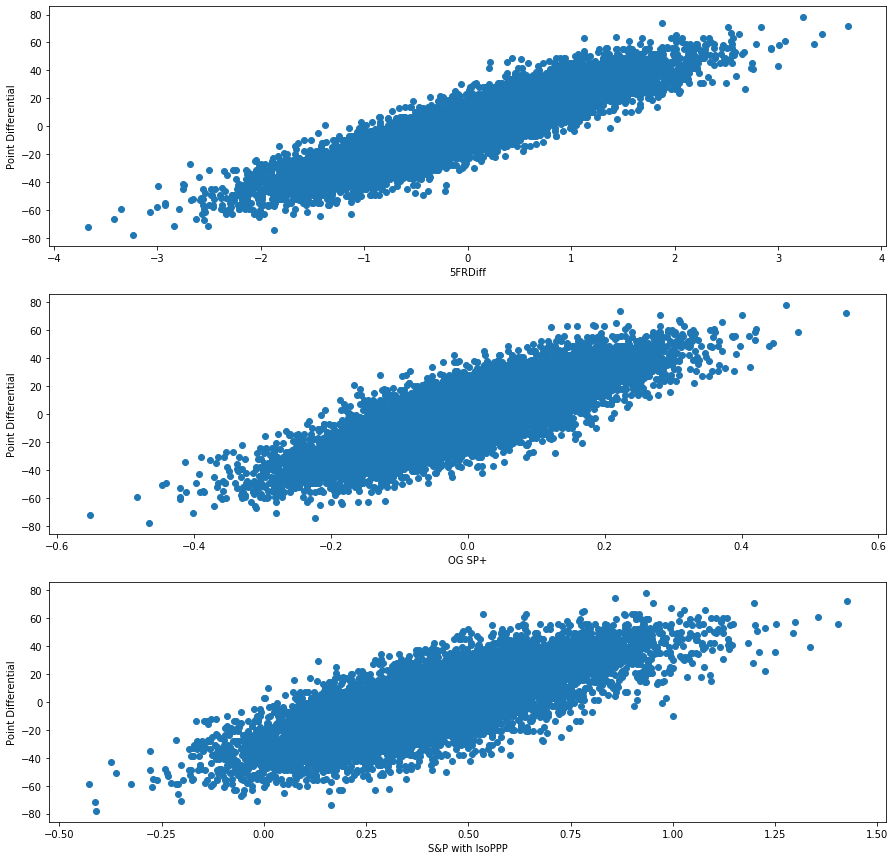

In [16]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [17]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911990,0.759463
S&PIsoPPPDiff,0.911990,1.000000,0.816783
PtsDiff,0.759463,0.816783,1.000000


In [18]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037223,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
0,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474277,0.181656
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583588,0.499553


In [19]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [20]:
# outliers

In [21]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037223,1.907384
1,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474277,0.181656
0,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583588,0.499553
1,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.083333,6.291667,0.811034,...,-0.010417,0.416667,0.541667,0.095238,0.095238,0.750000,5.255388,0.510776,0.583588,0.499553
0,UCLA,2012,322430242,49.0,25.0,0.361313,0.536232,0.130435,9.173913,0.824934,...,0.060758,0.200000,0.200000,0.291667,0.291667,0.500000,5.381749,0.763498,0.872336,1.135348


In [22]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [23]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.79930x + 0.01713
Mean Pred Score: 0.11481499112077297
Pred Std Dev: 20.179282709585074
Mean Abs Error: 7.649593233755321
Mdn Abs Error: 6.182188113074369
R-squared: 0.8028404351818176



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.770832,0.574878,0.487643,0.793257,0.622212,0.628781,0.983671,0.557995,0.780136,...,0.571099,0.475384,0.247860,0.155173,0.069461,0.129986,0.182711,0.896356,0.896356,0.896356
OffSRDiff,0.770832,1.000000,0.492221,0.308668,0.711711,0.408083,0.458112,0.769874,0.765620,0.734377,...,0.572240,0.456680,0.208492,0.129512,0.003330,0.054579,0.101286,0.924321,0.924321,0.924321
OffERDiff,0.574878,0.492221,1.000000,0.147483,0.506955,0.322134,0.365302,0.564035,0.384036,0.801639,...,0.223521,0.228230,0.160693,0.085331,0.006545,0.043677,0.068705,0.528658,0.528658,0.528658
FPDiff,0.487643,0.308668,0.147483,1.000000,0.597998,0.135177,0.104020,0.462877,0.097743,0.226288,...,0.294469,0.251545,0.333035,0.231768,0.218818,0.244224,0.166237,0.566987,0.566987,0.566987
OppRateDiff,0.793257,0.711711,0.506955,0.597998,1.000000,0.237505,0.245877,0.793289,0.349231,0.681727,...,0.536882,0.439426,0.255266,0.157244,0.039811,0.107545,0.222992,0.831243,0.831243,0.831243
OppEffDiff,0.622212,0.408083,0.322134,0.135177,0.237505,1.000000,0.758887,0.616244,0.510933,0.448314,...,0.322581,0.285665,0.135827,0.081777,0.051317,0.074684,0.363483,0.506549,0.506549,0.506549
OppPPDDiff,0.628781,0.458112,0.365302,0.104020,0.245877,0.758887,1.000000,0.634815,0.560456,0.495124,...,0.347420,0.306352,0.129885,0.111602,0.028265,0.055284,0.072125,0.572462,0.572462,0.572462
PPDDiff,0.983671,0.769874,0.564035,0.462877,0.793289,0.616244,0.634815,1.000000,0.560535,0.768101,...,0.574369,0.471201,0.245027,0.154589,0.064644,0.130401,0.175359,0.890888,0.890888,0.890888
OppSRDiff,0.557995,0.765620,0.384036,0.097743,0.349231,0.510933,0.560456,0.560535,1.000000,0.562612,...,0.393113,0.310366,0.172226,0.074767,-0.001888,0.019762,-0.014178,0.698913,0.698913,0.698913
YPPDiff,0.780136,0.734377,0.801639,0.226288,0.681727,0.448314,0.495124,0.768101,0.562612,1.000000,...,0.473985,0.446358,0.172902,0.089761,-0.018712,0.027412,0.095862,0.763852,0.763852,0.763852


In [24]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.753505,0.770832,0.727138,0.901924,0.487643,0.512682,0.896356,0.896356,0.896356
ActPts,0.753505,1.000000,0.566972,0.545288,0.678237,0.380197,0.384489,0.669983,0.669983,0.669983
Eff,0.770832,0.566972,1.000000,0.656842,0.806666,0.308668,0.306863,0.924321,0.924321,0.924321
Expl,0.727138,0.545288,0.656842,1.000000,0.699344,0.204880,0.251513,0.698744,0.698744,0.698744
FinDrv,0.901924,0.678237,0.806666,0.699344,1.000000,0.421926,0.440980,0.922714,0.922714,0.922714
FldPos,0.487643,0.380197,0.308668,0.204880,0.421926,1.000000,0.394710,0.566987,0.566987,0.566987
Trnovr,0.512682,0.384489,0.306863,0.251513,0.440980,0.394710,1.000000,0.508900,0.508900,0.508900
5FR,0.896356,0.669983,0.924321,0.698744,0.922714,0.566987,0.508900,1.000000,1.000000,1.000000
5FRDiff,0.896356,0.669983,0.924321,0.698744,0.922714,0.566987,0.508900,1.000000,1.000000,1.000000
PredPtsDiff,0.896356,0.669983,0.924321,0.698744,0.922714,0.566987,0.508900,1.000000,1.000000,1.000000


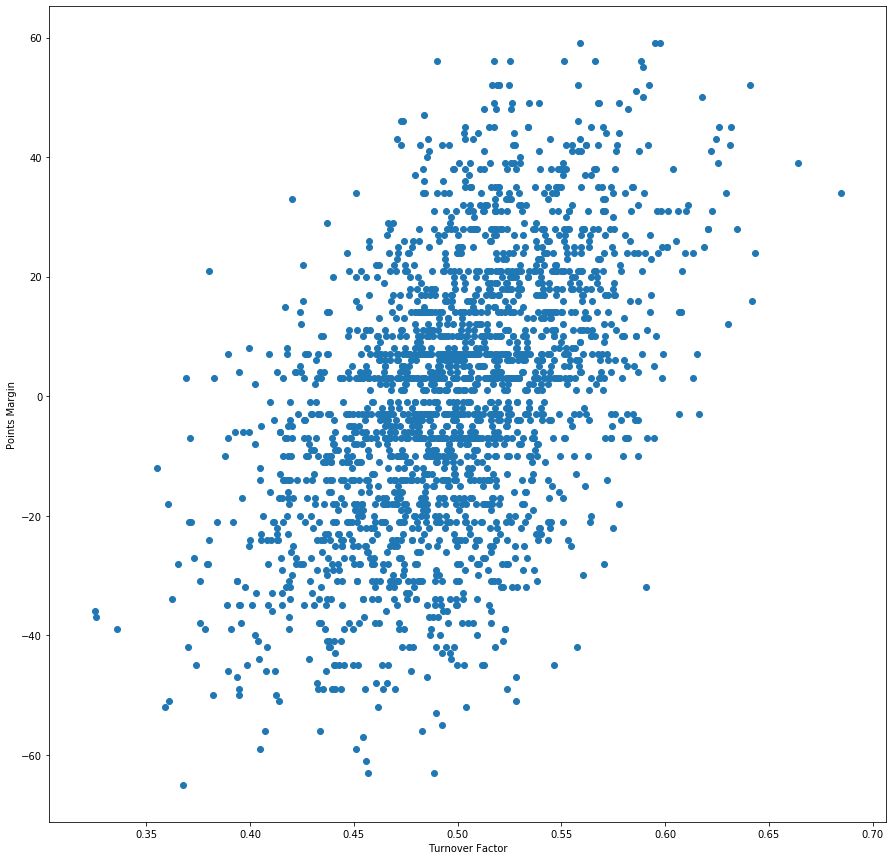

In [25]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

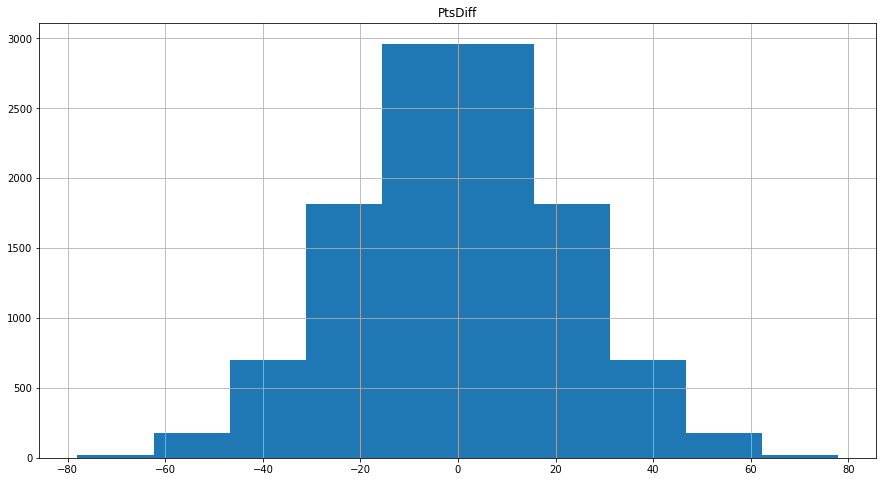

In [26]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

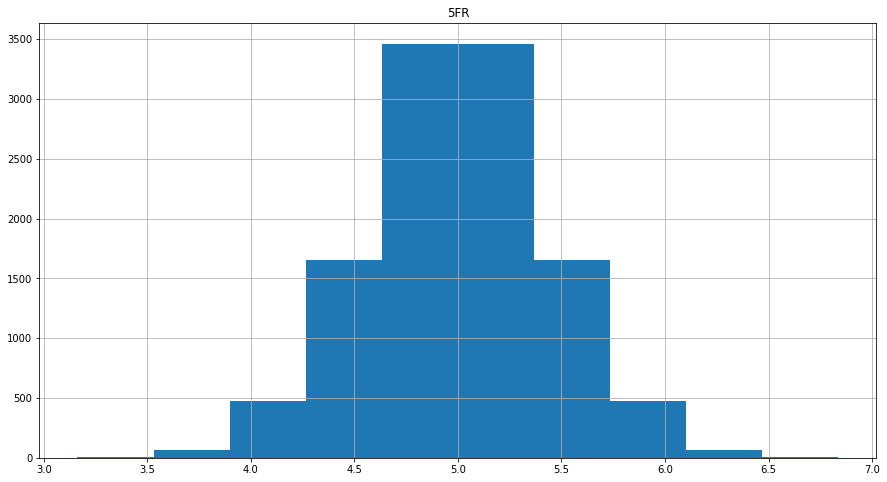

In [27]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

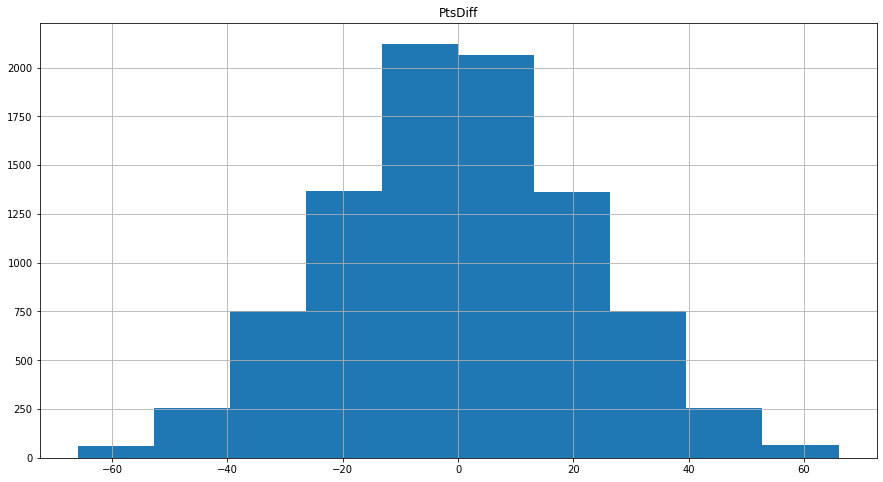

In [28]:
train_data.hist(column='PtsDiff', figsize=(15,8));

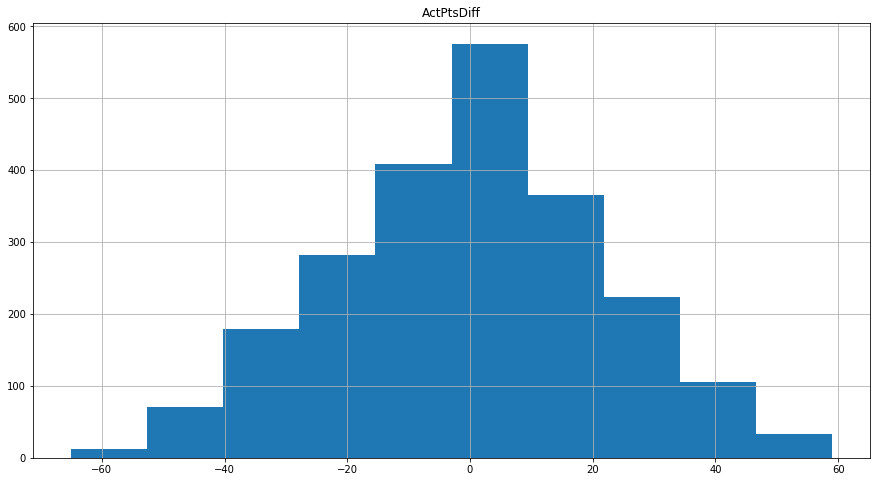

In [29]:
test.hist(column='ActPtsDiff', figsize=(15,8));

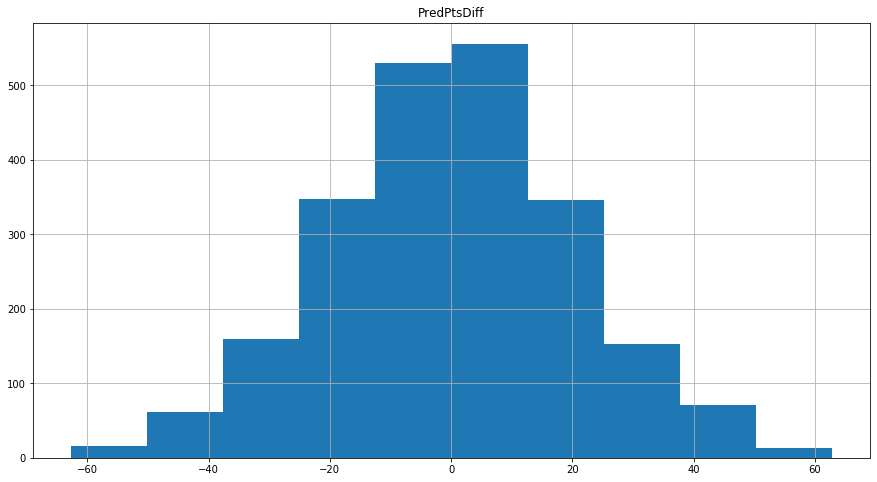

In [30]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [31]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [32]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.2006865628503323)
Z score: -0.16430225006938706
Win Prob for Virginia Tech: 43.47%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [33]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.359608974688202)
Z score: -0.5686239759334295
Win Prob for Georgia Tech: 28.48%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [34]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5581125081612104)
Z score: -0.03334744395856774
Win Prob for Georgia Tech: 48.67%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [35]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.5621077956136165)
Z score: 0.1708332676688946
Win Prob for Mississippi State: 56.78%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [36]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -4.997063938867512)
Z score: -0.2533231236985527
Win Prob for Texas A&M: 40.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [37]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.937987,13,12.0,1.0
2,Clemson,0.931146,13,12.0,1.0
3,Alabama,0.906789,12,11.0,1.0
4,LSU,0.905211,13,12.0,1.0
5,Wisconsin,0.868544,13,11.0,2.0
6,Utah,0.838956,13,11.0,2.0
7,Oklahoma,0.821667,13,11.0,2.0
8,Oregon,0.808281,13,11.0,2.0
9,Appalachian State,0.793212,13,10.0,3.0
10,Georgia,0.785262,13,10.0,3.0


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.476345,1.523655
21,Clemson,10.573044,2.426956
53,LSU,10.343991,2.656009
128,Wisconsin,9.617931,3.382069
2,Alabama,9.281546,2.718454
115,Utah,9.143348,3.856652
78,Oklahoma,9.045364,3.954636
3,Appalachian State,8.727104,4.272896
82,Oregon,8.724097,4.275903
34,Georgia,8.513887,4.486113


In [39]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
5,Fresno State,2012,5.309021,6
6,Georgia,2012,5.304040,7
7,Notre Dame,2012,5.289858,8
8,Utah State,2012,5.267835,9
9,Kansas State,2012,5.266560,10


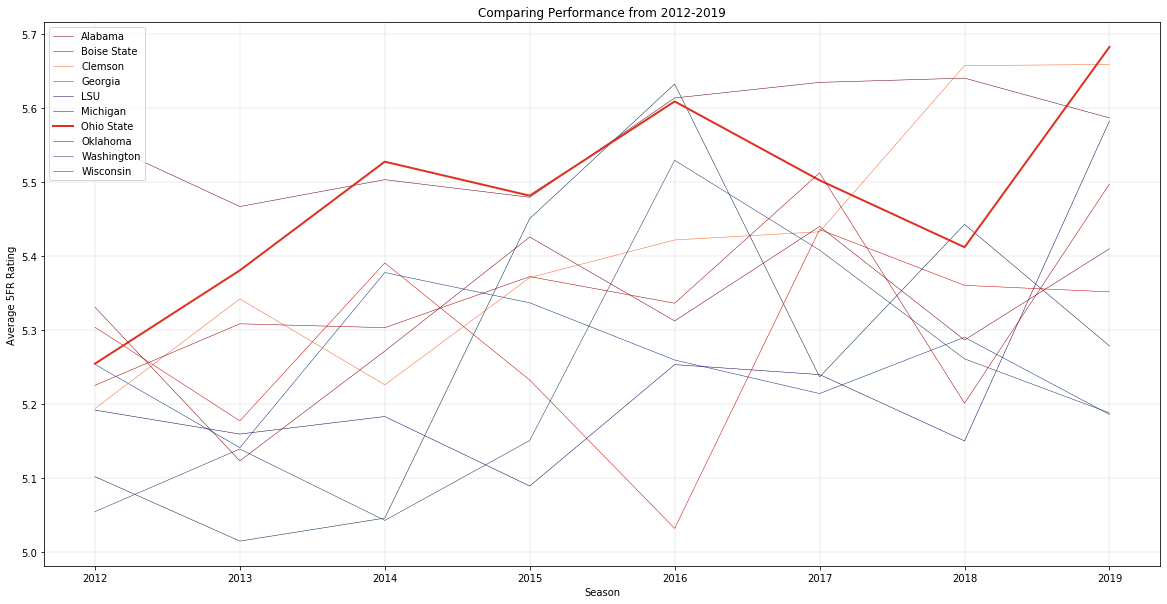

In [40]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [41]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.560512
1,Ohio State,5.481456
2,Clemson,5.413149
3,Wisconsin,5.344711
4,Oklahoma,5.325188
5,Georgia,5.285696
6,Michigan,5.275654
7,Boise State,5.257562
8,LSU,5.231349
9,Washington,5.221882


In [42]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
900,Ohio State,2019,5.682812,1
127,Florida State,2013,5.667090,1
901,Clemson,2019,5.659044,2
770,Clemson,2018,5.657551,1
771,Alabama,2018,5.640608,2
640,Alabama,2017,5.634880,1
512,Michigan,2016,5.632687,1
513,Alabama,2016,5.613788,2
514,Ohio State,2016,5.609128,3
902,Alabama,2019,5.586845,3


In [43]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
280,Georgia Tech,2014,5.189151,25
65,Georgia Tech,2012,5.002690,66
194,Georgia Tech,2013,4.998730,68
844,Georgia Tech,2018,4.984770,75
727,Georgia Tech,2017,4.918923,88
592,Georgia Tech,2016,4.894851,81
473,Georgia Tech,2015,4.827962,90
1018,Georgia Tech,2019,4.620667,119


In [44]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [45]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.15112683786097014, -20.702385575032565]

In [46]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
#     ['Cincinnati', 'Boston College',7], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
#     ['Tennessee', 'Indiana', 1.5], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
#     ['Ohio', 'Nevada', 7.5], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
#     ['Tulane', 'Southern Mississippi', 7], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Tennessee,Indiana,1.5,-1.436204,0.469367,False,Indiana,Indiana
0,Ohio,Nevada,7.5,6.348431,0.621306,False,Ohio,Nevada
0,Tulane,Southern Mississippi,7.0,-1.927711,0.459688,False,Southern Mississippi,Southern Mississippi
0,Louisiana,Miami (OH),14.0,-0.091175,0.495928,False,Miami (OH),Miami (OH)


In [47]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.29534406787089734)
Z score: 0.008946258365485599
Win Prob for Virginia: 50.36%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [48]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 11.0 (exact value: 10.583340057570393)
Z score: 0.5187758760858787
Win Prob for North Carolina: 69.80%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [49]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.137637435214568)
Z score: 0.9426907149211025
Win Prob for Pittsburgh: 82.71%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [50]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.718740509505256)
Z score: -0.4873094669492455
Win Prob for Auburn: 31.30%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [51]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.32427305952967)
Z score: 1.695276217729957
Win Prob for Georgia: 95.50%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [52]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

In [ ]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

In [ ]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [ ]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [ ]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

In [ ]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

In [ ]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

In [ ]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

In [ ]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

In [ ]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [ ]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

In [ ]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

In [ ]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [ ]:
break_down_box_score(calculate_box_score(401136253, 2019))